# ***Bibliotecas***

In [2]:
# Math
import numpy as np
import random

# NN
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# System
import os
from collections import defaultdict, Counter
import requests

# Metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, OPTICS, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan


# NLP processing
import re
from sklearn.feature_extraction import DictVectorizer
import gensim.downloader as gensim_api
from gensim.models.keyedvectors import KeyedVectors

# Models
from sklearn.linear_model import LogisticRegression

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Graphs and format
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tabulate import tabulate
from rich import print as rprint
from tqdm.notebook import trange, tqdm

2025-04-15 05:29:34.375405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744694974.592418      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744694974.660013      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ***Variables globales***

In [3]:
def set_seed(seed=42):
    # Semilla para Python (built-in random)
    random.seed(seed)
    # Semilla para NumPy
    np.random.seed(seed)
    # Semilla para PyTorch (si lo usas)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # Configurar variable de entorno para Python (opcional pero recomendado)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(29)
RANDOM_STATE=29

# ***Contexto***

## Corpus

### https://universaldependencies.org/

In [4]:
URL = "https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-AnCora/refs/heads/master/es_ancora-ud-train.conllu"

In [5]:
raw_data = requests.get(URL).text

### Estandarización de POS tagsets y grammatical features: formato CoNLL

Hay dos esquemas de anotación populares:

1. El *Universal Part-of-Speech Tagset (UPOS)* para etiquetas POS
2. MULTEXT para *grammatical features*

Estos formatos fueron adoptados en los shared tasks de *The Conference on Natural Language Learning (CoNLL)* convirtiendose en el estandar *de facto* para entrenar modelos de *machine-learning* para resolver diversas tareas como: POS tagging, parse mofphologico, parseo de dependencias, entre otros.

In [6]:
def get_raw_corpus(lang: str) -> str:
    """Obtiene el corpus crudo de Universal Dependencies

    Parameters
    ----------
    lang: str
        Idioma del corpus. Puede ser "es" o "en"

    Return
    ------
    str
        Corpus crudo en formato CoNLL
    """
    file_variants = ["train", "test", "dev"]
    result = dict.fromkeys(file_variants)
    DATASETS = {"es": ["UD_Spanish-AnCora", "es_ancora-ud"], "en": ["UD_English-GUM", "en_gum-ud"]}
    repo, file_name = DATASETS[lang]
    for variant in file_variants:
        url = f"https://raw.githubusercontent.com/UniversalDependencies/{repo}/refs/heads/master/{file_name}-{variant}.conllu"
        r = requests.get(url)
        result[variant] = r.text
    return result

In [7]:
raw_corpus = get_raw_corpus("en")
raw_spanish_corpus = get_raw_corpus("es")

In [8]:
class Token(dict):
    """Modela cada renglon de un corpus en formato CoNLL
    """
    pass

In [9]:
class CoNLLDictorizer:
    """Convierte un corpus en formato CoNLL a una lista de diccionarios

    Define los métodos fit, transform y fit_transform para que
    sea compatible con la api de scikit-learn.

    Parameters
    ----------
    column_names: list
        Nombre de las columnas del corpus.
        Default: ["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]
    sent_sep: str
        Separador de oraciones. Default: "\n\n"
    col_sep: str
        Separador de columnas. Default: "\t+"
    """
    DEFAULT_COLS = [
        "ID",
        "FORM",
        "LEMMA",
        "UPOS",
        "XPOS",
        "FEATS",
        "HEAD",
        "DEPREL",
        "HEAD",
        "DEPS",
        "MISC",
    ]

    def __init__(self, column_names: list=DEFAULT_COLS, sent_sep="\n\n", col_sep="\t+"):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus: str) -> list[Token]:
        """Convierte un corpus en formato CoNLL a una lista de diccionarios.

        Parameters
        ----------
        corpus: str
            Corpus en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens del corpus
        """
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence: list[str]) -> list[Token]:
        """Preprocesa una oración en formato CoNLL

        Ignora las lineas que comienzan con "#" y separa
        cada línea en un diccionario.

        Parameters
        ----------
        sentence: str
            Oracion en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens de la oración
        """
        rows = re.split("\n", sentence)
        rows = [row for row in rows if row[0] != "#"]
        return [
            Token(dict(zip(self.column_names, re.split(self.col_sep, row))))
            for row in rows
        ]

In [10]:
conll_dict = CoNLLDictorizer()

In [11]:
corpora = {}
for variant in ["train", "test", "dev"]:
    corpora[variant] = conll_dict.transform(raw_corpus[variant])

In [12]:
spanish_corpora = {}
for variant in ["train", "test", "dev"]:
    spanish_corpora[variant] = conll_dict.transform(raw_spanish_corpus[variant])

## Baseline: Look-up dictionary

### 0. Usar el POS tag más frecuente

In [13]:
def calculate_pos_distribution(corpus: list[list[Token]], word_key="FORM", pos_key="UPOS"):
    """Calcula la distribución de POS para cada palabra

    Parameters
    ----------
    corpus: list[Token]
        Corpus en formato CoNLL
    word_key: str
        Nombre de la columna que contiene la palabra. Default: "FORM"
    pos_key: str
        Nombre de la columna que contiene la etiqueta POS. Default: "UPOS"

    Return
    ------
    dict
        Diccionario con la distribución de POS para cada palabra
    """
    pos_distributions = {}
    for sentence in corpus:
        for token in sentence:
            word = token[word_key]
            pos_tag = token[pos_key]
            if word not in pos_distributions:
                pos_distributions[word] = Counter()
            pos_distributions[word][pos_tag] += 1
    return pos_distributions

In [14]:
pos_dist = calculate_pos_distribution(corpora["train"])
spanish_pos_dist = calculate_pos_distribution(spanish_corpora["train"])

In [15]:
baseline = {}
for word in pos_dist:
    # Elegimos la etiqueta POS más frecuente
    baseline[word] = max(pos_dist[word], key=pos_dist[word].get)

In [16]:
spanish_baseline = {}
for word in spanish_pos_dist:
    spanish_baseline[word] = max(spanish_pos_dist[word], key=spanish_pos_dist[word].get)

El conjuto de pruebas puede contener palabras no vistas en nuestro conjunto de entrenamiento. Podemos aplicar una estrategía simple y obtener la etiqueta más común de nuestro conjunto de validación.

In [17]:
def unseen_words_pos_dist(corpus: list[list[Token]], model: dict, word_key="FORM", pos_key="UPOS"):
    """Obtiene la distribución de POS de las palabras no vistas en el modelo

    Parameters
    ----------
    corpus: list[Token]
        Corpus en formato CoNLL
    model: dict
        Modelo de lenguaje
    """
    unseen_words = Counter()
    for sentence in corpus:
        for token in sentence:
            if not token[word_key] in model:
                unseen_words[token[pos_key]] += 1
    return unseen_words

In [18]:
unseen_pos_dist = unseen_words_pos_dist(corpora["dev"], baseline)

In [19]:
spanish_unseen_pos_dist = unseen_words_pos_dist(spanish_corpora["dev"], spanish_baseline)

In [20]:
BACKOFF_POS = max(unseen_pos_dist, key=unseen_pos_dist.get)
rprint(f"Backoff POS: {BACKOFF_POS}")

Backoff POS: NOUN

In [21]:
SPANISH_BACKOFF_POS = max(spanish_unseen_pos_dist, key=spanish_unseen_pos_dist.get)
rprint(f"Spanish Backoff POS: {SPANISH_BACKOFF_POS}")

Spanish Backoff POS: PROPN

### Probando nuestro baseline

In [22]:
def get_predictions(corpus: list[list[Token]], model: dict, backoff_pos: str, word_key="FORM", pos_key="UPOS"):
    """Obtiene las predicciones del modelo y el gold standar

    Parameters
    ----------
    corpus: list[Token]
        Corpus en formato CoNLL
    model: dict
        Modelo de lenguaje
    """
    predictions = []
    gold_standar = []
    for sentence in corpus:
        for token in sentence:
            word = token[word_key]
            gold = token[pos_key]
            predictions.append(model.get(word, backoff_pos))
            gold_standar.append(gold)
    assert len(predictions) == len(gold_standar)
    return predictions, gold_standar

In [23]:
predictions, gold_standar = get_predictions(corpora["test"], baseline, BACKOFF_POS)

In [24]:
def get_accuracy(predictions: list[str], gold_standar: list[str]) -> float:
    """Obtiene la precisión del modelo

    Parameters
    ----------
    predictions: list[str]
        Predicciones del modelo
    gold_standar: list[str]
        Etiquetas gold standar

    Return
    ------
    float
        Precisión del modelo
    """
    correct = 0
    for p, g in zip(predictions, gold_standar):
        if p == g:
            correct += 1
    return (correct / len(predictions))

In [25]:
baseline_accuracy = get_accuracy(predictions, gold_standar)
rprint(f"Accuracy [green]ENGLISH[/]: {baseline_accuracy * 100:.2f}%")

Accuracy ENGLISH: 86.96%

In [26]:
spanish_predictions, spanish_gold_standar = get_predictions(
    spanish_corpora["test"], spanish_baseline, SPANISH_BACKOFF_POS)

In [27]:
rprint(f"Accuracy [Spanish]: {get_accuracy(spanish_predictions, spanish_gold_standar) * 100:.2f}%")

Accuracy [Spanish]: 92.50%

## Clasificadores Lineales

### Preprocesamiento

In [28]:
def extract_pairs(sentence: list[Token], word_key="FORM", pos_key="UPOS"):
    """ Extrae las palabras y sus etiquetas POS

    Parameters
    ----------
    sentence: list[Token]
        Oracion en formato CoNLL
    word_key: str
        Nombre de la columna que contiene la palabra. Default: "FORM"
    pos_key: str
        Nombre de la columna que contiene la etiqueta POS. Default: "UPOS"

    Return
    ------
    tuple
        Tupla con las palabras y sus etiquetas POS
    """
    _input, target = [], []
    for token in sentence:
        _input += [token[word_key]]
        target += [token.get(pos_key, None)]
    return _input, target

In [29]:
train_pairs = [extract_pairs(sentence) for sentence in corpora["train"]]
val_pairs = [extract_pairs(sentence) for sentence in corpora["dev"]]
test_pairs = [extract_pairs(sentence) for sentence in corpora["test"]]

In [30]:
train_sent_words, train_sent_pos = zip(*train_pairs)
val_sent_words, val_sent_pos = zip(*val_pairs)
test_sent_words, test_sent_pos = zip(*test_pairs)

In [31]:
def extract_features(sentence: list[str], context: int=2) -> list:
    """Extraer las features de cada oración

    Para tener siempre la misma cantidad de features
    por oración aplica un ventaneo llenando los espacios
    restantes con "<BOS>" y "<EOS>"

    Parameters
    ----------
    sentence: list[str]
        Oracion en formato CoNLL
    context: int
        Cantidad de palabras a la izquierda y derecha de la palabra actual. Default: 2

    Return
    ------
    list
        Lista de diccionarios con las features de cada palabra
    """
    start_pad = ["<BOS>"] * context
    end_pad = ["<EOS>"] * context
    sentence = start_pad + sentence + end_pad
    features = []
    for i in range(len(sentence) - 2 * context):
        aux = []
        for j in range(2 * context + 1):
            aux += [sentence[i + j]]
        features += [aux]
    features = [dict(enumerate(feature)) for feature in features]
    return features

In [32]:
def extract_corpus_features(words_set: list[list[str]], pos_tags_set: list[list[str]]):
    """Extraer las features del corpus

    Parameters
    ----------
    words_set: list[list[str]]
        Lista de listas con las palabras de cada oración
    pos_tags_set: list[list[str]]
        Lista de listas con las etiquetas POS de cada oración

    Return
    ------
    tuple
        Tupla con las features y las etiquetas POS
    """
    X_features = [row for sent in words_set for row in extract_features(sent)]
    y_features = [pos for sent in pos_tags_set for pos in sent]
    return X_features, y_features

In [33]:
X_train_features, y_train_features = extract_corpus_features(train_sent_words, train_sent_pos)
X_val_features, y_val_features = extract_corpus_features(val_sent_words, val_sent_pos)
X_test_features, y_test_features = extract_corpus_features(test_sent_words, test_sent_pos)

## 1. Regresión logística

In [34]:
vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(X_train_features)

In [35]:
X_train.shape

(166918, 85160)

In [36]:
v = DictVectorizer(sparse=False)

rprint(X_train_features[0:2])
result = v.fit_transform(X_train_features[0:2])
result

[
    {0: '<BOS>', 1: '<BOS>', 2: 'Aesthetic', 3: 'Appreciation', 4: 'and'},
    {0: '<BOS>', 1: 'Aesthetic', 2: 'Appreciation', 3: 'and', 4: 'Spanish'}
]

array([[1., 1., 0., 1., 0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 1., 0.]])

### Aplicando el clasificador

In [37]:
%%time
classifier = LogisticRegression(max_iter=500)
logistic_model = classifier.fit(X_train, y_train_features)

CPU times: user 8min 20s, sys: 19.7 s, total: 8min 40s
Wall time: 2min 30s


In [38]:
def predict_sentence(sentence: list[Token], model: LogisticRegression, vectorizer: DictVectorizer, ppos_key="PPOS") -> list[Token]:
    """Realiza la predicción de las etiquetas POS para una oración

    Parameters
    ----------
    sentence: list[Token]
        Oración en formato CoNLL
    model: LogisticRegression
        Modelo de clasificador
    vectorizer: DictVectorizer
        Vectorizador de features

    Return
    ------
    list[Token]
        Oración en formato CoNLL con las etiquetas POS predichas
    """
    sent_words, _ = extract_pairs(sentence)
    sent_features = extract_features(sent_words)
    X_test = vectorizer.transform(sent_features)
    y_pred_vec = model.predict(X_test)
    for token, y_pred in zip(sentence, y_pred_vec):
        # Add predicted pos
        token[ppos_key] = y_pred
    return sentence

In [39]:
correct = 0
tokens_count = 0
for sentence in corpora["test"]:
    pred_sent = predict_sentence(sentence, logistic_model, vectorizer)
    for token in pred_sent:
        tokens_count += 1
        if token["UPOS"] == token["PPOS"]:
            correct += 1

In [40]:
logistic_accuracy = (correct / tokens_count)
rprint(f"Accuracy (Logistic): {logistic_accuracy * 100:.2f}%")
rprint(f"Δ from baseline: {(logistic_accuracy - baseline_accuracy) * 100:.2f}%")

Accuracy (Logistic): 90.62%

Δ from baseline: 3.66%

## 2. Feed-forward Networks

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
rprint(f"Working on device={device}")

Working on device=cuda

### 2.1 Single layer

In [42]:
# Nos aseguramos de la consistencia de los vectores
ff_vectorizer = DictVectorizer(sparse=False, dtype=np.float32)

In [43]:
X_train_ff = ff_vectorizer.fit_transform(X_train_features)
X_val_ff = ff_vectorizer.transform(X_val_features)
X_test_ff = ff_vectorizer.transform(X_test_features)

In [44]:
X_train_t = torch.from_numpy(X_train_ff)
X_val_t = torch.from_numpy(X_val_ff)
X_test_t = torch.from_numpy(X_test_ff)

In [45]:
idx2pos = dict(enumerate(set(y_train_features)))
pos2idx = {v: k for k, v in idx2pos.items()}

In [46]:
y_train_t = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_train_features)))
y_val_t = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_val_features)))
y_test_t = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_test_features)))

In [47]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2048, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

In [48]:
LR = 0.005
EPOCHS = 10

In [49]:
class FeedForward(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

In [50]:
ff_model = FeedForward(X_train_t.size(dim=1), len(pos2idx)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(ff_model.parameters(), lr=LR)

In [51]:
def evaluate_ff(model: nn.Module, loss_fn: nn.Module, dataloader: DataLoader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        accuracy = 0
        batch_count = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            batch_count += 1
            y_batch_pred = model(X_batch)
            total_loss += loss_fn(y_batch_pred, y_batch).item()
            accuracy += (sum(torch.argmax(y_batch_pred, dim=-1) == y_batch) / y_batch.size(dim=0)).item()
    return total_loss / batch_count, accuracy / batch_count


#### Training loop

In [52]:
ff_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}
best_val_acc = -float('inf')


for epoch in trange(EPOCHS):
    train_loss, train_acc, batch_count = 0, 0, 0
    ff_model.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_count += 1
        y_batch_pred = ff_model(X_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc += (sum(torch.argmax(y_batch_pred, dim=-1) == y_batch) / y_batch.size(dim=0)).item()
        train_loss += loss.item()
    ff_model.eval()
    with torch.no_grad():
        ff_history["accuracy"].append(train_acc / batch_count)
        ff_history["loss"].append(train_loss / batch_count)
        val_loss, val_acc = evaluate_ff(ff_model, loss_fn, val_dataloader)
        ff_history["val_loss"].append(val_loss)
        ff_history["val_accuracy"].append(val_acc)
    
    # Guardado condicional
    if best_val_acc < val_acc:
        best_ff_dict = ff_model.state_dict()
        path_ff: str = f"pos_tagger_ff_best_{device}_{epoch}.pth"
        best_val_acc = val_acc
    
    # Guardar solo último modelo para continuar entrenamiento
    torch.save({
        'epoch': epoch,
        'model_state_dict': ff_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': ff_history
    }, "pos_tagger_ff_last_checkpoint.pth")

torch.save(best_ff_dict, path_ff)
torch.save(ff_history, f"pos_tagger_ff.history")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

In [53]:
def plot_history(history: dict) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(history["accuracy"], label="Accuracy")
    axes[0].plot(history["val_accuracy"], label="Validation accuracy")
    axes[0].set_title("Accuracy")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    axes[1].plot(history["loss"], label="Loss")
    axes[1].plot(history["val_loss"], label="Validation loss")
    axes[1].set_title("Loss")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.show()

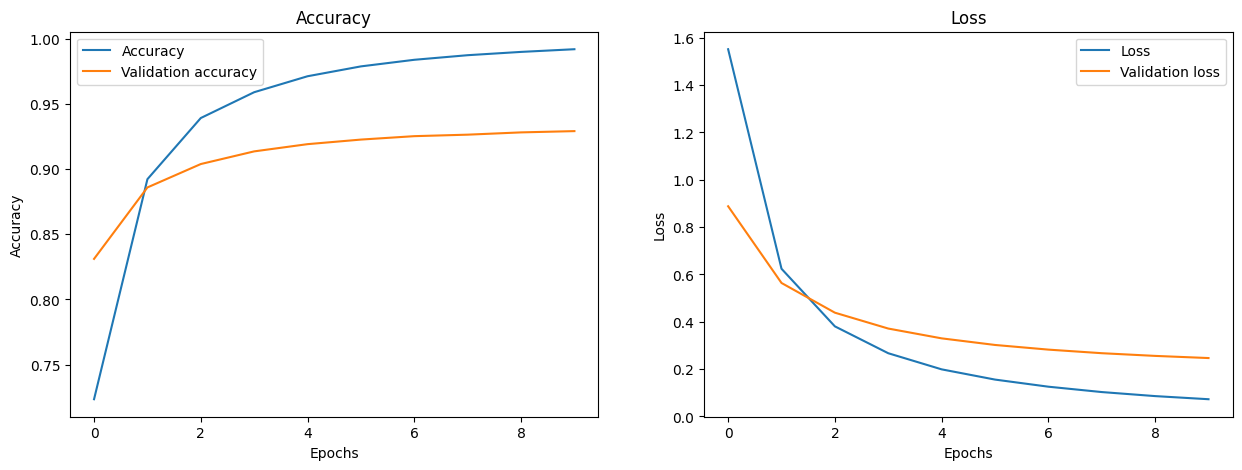

In [54]:
plot_history(ff_history)

In [55]:
_, accuracy_ff = evaluate_ff(ff_model, loss_fn, test_dataloader)

In [56]:
rprint(f"Accuracy (FF): {accuracy_ff * 100:.2f}%")
rprint(f"Δ from baseline: {(accuracy_ff - baseline_accuracy) * 100:.2f}%")
rprint(f"Δ from logistic: {(accuracy_ff - logistic_accuracy) * 100:.2f}%")

Accuracy (FF): 91.77%

Δ from baseline: 4.81%

Δ from logistic: 1.15%

### 2.2 Embeddings

In [58]:
vectors = gensim_api.load("glove-wiki-gigaword-100")

In [59]:
def get_embeddings(model: KeyedVectors) -> dict[str, torch.FloatTensor]:
    """Obtiene los embeddings de las palabras del modelo

    Parameters
    ----------
    model: KeyedVectors
        Modelo de embeddings

    Return
    ------
    dict[str, torh.FloatTensor]
        Diccionario con las palabras como keys y los embeddings como values
    """
    embeddings = {}
    for word, idx in model.key_to_index.items():
        embeddings[word] = torch.FloatTensor(vectors[idx].copy())
    return embeddings

In [60]:
embeddings = get_embeddings(vectors)

In [61]:
X_train_features, y_train_features = extract_corpus_features(train_sent_words, train_sent_pos)
X_val_features, y_val_features = extract_corpus_features(val_sent_words, val_sent_pos)
X_test_features, y_test_features = extract_corpus_features(test_sent_words, test_sent_pos)

corpus_words = [
    value.lower() for feature in X_train_features
    for value in feature.values()
]
corpus_words = sorted(set(corpus_words))

In [62]:
embeddings_words = embeddings.keys()
vocabulary = set(corpus_words + list(embeddings_words))

In [63]:
idx2word = dict(enumerate(vocabulary), start=1)
word2idx = {v: k for k, v in idx2word.items()}

In [64]:
for train_feature in X_train_features:
    for word in train_feature:
        train_feature[word] = word2idx[train_feature[word].lower()]

In [65]:
for val_feature in X_val_features:
    for word in val_feature:
        val_feature[word] = word2idx.get(val_feature[word].lower(), 0)


In [66]:
for test_feature in X_test_features:
    for word in test_feature:
        test_feature[word] = word2idx.get(test_feature[word].lower(), 0)

In [67]:
embedd_vectorizer = DictVectorizer(sparse=False, dtype=np.int64)

X_train_emb = embedd_vectorizer.fit_transform(X_train_features)
X_val_emb = embedd_vectorizer.transform(X_val_features)
X_test_emb = embedd_vectorizer.transform(X_test_features)

In [68]:
X_train_emb = torch.from_numpy(X_train_emb)
X_val_emb = torch.from_numpy(X_val_emb)
X_test_emb = torch.from_numpy(X_test_emb)

In [69]:
EMBEDDING_DIM = 100

In [70]:
embedding_table = torch.randn((len(vocabulary) + 1, 100)) / 10

In [71]:
for word in vocabulary:
    if word in embeddings:
        embedding_table[word2idx[word]] = embeddings[word]

In [72]:
idx2pos = dict(enumerate(set(y_train_features)))
pos2idx = {v: k for k, v in idx2pos.items()}

In [73]:
y_train_e = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_train_features)))
y_val_e = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_val_features)))
y_test_e = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_test_features)))

In [74]:
train_dataset = TensorDataset(X_train_emb, y_train_e)
val_dataset = TensorDataset(X_val_emb, y_val_e)
test_dataset = TensorDataset(X_test_emb, y_test_e)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2048, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

In [75]:
LR = 0.005
EPOCHS = 10

In [76]:
class EmbeddingsModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 num_classes: int,
                 freeze_embeddings: bool = False):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings
            )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(5 * embedding_table.size(dim=1), num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        flatten = self.flatten(embeds)
        logist = self.linear(flatten)
        return logist

In [77]:
embeddings_model = EmbeddingsModel(embedding_table, len(pos2idx)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(embeddings_model.parameters(), lr=LR)

#### Training loop (with embeddings)

In [78]:
emb_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}
best_val_acc = -float('inf')

for epoch in trange(EPOCHS):
    train_loss, train_acc, batch_count = 0, 0, 0
    embeddings_model.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_count += 1
        y_batch_pred = embeddings_model(X_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc += (sum(torch.argmax(y_batch_pred, dim=-1) == y_batch) / y_batch.size(dim=0)).item()
        train_loss += loss.item()
    embeddings_model.eval()
    with torch.no_grad():
        emb_history["accuracy"].append(train_acc / batch_count)
        emb_history["loss"].append(train_loss / batch_count)
        # Reutilizamos la función de evaluación de FF
        val_loss, val_acc = evaluate_ff(embeddings_model, loss_fn, val_dataloader)
        emb_history["val_loss"].append(val_loss)
        emb_history["val_accuracy"].append(val_acc)
    # Guardado condicional
    if best_val_acc < val_acc:
        best_emb_dict = embeddings_model.state_dict()
        path_emb: str = f"pos_tagger_emb_best_{device}_{epoch}.pth"
        best_val_acc = val_acc
    
    # Guardar solo último modelo para continuar entrenamiento
    torch.save({
        'epoch': epoch,
        'model_state_dict': embeddings_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': emb_history
    }, "pos_tagger_emb_checkpoint_last_checkpoint.pth")

torch.save(best_emb_dict, path_emb)
torch.save(emb_history, f"pos_tagger_emb.history")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

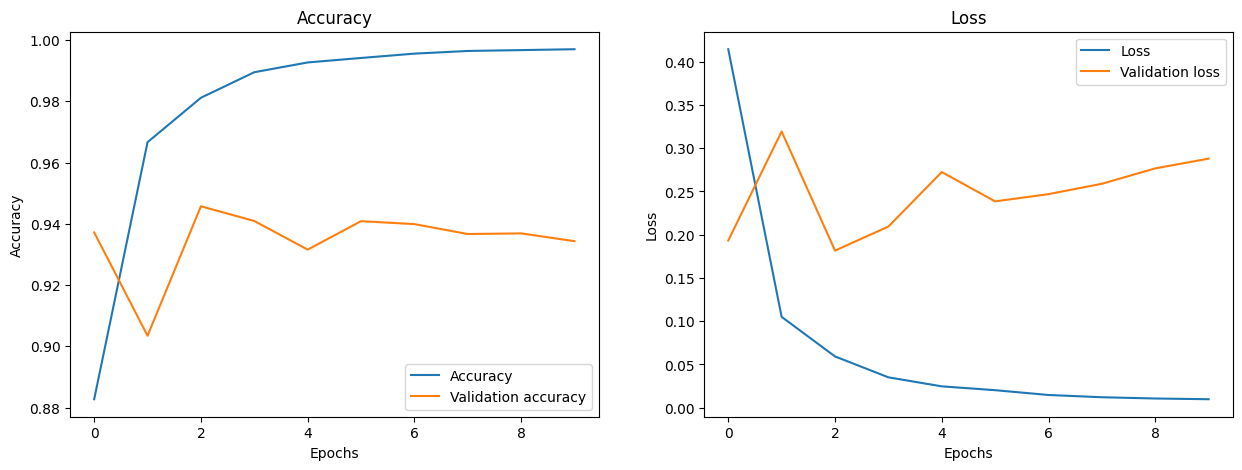

In [79]:
plot_history(emb_history)

In [80]:
_, accuracy_emb = evaluate_ff(embeddings_model, loss_fn, test_dataloader)
rprint(f"Accuracy (Embeddings): {accuracy_emb * 100:.2f}%")
rprint(f"Δ from baseline: {(accuracy_emb - baseline_accuracy) * 100:.2f}% ({baseline_accuracy * 100:.2f}%)")
rprint(f"Δ from logistic: {(accuracy_emb - logistic_accuracy) * 100:.2f}% ({logistic_accuracy * 100:.2f}%)")
rprint(f"Δ from ff: {(accuracy_emb - accuracy_ff) * 100:.2f}% ({accuracy_ff * 100:.2f}%)")

Accuracy (Embeddings): 92.02%

Δ from baseline: 5.06% (86.96%)

Δ from logistic: 1.40% (90.62%)

Δ from ff: 0.25% (91.77%)

## 3. Recurrent Neural Nets (RNNs)

In [81]:
# Todas las palabras a minusculas para que sea compatible con GLoVe
train_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in train_sent_words]
val_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in val_sent_words]
test_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in test_sent_words]

#### Indices

In [82]:
corpus_words_rnn = sorted(set([word for sentence in train_sent_words_rnn for word in sentence]))
pos_list_rnn = sorted(set([pos for sentence in train_sent_pos for pos in sentence]))

In [83]:
embeddings_words_rnn = embeddings.keys()
vocabulary = set(corpus_words_rnn + list(embeddings_words_rnn))

In [84]:
# Start on 2 because id 0 will be pad simbol and 1 will be UNK
idx2word = dict(enumerate(vocabulary), start=2)
idx2pos = dict(enumerate(pos_list_rnn), start=1)

word2idx = {v: k for k, v in idx2word.items()}
pos2idx = {v: k for k, v in idx2pos.items()}

In [85]:
def to_index(corpus: list[list[str]], word2idx: dict[str, int], unk_id: int = 1) -> torch.LongTensor:
    indexes = []
    for sent in corpus:
        sent_indexes = torch.LongTensor(
            list(map(lambda word: word2idx.get(word, unk_id), sent))
        )
        indexes += [sent_indexes]
    return indexes


In [86]:
t = to_index(train_sent_words_rnn[:2], word2idx)

In [87]:
X_train_idx_rnn = to_index(train_sent_words_rnn, word2idx)
Y_train_idx_rnn = to_index(train_sent_pos, pos2idx)

In [88]:
X_val_idx_rnn = to_index(val_sent_words_rnn, word2idx)
Y_val_idx_rnn = to_index(val_sent_pos, pos2idx)

In [89]:
X_test_idx_rnn = to_index(test_sent_words_rnn, word2idx)
Y_test_idx_rnn = to_index(test_sent_pos, pos2idx)

#### Padding

In [90]:
pad_sequence(X_train_idx_rnn[41:43], batch_first=True, padding_value=0)

tensor([[317190, 286420,  65350, 324441,  23391,  60688, 210295, 204857,  37503,
         157245, 288155, 371049, 129908, 356080, 198385, 128159, 110764, 221572,
         341808, 346015, 278839,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [281016,  37503, 157245, 277309,  18888,  52146, 361575,  93585, 352603,
          65350, 124903,  91705,  65350, 356080, 142056, 293603, 236206,  37503,
         378374, 202764, 386011,  18469, 194193, 177533,  65350,    422,  65350,
         128159,  76763, 240506, 151475,  86602, 278839]])

In [91]:
X_train_rnn = pad_sequence(X_train_idx_rnn, batch_first=True, padding_value=0)
Y_train_rnn = pad_sequence(Y_train_idx_rnn, batch_first=True, padding_value=0)

In [92]:
X_val_rnn = pad_sequence(X_val_idx_rnn, batch_first=True, padding_value=0)
Y_val_rnn = pad_sequence(Y_val_idx_rnn, batch_first=True, padding_value=0)

In [93]:
X_test_rnn = pad_sequence(X_test_idx_rnn, batch_first=True, padding_value=0)
Y_test_rnn = pad_sequence(Y_test_idx_rnn, batch_first=True, padding_value=0)

#### Embeddings para RNN

In [94]:
EMBEDDING_DIM = 100

In [95]:
embedding_table = torch.randn((len(vocabulary) + 2, EMBEDDING_DIM)) / 10

In [96]:
for word in vocabulary:
    if word in embeddings:
        embedding_table[word2idx[word]] = embeddings[word]

### La Recurrent Neural Net con pytorch

In [97]:
class RnnModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 hidden_size,
                 num_classes: int,
                 freeze_embeddings: bool = False,
                 num_layers: int=1,
                 bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings,
            padding_idx=0
            )
        self.recurrent = nn.RNN(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        if bidirectional:
            # Dos veces las unidades si es bidireccional
            self.linear = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rec_out, _ = self.recurrent(embeds)
        logist = self.linear(rec_out)
        return logist

In [98]:
rnn_model = RnnModel(
    embedding_table,
    hidden_size=128,
    num_classes=len(pos2idx) + 1,
    freeze_embeddings=False,
    num_layers=2,
    bidirectional=True
).to(device)

In [99]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.NAdam(rnn_model.parameters(), lr=0.005)

#### Training loop

In [100]:
EPOCHS = 10

In [101]:
train_dataset_rnn = TensorDataset(X_train_rnn, Y_train_rnn)
train_dataloader_rnn = DataLoader(train_dataset_rnn, batch_size=512, shuffle=True)

In [102]:
val_dataset_rnn = TensorDataset(X_val_rnn, Y_val_rnn)
val_dataloader_rnn = DataLoader(val_dataset_rnn, batch_size=2048, shuffle=False)

In [103]:
test_dataset_rnn = TensorDataset(X_test_rnn, Y_test_rnn)
test_dataloader_rnn = DataLoader(test_dataset_rnn, batch_size=2048, shuffle=False)

In [104]:
def evaluate_rnn(model: nn.Module, loss_fn: nn.Module, dataloader: DataLoader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        accuracy = 0
        t_words = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch_pred = model(X_batch)
            current_loss = loss_fn(
                y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
                y_batch.reshape(-1)
            )
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            total_loss += n_words + current_loss.item()
            accuracy += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()
        return total_loss / t_words, accuracy / t_words

In [105]:
rnn_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}
for epoch in trange(EPOCHS):
    train_loss, train_acc, t_words = 0, 0, 0
    rnn_model.train()
    for X_batch, y_batch in tqdm(train_dataloader_rnn):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = rnn_model(X_batch)
        loss = loss_fn(
            y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
            y_batch.reshape(-1)
            )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            train_loss += n_words * loss.item()
            train_acc += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()

    rnn_model.eval()
    with torch.no_grad():
        rnn_history["accuracy"].append(train_acc / t_words)
        rnn_history["loss"].append(train_loss / t_words)
        val_loss, val_acc = evaluate_rnn(rnn_model, loss_fn, val_dataloader_rnn)
        rnn_history["val_loss"].append(val_loss)
        rnn_history["val_accuracy"].append(val_acc)

    # Guardado condicional
    if best_val_acc < val_acc:
        best_rnn_dict = rnn_model.state_dict()
        path_rnn: str = f"pos_tagger_rnn_best_{device}_{epoch}.pth"

        best_val_acc = val_acc
    
    # Guardar solo último modelo para continuar entrenamiento
    torch.save({
        'epoch': epoch,
        'model_state_dict': rnn_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': rnn_history
    }, "pos_tagger_rnn_last_checkpoint.pth")
    
torch.save(best_rnn_dict, path_rnn)
torch.save(rnn_history, f"pos_tagger_rnn.history")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

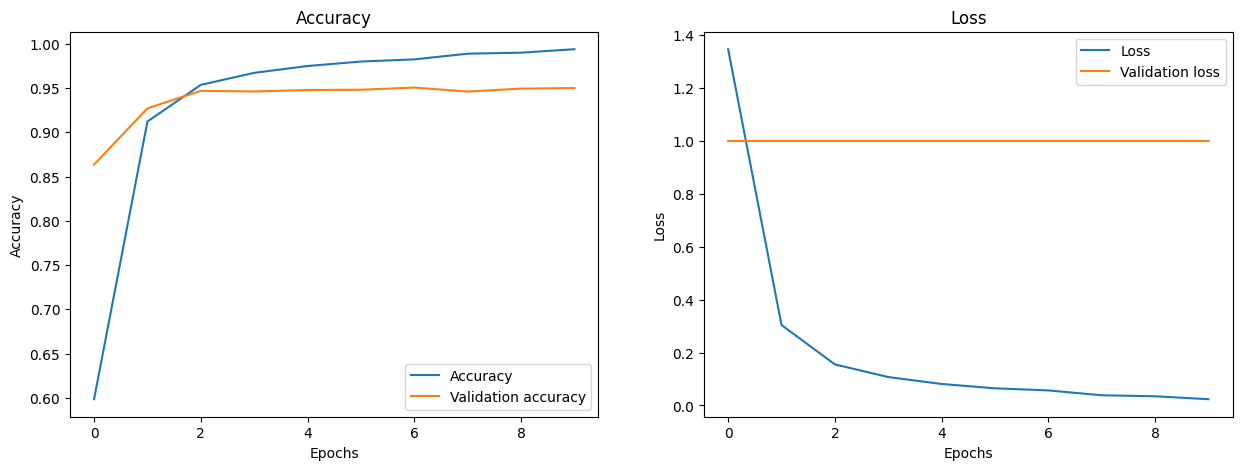

In [106]:
plot_history(rnn_history)

In [107]:
_, accuracy_rnn = evaluate_rnn(rnn_model, loss_fn, test_dataloader_rnn)
rprint(f"Accuracy (RNN): {accuracy_rnn * 100:.2f}%")
rprint(f"Δ accuracy (from baseline): {(accuracy_rnn - baseline_accuracy) * 100:.2f}%")
rprint(f"Δ accuracy (from logistic): {(accuracy_rnn - logistic_accuracy) * 100:.2f}% ({logistic_accuracy * 100:.2f}%)")
rprint(f"Δ accuracy (from ff): {(accuracy_rnn - accuracy_ff) * 100:.2f}% ({accuracy_ff * 100:.2f}%)")
rprint(f"Δ accuracy (from embeddings): {(accuracy_rnn - accuracy_emb) * 100:.2f}% ({accuracy_emb * 100:.2f}%)")

Accuracy (RNN): 93.96%

Δ accuracy (from baseline): 7.00%

Δ accuracy (from logistic): 3.34% (90.62%)

Δ accuracy (from ff): 2.19% (91.77%)

Δ accuracy (from embeddings): 1.94% (92.02%)

# Práctica 5: Tech evolution. Caso POS Tagging

**Fecha de entrega: 13 de Abril 2025 11:59pm**

## ***Ejercicio 1***
- Obten los embeddings de 100 palabras al azar del modelo RNN visto en clase
  - Pueden ser los embeddings estáticos o los dinámicos del modelo

### ***Stratified random sampling of embeddings***

Aunque en principio la tarea de obtener 100 palabras aleatorias del modelo RNN podría parecer trivial, la incorporación de los *embeddings* de las etiquetas POS complica el proceso debido a múltiples factores. Una aproximación intuitiva consistiría en emplear directamente `rnn_model.linear.weight`, ya que estos pesos codifican la información aprendida por el modelo para discriminar entre las distintas etiquetas POS a partir de las salidas de las capas recurrentes. No obstante, dichos vectores no constituyen *embeddings* en el mismo sentido que los correspondientes a las palabras: no residen en el mismo espacio vectorial ni comparten dimensionalidad, lo que imposibilita su proyección conjunta con los *embeddings* léxicos mediante técnicas como PCA, t-SNE o UMAP.  

La metodología adecuada para obtener representaciones vectoriales de las etiquetas POS implica calcular, para cada una de ellas, el promedio de los *embeddings* de todas las palabras asociadas a dicha etiqueta en el conjunto de entrenamiento. Este enfoque garantiza que los centroides resultantes residan en el mismo espacio que los *embeddings* de palabras y reflejen su distribución real:  

$$
\mathrm{Embedding}(POS_i) \;=\; \frac{1}{n_i}\sum_{w \,\in\, \{\text{palabras con } POS_i\}} \mathrm{embedding}(w)
$$  

Sin embargo, este método introduce un desafío adicional: si el cálculo de los promedios se realiza sobre todo el corpus, el resultado estará sesgado hacia las etiquetas más frecuentes, lo que generaría una incoherencia con el submuestreo de 100 palabras. Además, un submuestreo aleatorio podría excluir etiquetas minoritarias, distorsionando la visualización y los clústeres creados.  

Para resolver estas limitaciones, proponemos un **muestreo estratificado** que asegure un número mínimo de ejemplos por etiqueta. Posteriormente, los centroides se calculan exclusivamente sobre esta muestra balanceada, garantizando que cada POS contribuya de manera equitativa a la representación visual. De este modo, es posible comparar de forma rigurosa las posiciones relativas de los *embeddings* de palabras y sus etiquetas POS en el espacio proyectado, preservando la integridad estructural del análisis.  

In [108]:
# —————————————————————————————————————————————
# 1) Agrupar palabras de X_train_rnn por su POS real (Y_train_rnn)
# —————————————————————————————————————————————
pos_to_words = defaultdict(list)
for sentence, tags in zip(X_train_rnn, Y_train_rnn):
    for word_idx, tag_idx in zip(sentence, tags):
        if word_idx.item() == 0:
            continue  # omitimos PAD
        pos_label = idx2pos[int(tag_idx)]
        word = idx2word[int(word_idx)]
        pos_to_words[pos_label].append(word)

# —————————————————————————————————————————————
# 2) Muestreo estratificado para 100 palabras
# —————————————————————————————————————————————
total = 100
pos_labels = list(pos_to_words.keys())
n_pos = len(pos_labels)
base = total // n_pos
rem  = total % n_pos

sampled_words = []
sampled_tags  = []
for i, pos in enumerate(pos_labels):
    words = pos_to_words[pos]
    n = base + (1 if i < rem else 0)
    if len(words) <= n:
        chosen = words.copy()
    else:
        chosen = random.sample(words, n)
    sampled_words.extend(chosen)
    sampled_tags .extend([pos]*len(chosen))

assert len(sampled_words) == len(sampled_tags) == total

# —————————————————————————————————————————————
# 3) Extraer embeddings de las 100 palabras muestreadas
# —————————————————————————————————————————————
sample_indices = [word2idx[w] for w in sampled_words]
word_embeds = rnn_model.embedding.weight[sample_indices].detach().cpu().numpy()  # shape (100, D)
word_tags   = sampled_tags  # len=100

## ***Ejercicio 2***
- Aplica un algoritmo de clusterización a las palabras y plotearlas en 2D
  - Aplica algun color para los diferentes clusters

### ***Funciones auxiliares***

In [109]:
def graph_metrics(model_name: str, X: np.ndarray, max_clusters: int) -> np.ndarray:
    """Evalúa y grafica métricas de clustering para diferentes números de clusters.
    
    :param model_name: Nombre del modelo de clustering a evaluar
    :type model_name: str
    :param X: Dataset de entrada para clustering
    :type X: np.ndarray
    :param max_clusters: Número máximo de clusters a evaluar
    :type max_clusters: int
    :return: Array con los mejores valores de k según intersección de métricas
    :rtype: np.ndarray
    """
    
    db_scores: list[float] = []
    silhouette_scores: list[float] = []
    ch_scores: list[float] = []
    print(f"Entrenando con {model_name}...")
    
    for k in range(2,max_clusters):
        if model_name == 'AgglomerativeClustering':
            model = AgglomerativeClustering(n_clusters=k)
        elif model_name == 'GaussianMixture':
            model = GaussianMixture(n_components=k, random_state=RANDOM_STATE, covariance_type='diag')
        elif model_name == 'SpectralClustering':
            model = SpectralClustering(n_clusters=k, random_state=RANDOM_STATE, affinity="nearest_neighbors")
        elif model_name == 'HDBSCAN':
            model = hdbscan.HDBSCAN(min_cluster_size=k)
        elif model_name == 'OPTICS':
            model = OPTICS(min_samples=k)
        elif model_name == 'DBSCAN':
            model = DBSCAN(min_samples=k)
        else:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
        labels = model.fit_predict(X)
        unique_labels = np.unique(labels)
        
        if len(unique_labels) < 2 or (-1 in unique_labels and len(unique_labels) == 1):
            db_score = np.inf  # Mal resultado para Davies-Bouldin (menor es mejor)
            silueta = -np.inf       # Mal resultado para Silhouette (-1 a 1)
            ch_score = -np.inf       # Mal resultado para Calinski-Harabasz (mayor es mejor)
        else:    
            db_score = davies_bouldin_score(X, labels)
            silueta = silhouette_score(X, labels)
            ch_score = calinski_harabasz_score(X, labels)
        
        db_scores.append(db_score)
        silhouette_scores.append(silueta)
        ch_scores.append(ch_score)

    name_pairs = [("Davies-Bouldin Score (-)", db_scores),
                  ("Silhouette Score (+)", silhouette_scores),
                  ("Calinski-Harabasz Score (+)", ch_scores)]

    sorted_db = np.argsort(db_scores)[:7]+2
    sorted_silueta = np.argsort(silhouette_scores)[::-1][:7]+2
    sorted_ch = np.argsort(ch_scores)[::-1][:7]+2
    sorted_arrays = [sorted_db, sorted_silueta, sorted_ch]

    plt.figure(figsize=(12, 9))
    for i, pairs in enumerate(name_pairs):
        plt.subplot(3, 1, i+1) # 3 filas 1 columna
        plt.plot(range(2,max_clusters), pairs[1], marker='o')
        plt.title(f'Clusters for {pairs[0]}: {sorted_arrays[i]}')
        plt.xlabel('Number of clusters')
        plt.ylabel(f'{pairs[0]}')
        plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return np.intersect1d(sorted_silueta, np.intersect1d(sorted_db, sorted_ch))

In [110]:
def metrics(labels_pred: np.ndarray, X: np.ndarray) -> None:
    """Calcula y muestra métricas de evaluación de clustering en formato tabular.
    
    :param labels_pred: Etiquetas de cluster predichas por el modelo
    :type labels_pred: np.ndarray
    :param X: Dataset de entrada usado para el clustering
    :type X: np.ndarray
    
    :returns: None (imprime resultados en consola)    
    """

    calinski_harabasz = calinski_harabasz_score(X, labels_pred)
    davies_bouldin = davies_bouldin_score(X, labels_pred)
    silueta = silhouette_score(X, labels_pred)

    metrics_data = [
        ["Calinski-Harabasz score (+)", f"{calinski_harabasz:,.2f}"],
        ["Davies-Bouldin score (-)", f"{davies_bouldin:,.5f}"],
        ["Silhouette score (+)", f"{silueta:,.5f}"],
    ]

    print(tabulate(metrics_data, headers=["Metric", "Value"],
                   tablefmt="fancy_grid"))

In [111]:
def plot_clustering(X: np.ndarray, labels, modelo: str) -> None:
    """Visualiza clusters usando múltiples técnicas de reducción dimensional.
    
    :param X: Dataset de entrada con alta dimensionalidad
    :type X: np.ndarray
    :param labels: Etiquetas de cluster asignadas por el modelo
    :type labels: np.ndarray
    :param modelo: Nombre del modelo de clustering usado
    :type modelo: str
    :return: None (muestra gráficos inline)
    """
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_PCA = pca.fit_transform(X)

    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=19)
    tsne_result = tsne.fit_transform(X_PCA)

    umap_model = UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=19, n_jobs=1)
    umap_result = umap_model.fit_transform(X_PCA)

    # Crear una figura con 1 fila y 3 columnas
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # Gráfica del PCA
    axes[0].scatter(X_PCA[:, 0], X_PCA[:, 1], c=labels, cmap='Paired', marker='o',
                    edgecolor='k', s=50)
    axes[0].set_title(f'Clústeres Predichos por {modelo} con PCA')
    axes[0].set_xlabel('Componente principal 1')
    axes[0].set_ylabel('Componente principal 2')
    axes[0].grid(alpha=0.3)

    # Gráfica de t-SNE
    axes[1].scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='Paired', marker='o',
                    edgecolor='k', s=50)
    axes[1].set_title(f'Clústeres Predichos por {modelo} con t-SNE')
    axes[1].set_xlabel('t-SNE Component 1')
    axes[1].set_ylabel('t-SNE Component 2')
    axes[1].grid(alpha=0.3)

    # Gráfica de UMAP
    axes[2].scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='Paired', marker='o',
                    edgecolor='k', s=50)
    axes[2].set_title(f'Clústeres Predichos por {modelo} con UMAP')
    axes[2].set_xlabel('UMAP Component 1')
    axes[2].set_ylabel('UMAP Component 2')
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [112]:
def plot_gmm_metrics(X: np.ndarray, max_components: int) -> None:
    """Evalúa y visualiza métricas de selección de componentes para Gaussian Mixture Models.
    
    :param X: Dataset de entrada para el modelo
    :type X: np.ndarray
    :param max_components: Número máximo de componentes a evaluar
    :type max_components: int
    :return: None (muestra gráficos de métricas)
    """
    
    n_components = range(2, max_components + 1)
    bic = []
    aic = []
    log_likelihoods = []

    for n in n_components:
        gmm = GaussianMixture(n_components=n, random_state=RANDOM_STATE, covariance_type='diag')
        gmm.fit(X)

        # Calcular BIC y AIC
        bic.append(gmm.bic(X))
        aic.append(gmm.aic(X))

        # Guardar log-verosimilitud
        log_likelihoods.append(gmm.score(X))  # score() devuelve la log-verosimilitud


    sorted_db = np.argsort(bic)[:7]+2
    sorted_silueta = np.argsort(aic)[:7]+2
    sorted_ch = np.argsort(log_likelihoods)[::-1][:7]+2
    sorted_arrays = [sorted_db, sorted_silueta, sorted_ch]
    
    # Graficar BIC
    plt.figure(figsize=(12, 12))

    plt.subplot(3, 1, 1)
    plt.plot(n_components, bic, label='BIC', marker='o')
    plt.title(f'BIC (-) para Diferentes Números de Componentes: {sorted_arrays[0]}')
    plt.xlabel('Número de Componentes')
    plt.ylabel('BIC')
    plt.grid(alpha=0.3)
    plt.xticks(n_components)

    # Graficar AIC
    plt.subplot(3, 1, 2)
    plt.plot(n_components, aic, label='AIC', marker='o')
    plt.title(f'AIC (-) para Diferentes Números de Componentes: {sorted_arrays[1]}')
    plt.xlabel('Número de Componentes')
    plt.ylabel('AIC')
    plt.grid(alpha=0.3)
    plt.xticks(n_components)

    # Graficar Log-Verosimilitud
    plt.subplot(3, 1, 3)
    plt.plot(n_components, log_likelihoods, label='Log-Verosimilitud', marker='o')
    plt.title(f'Log-Verosimilitud (+) para Diferentes Números de Componentes {sorted_arrays[2]}')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Log-Verosimilitud')
    plt.grid(alpha=0.3)
    plt.xticks(n_components)

    plt.tight_layout()
    plt.show()

### ***Clusterización***

Entrenando con KMeans...


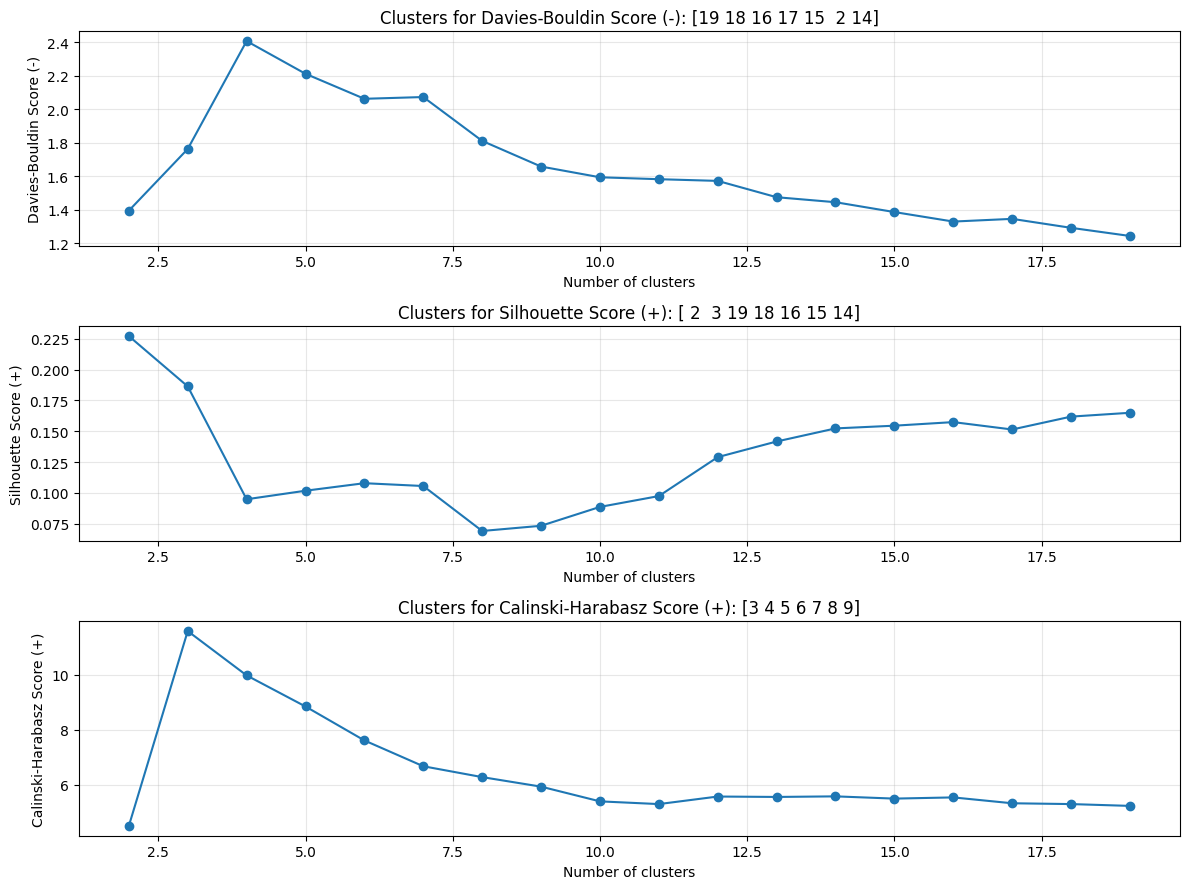

array([], dtype=int64)

In [113]:
graph_metrics("KMeans", word_embeds, 20)

Counter({1: 72, 0: 26, 2: 2})

╒═════════════════════════════╤══════════╕
│ Metric                      │    Value │
╞═════════════════════════════╪══════════╡
│ Calinski-Harabasz score (+) │ 11.59    │
├─────────────────────────────┼──────────┤
│ Davies-Bouldin score (-)    │  1.76163 │
├─────────────────────────────┼──────────┤
│ Silhouette score (+)        │  0.18643 │
╘═════════════════════════════╧══════════╛


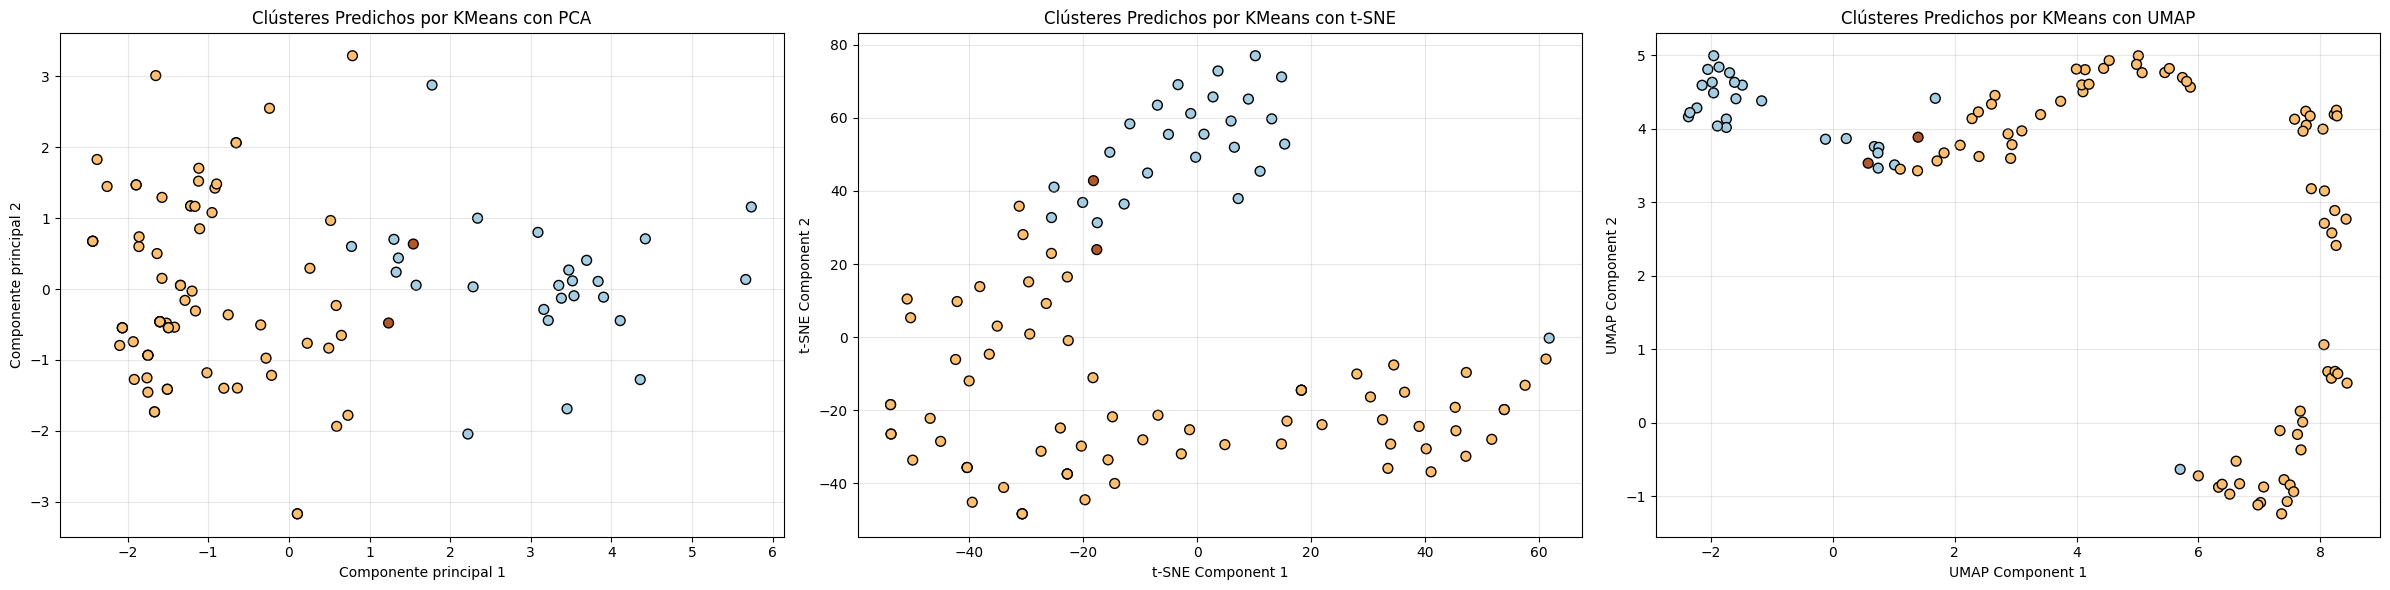

In [114]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init="auto")
kmeans_labels = kmeans.fit_predict(word_embeds)

kmeans_counts = Counter(kmeans_labels)
rprint(kmeans_counts)

metrics(kmeans_labels, word_embeds)
plot_clustering(word_embeds, kmeans_labels, "KMeans")

Entrenando con AgglomerativeClustering...


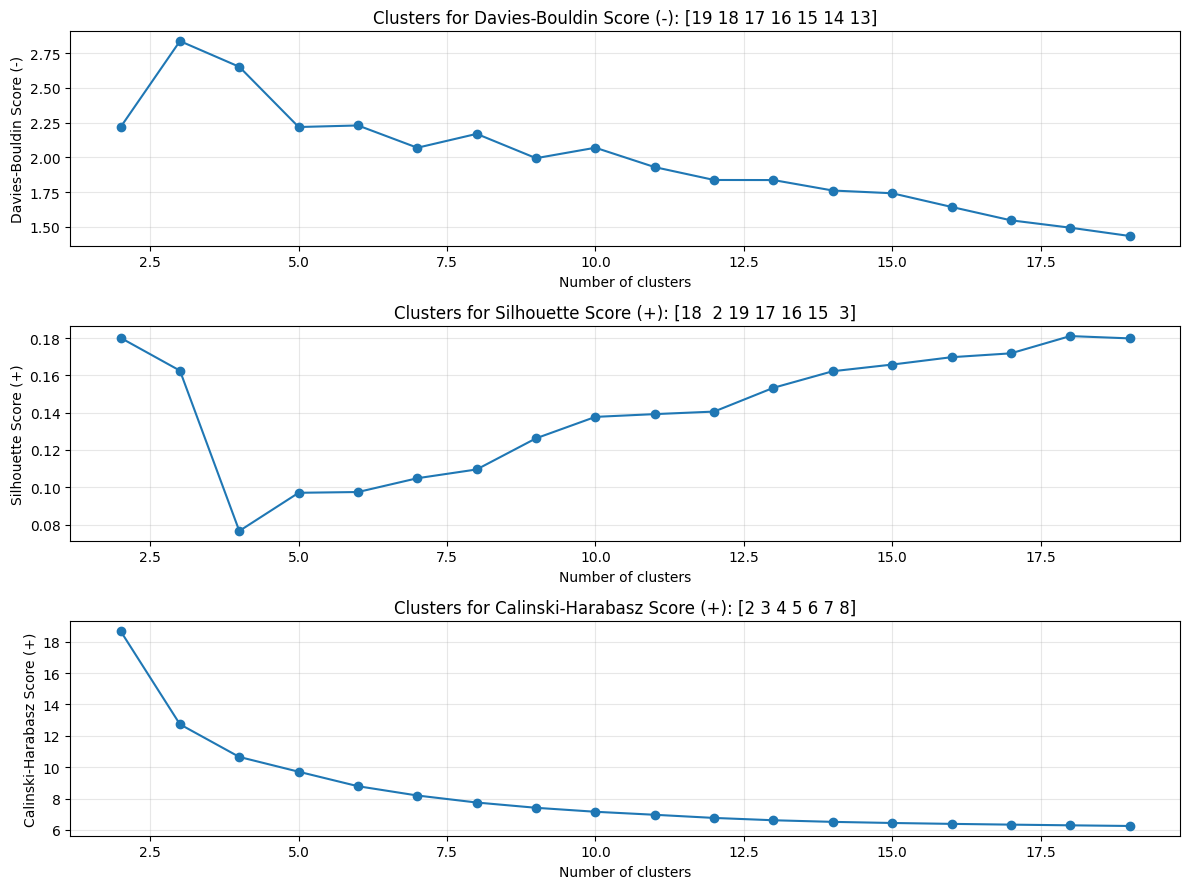

array([], dtype=int64)

In [115]:
graph_metrics("AgglomerativeClustering", word_embeds, 20)

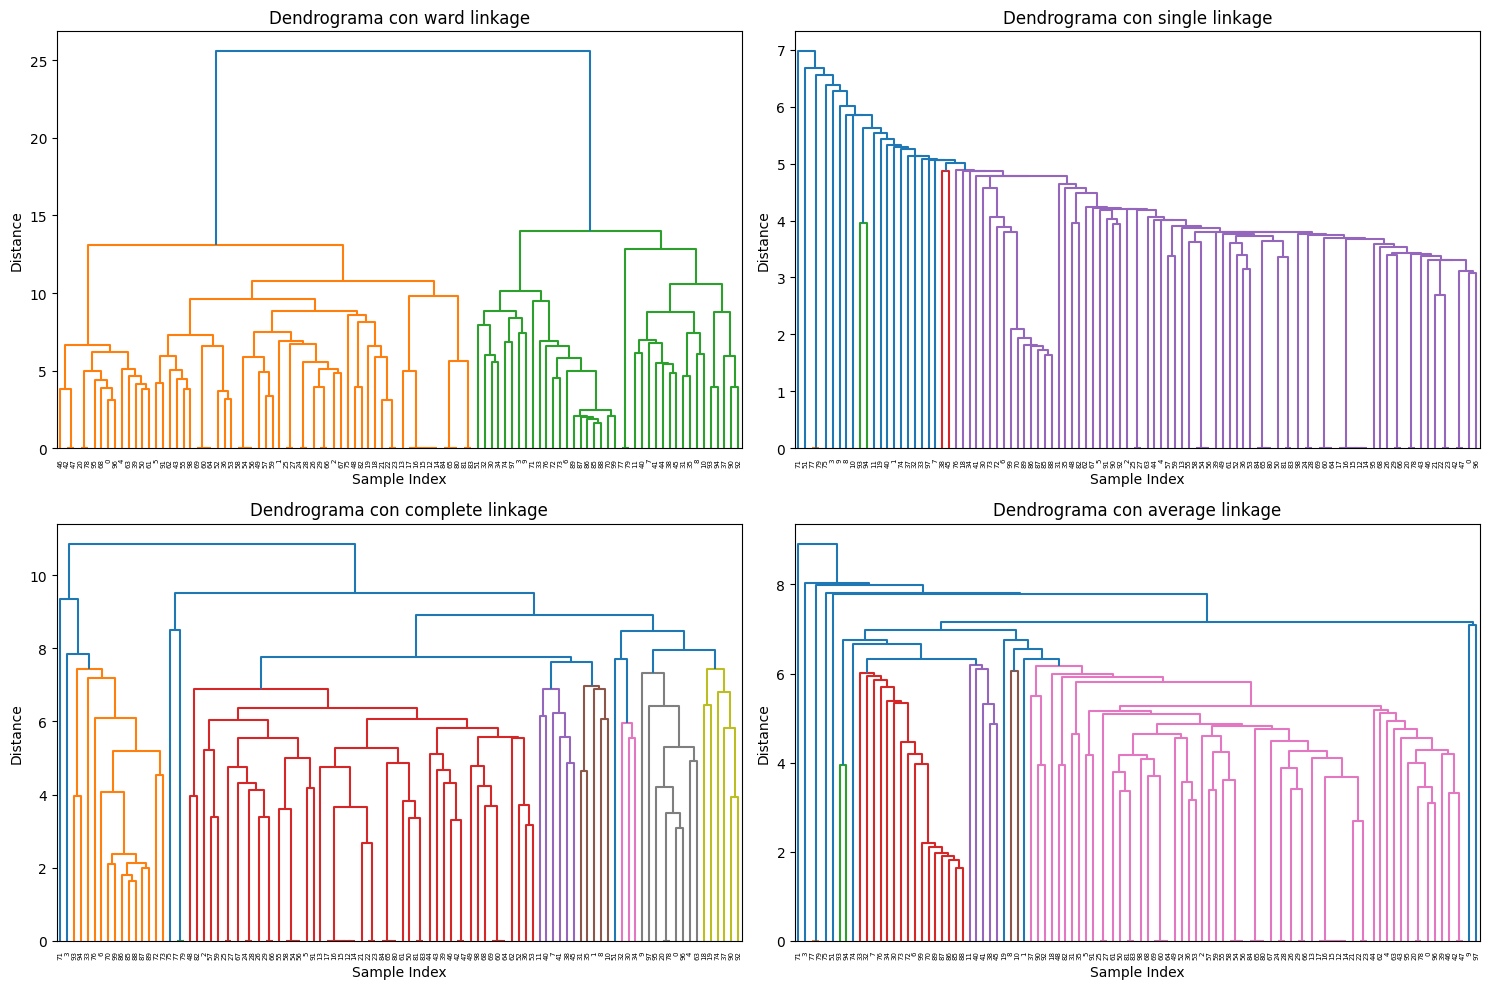

In [116]:
linkage_methods = ['ward', 'single', 'complete', 'average']

plt.figure(figsize=(15, 10))

for i, method in enumerate(linkage_methods):
    plt.subplot(2, 2, i + 1)
    plt.gcf().set_facecolor('white')
    linkage_matrix = linkage(word_embeds, method=method)
    dendrogram(linkage_matrix)
    plt.title(f'Dendrograma con {method} linkage')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()

Counter({1: 61, 0: 39})

╒═════════════════════════════╤══════════╕
│ Metric                      │    Value │
╞═════════════════════════════╪══════════╡
│ Calinski-Harabasz score (+) │ 18.68    │
├─────────────────────────────┼──────────┤
│ Davies-Bouldin score (-)    │  2.21792 │
├─────────────────────────────┼──────────┤
│ Silhouette score (+)        │  0.18015 │
╘═════════════════════════════╧══════════╛


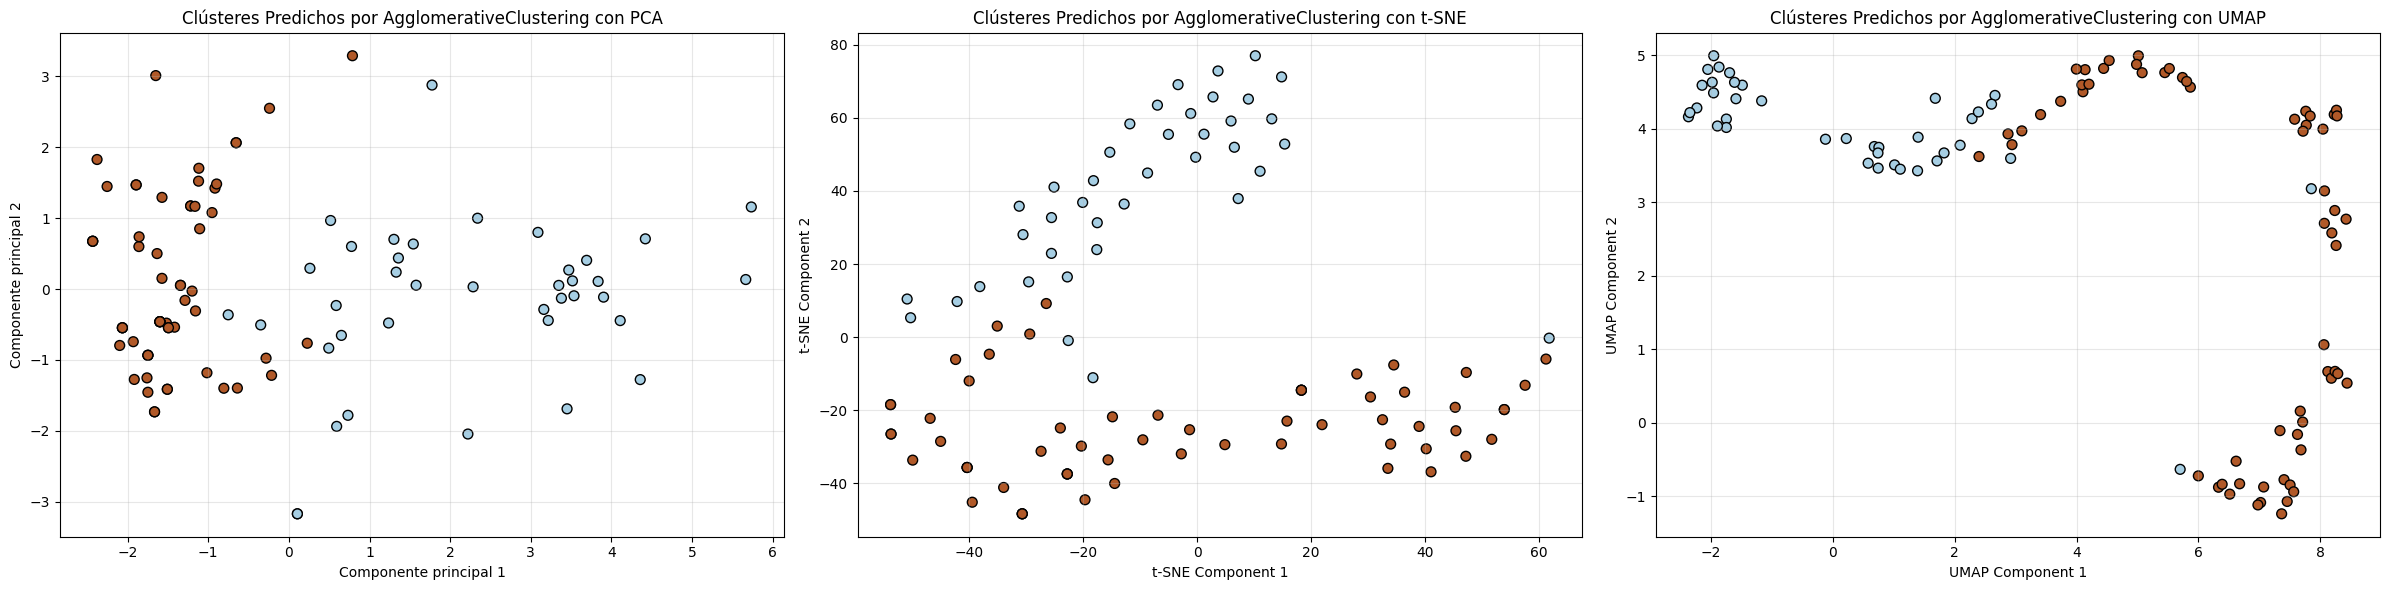

In [117]:
aglo = AgglomerativeClustering(n_clusters=2)
aglo_labels = aglo.fit_predict(word_embeds)

aglo_counts = Counter(aglo_labels)
rprint(aglo_counts)

metrics(aglo_labels, word_embeds)
plot_clustering(word_embeds, aglo_labels, "AgglomerativeClustering")

Entrenando con GaussianMixture...


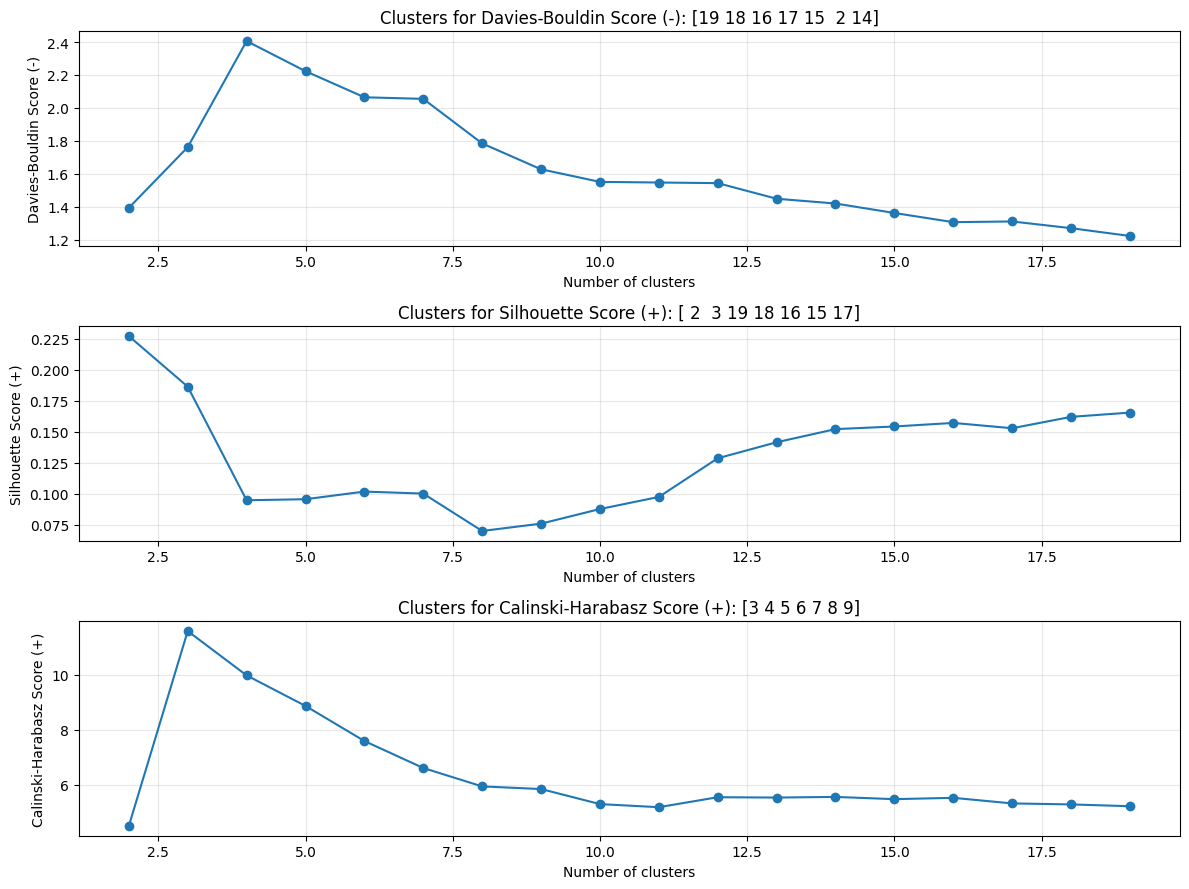

array([], dtype=int64)

In [118]:
graph_metrics("GaussianMixture", word_embeds, 20)

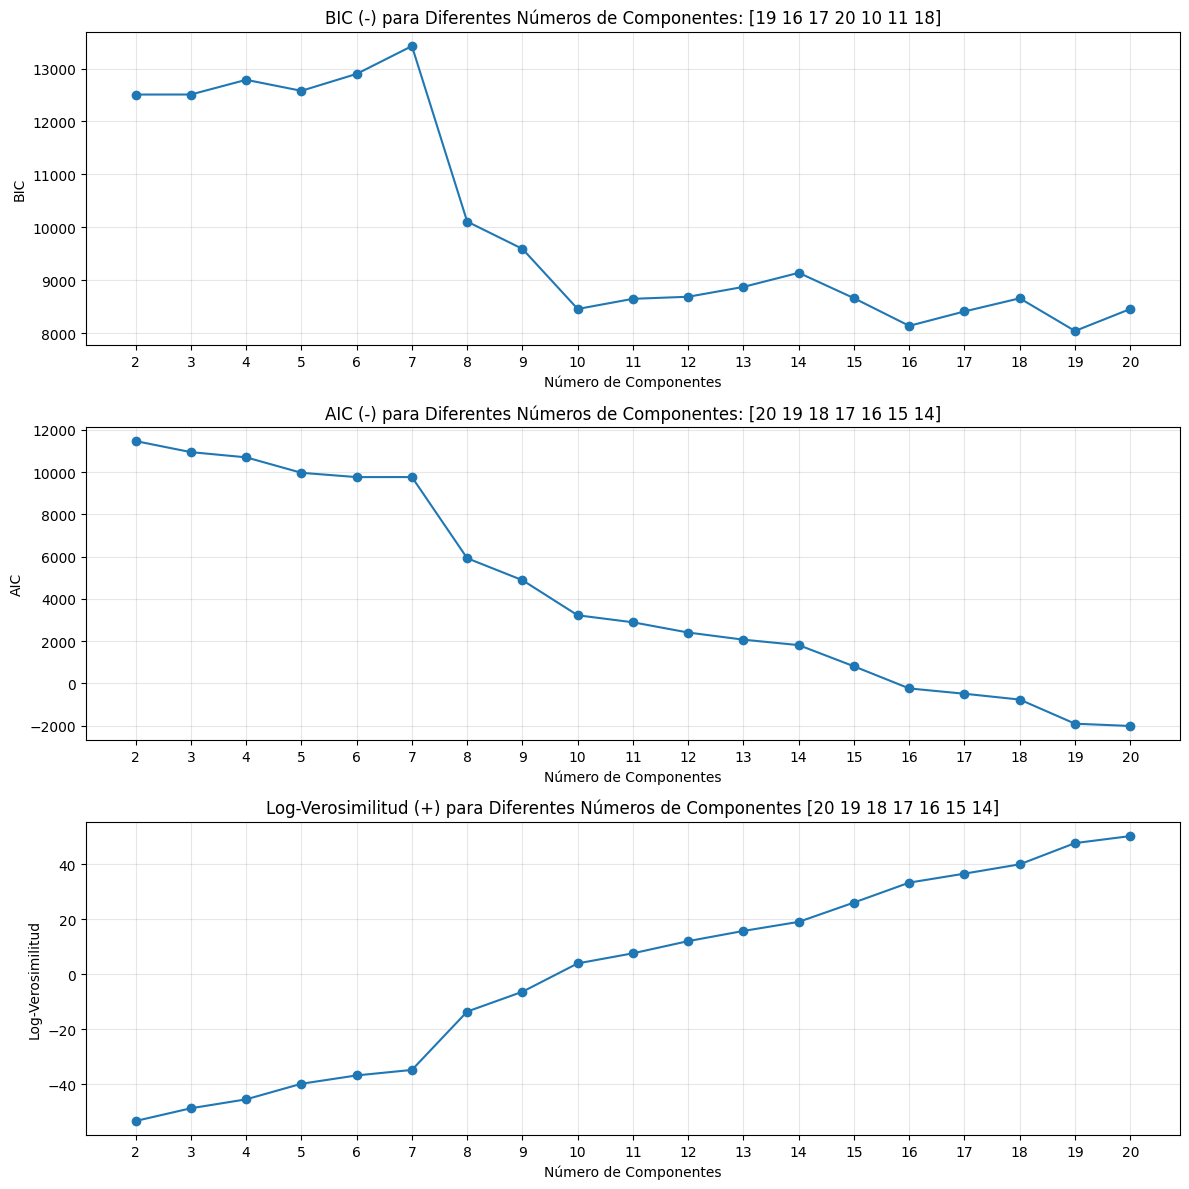

In [119]:
plot_gmm_metrics(word_embeds, 20)

Counter({1: 20, 4: 2, 14: 1, 9: 14, 0: 24, 6: 4, 11: 11, 5: 2, 7: 1, 10: 7, 3: 5, 15: 1, 8: 1, 2: 2, 12: 3, 13: 2})

╒═════════════════════════════╤═════════╕
│ Metric                      │   Value │
╞═════════════════════════════╪═════════╡
│ Calinski-Harabasz score (+) │ 5.53    │
├─────────────────────────────┼─────────┤
│ Davies-Bouldin score (-)    │ 1.30637 │
├─────────────────────────────┼─────────┤
│ Silhouette score (+)        │ 0.1572  │
╘═════════════════════════════╧═════════╛


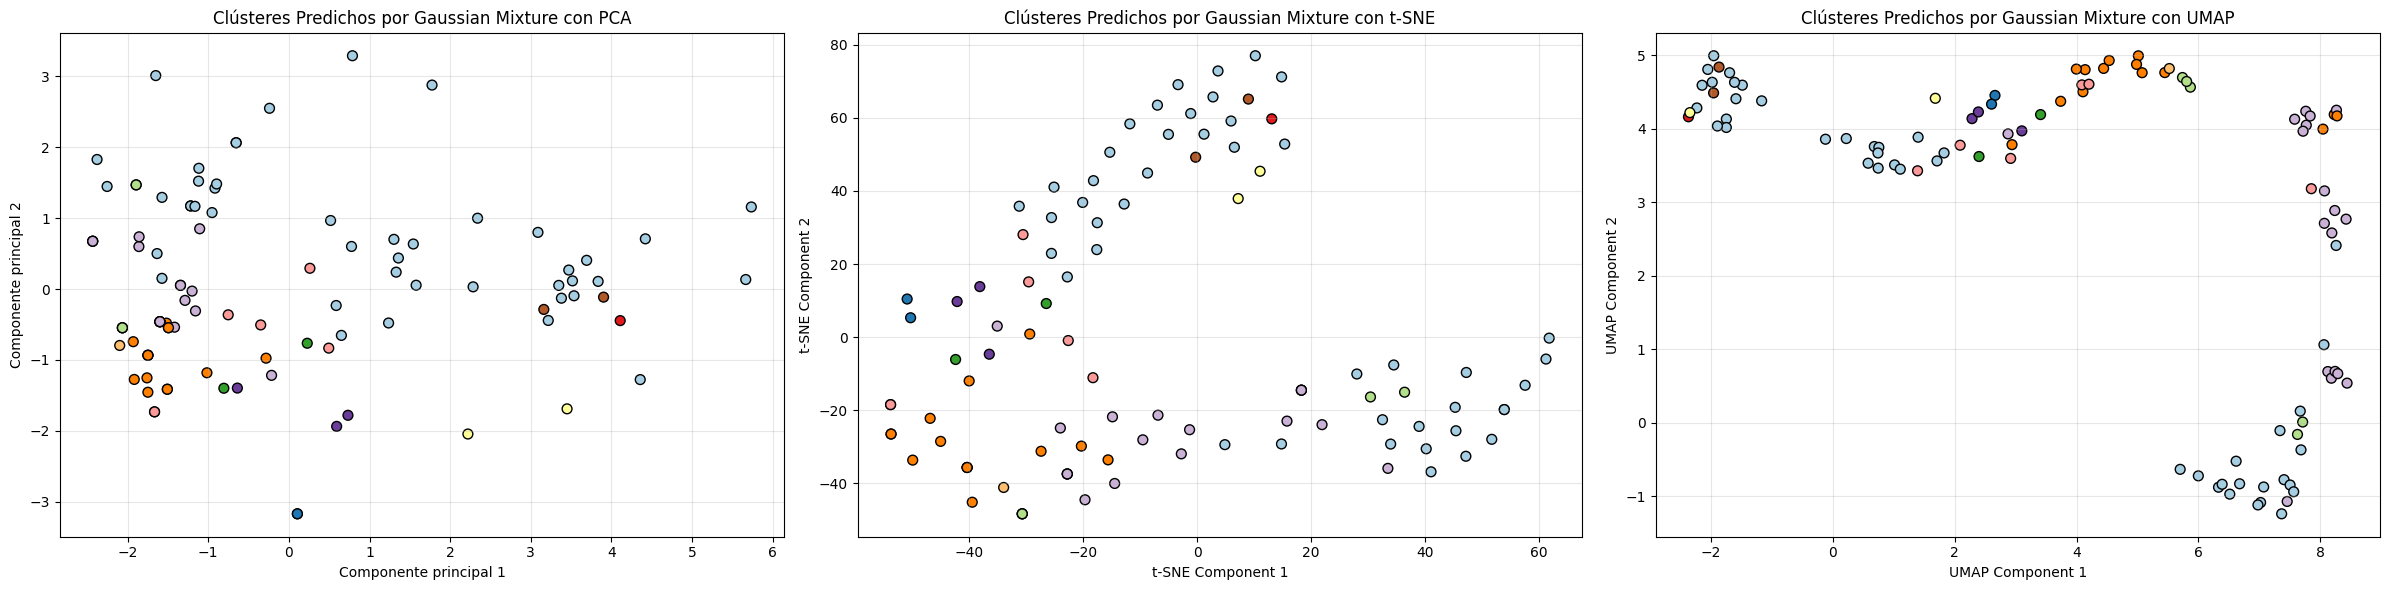

In [120]:
gaussian = GaussianMixture(n_components=16, random_state=RANDOM_STATE, covariance_type='diag')
gaussian_labels = gaussian.fit_predict(word_embeds)

gaussian_counts = Counter(gaussian_labels)
rprint(gaussian_counts)

metrics(gaussian_labels, word_embeds)
plot_clustering(word_embeds, gaussian_labels, "Gaussian Mixture")

Entrenando con HDBSCAN...


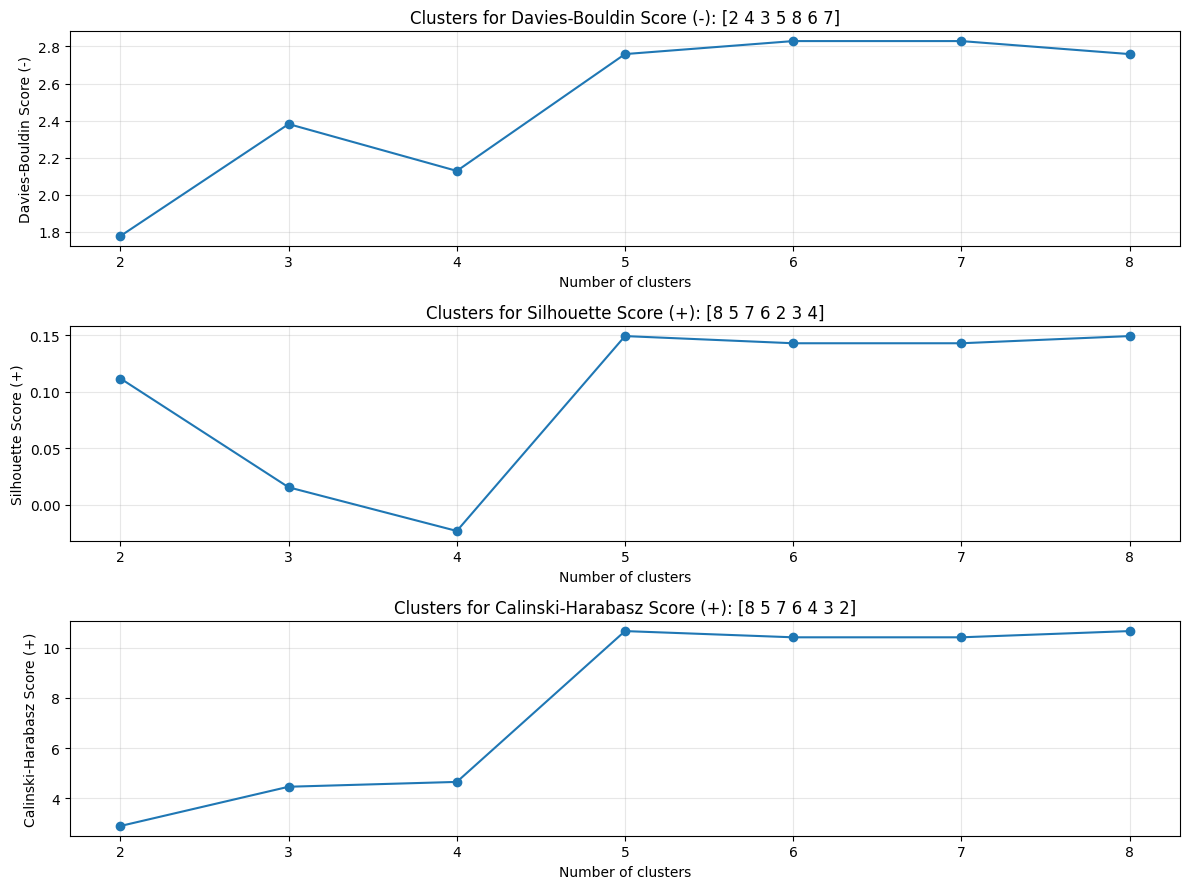

array([2, 3, 4, 5, 6, 7, 8])

In [121]:
graph_metrics("HDBSCAN", word_embeds, 20)

Counter({0: 55, -1: 35, 1: 10})

╒═════════════════════════════╤══════════╕
│ Metric                      │    Value │
╞═════════════════════════════╪══════════╡
│ Calinski-Harabasz score (+) │ 10.66    │
├─────────────────────────────┼──────────┤
│ Davies-Bouldin score (-)    │  2.7589  │
├─────────────────────────────┼──────────┤
│ Silhouette score (+)        │  0.14941 │
╘═════════════════════════════╧══════════╛


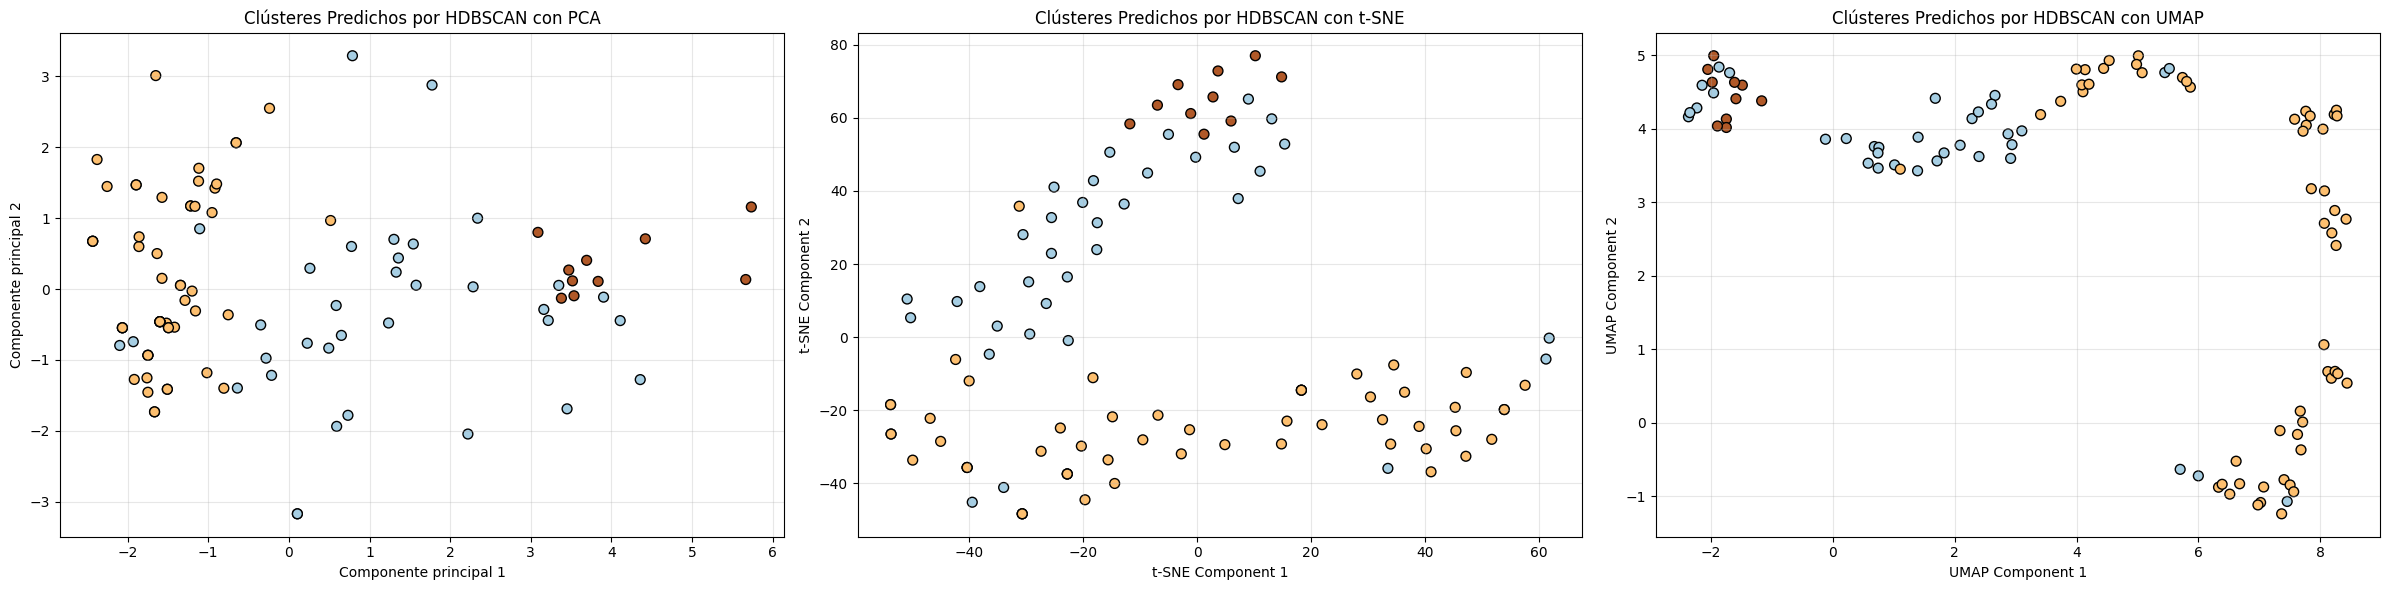

In [124]:
hdscan = hdbscan.HDBSCAN(min_cluster_size=5)
hdscan_labels = hdscan.fit_predict(word_embeds)

hdscan_counts = Counter(hdscan_labels)
rprint(hdscan_counts)

metrics(hdscan_labels, word_embeds)
plot_clustering(word_embeds, hdscan_labels, "HDBSCAN")

Entrenando con SpectralClustering...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``a

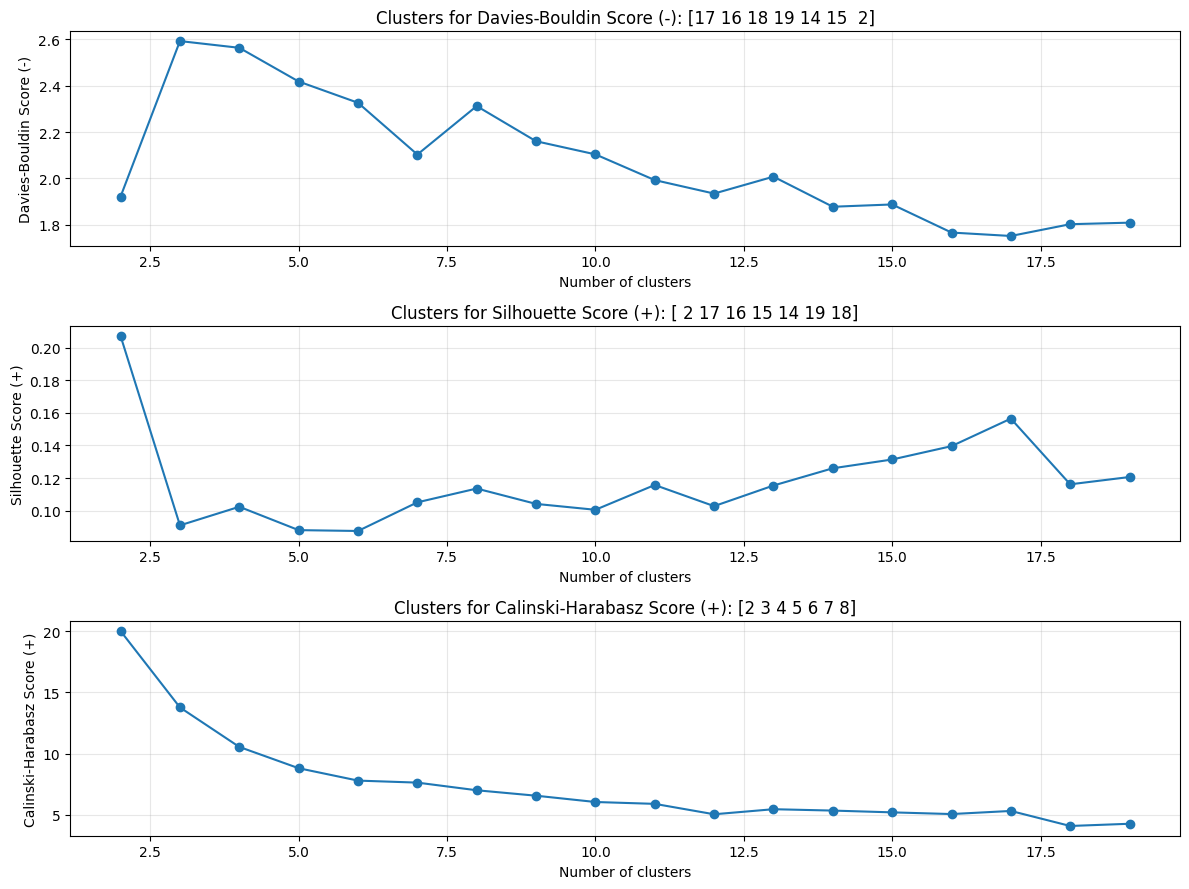

array([2])

In [125]:
graph_metrics("SpectralClustering", word_embeds, 20)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Counter({1: 73, 0: 27})

╒═════════════════════════════╤══════════╕
│ Metric                      │    Value │
╞═════════════════════════════╪══════════╡
│ Calinski-Harabasz score (+) │ 20       │
├─────────────────────────────┼──────────┤
│ Davies-Bouldin score (-)    │  1.92193 │
├─────────────────────────────┼──────────┤
│ Silhouette score (+)        │  0.20706 │
╘═════════════════════════════╧══════════╛


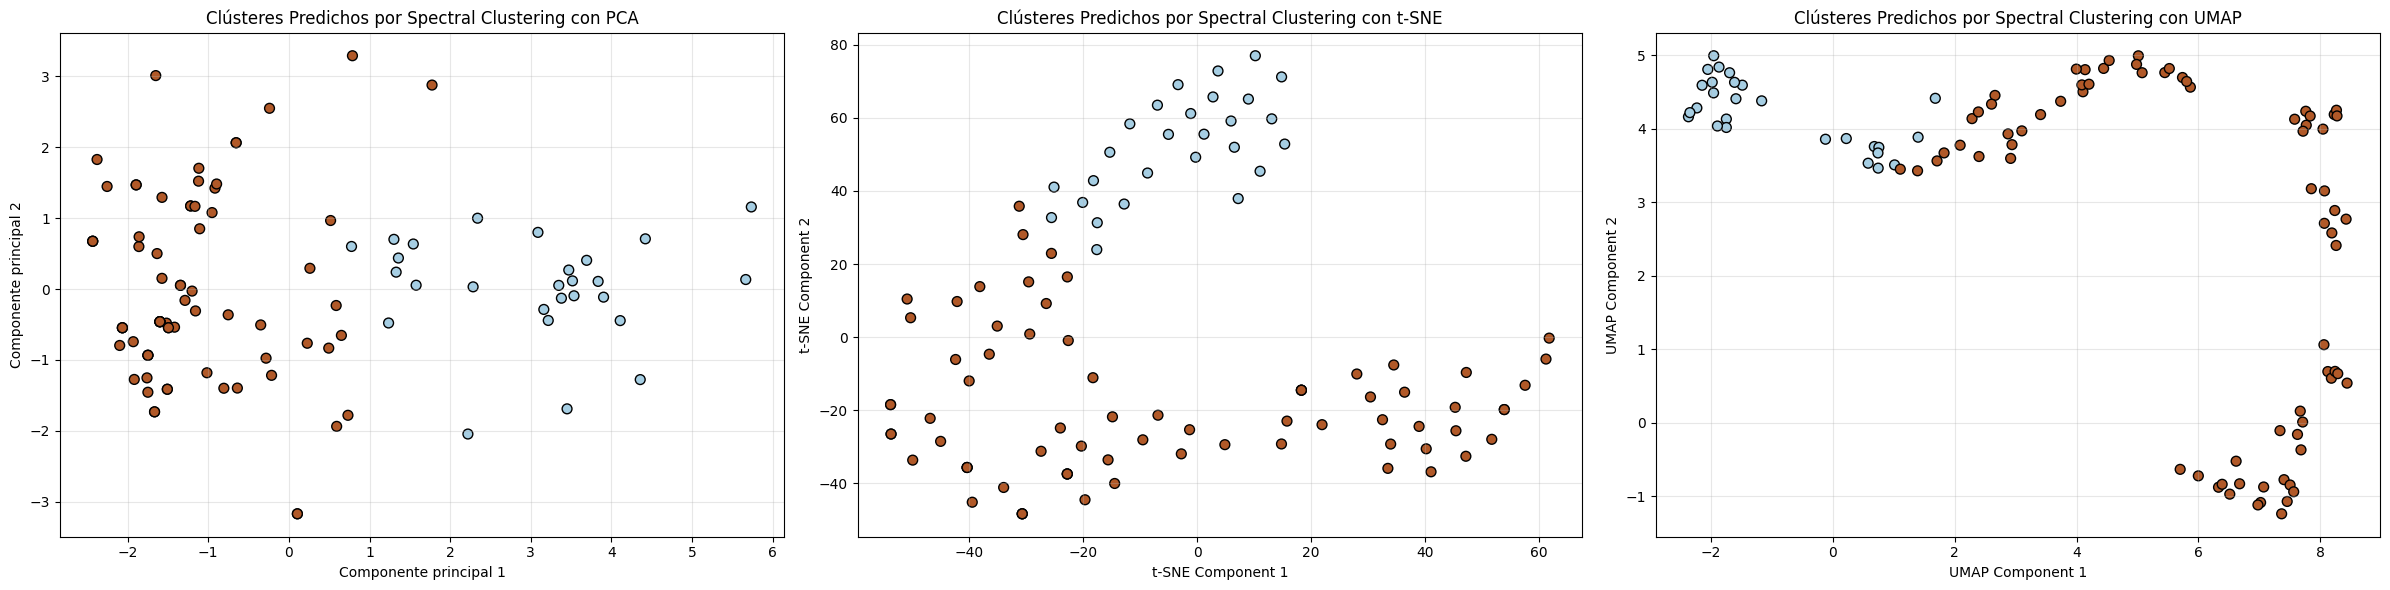

In [126]:
spectral = SpectralClustering(n_clusters=2, random_state=RANDOM_STATE, affinity="nearest_neighbors", n_neighbors=10)
spectral_labels = spectral.fit_predict(word_embeds)

spectral_counts = Counter(spectral_labels)
rprint(spectral_counts)

metrics(spectral_labels, word_embeds)
plot_clustering(word_embeds, spectral_labels, "Spectral Clustering")

Entrenando con OPTICS...


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


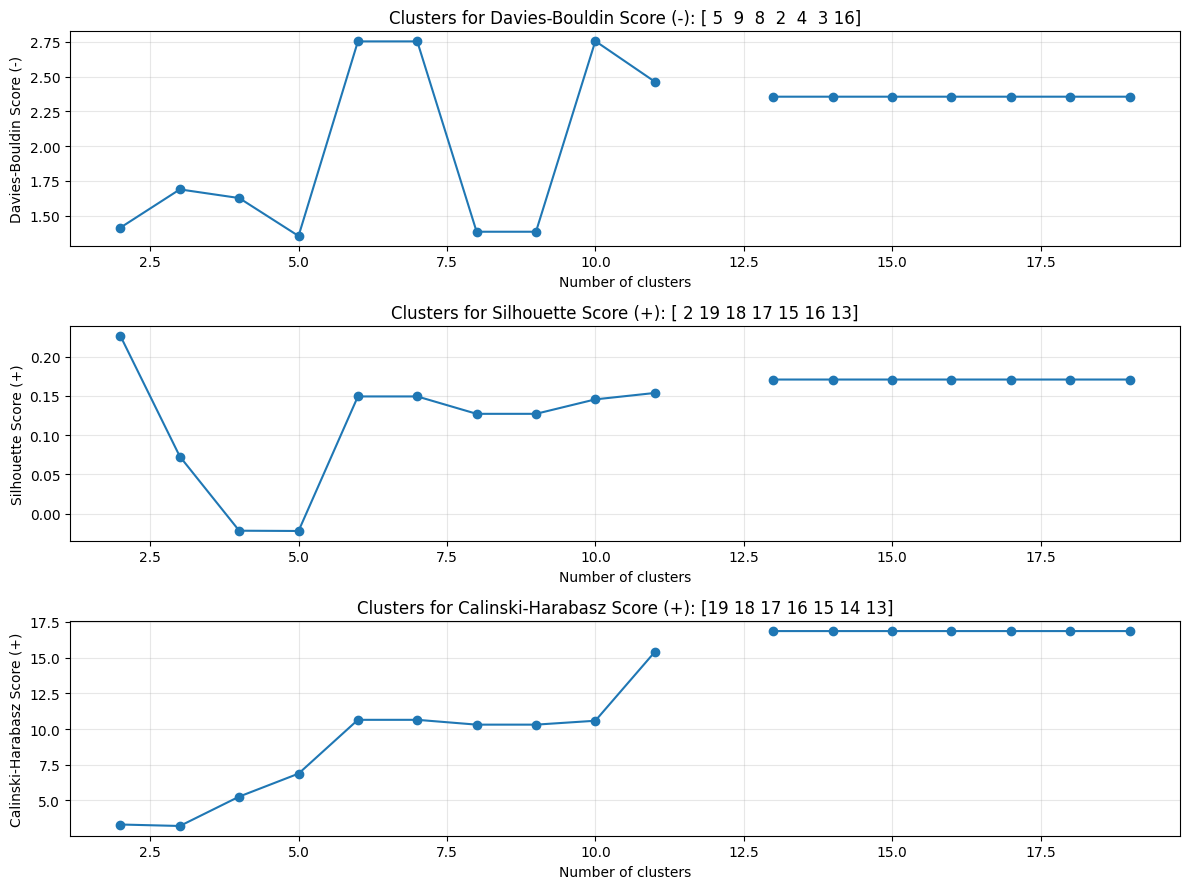

array([16])

In [127]:
graph_metrics("OPTICS", word_embeds, 20)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:932: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Counter({
    -1: 48,
    14: 10,
    4: 5,
    2: 2,
    1: 3,
    6: 2,
    12: 2,
    3: 2,
    9: 3,
    0: 2,
    13: 2,
    7: 3,
    10: 4,
    11: 2,
    5: 3,
    8: 3,
    16: 2,
    15: 2
})

╒═════════════════════════════╤═════════╕
│ Metric                      │   Value │
╞═════════════════════════════╪═════════╡
│ Calinski-Harabasz score (+) │ 3.32    │
├─────────────────────────────┼─────────┤
│ Davies-Bouldin score (-)    │ 1.41457 │
├─────────────────────────────┼─────────┤
│ Silhouette score (+)        │ 0.22629 │
╘═════════════════════════════╧═════════╛


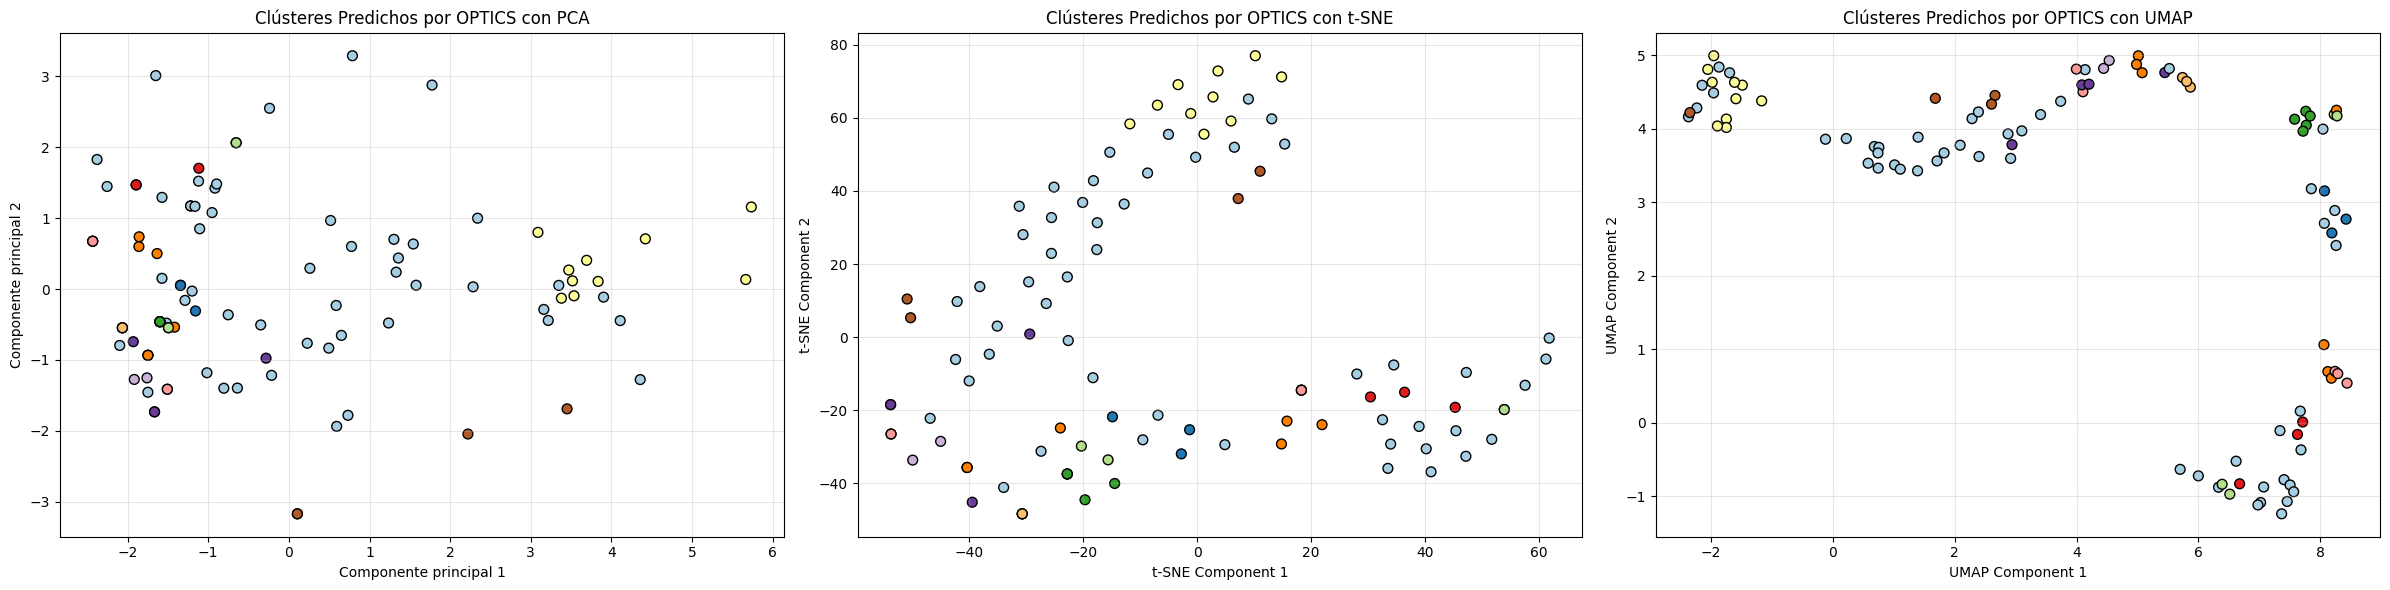

In [136]:
optics = OPTICS(min_samples=2)
optics_labels = optics.fit_predict(word_embeds)

optics_counts = Counter(optics_labels)
rprint(optics_counts)

metrics(optics_labels, word_embeds)
plot_clustering(word_embeds, optics_labels, "OPTICS")

Entrenando con DBSCAN...


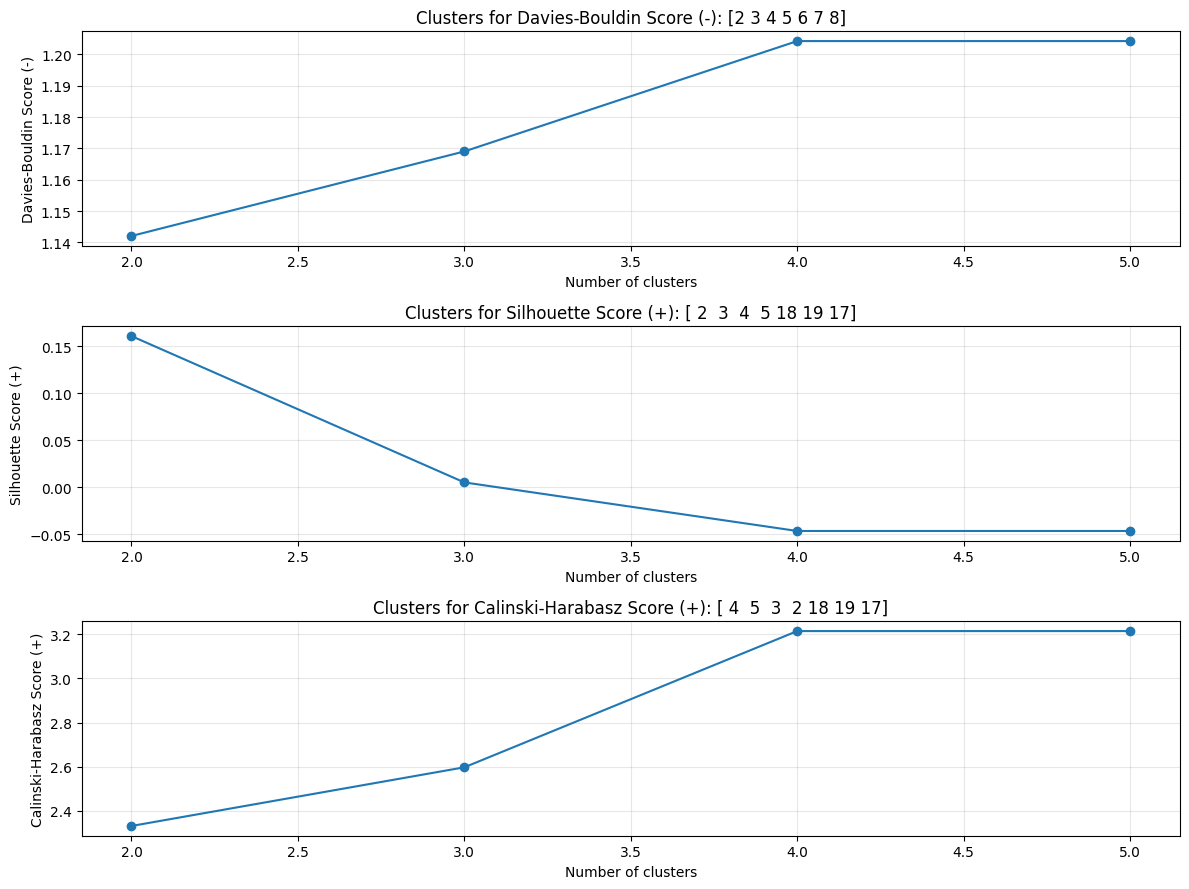

array([2, 3, 4, 5])

In [134]:
graph_metrics("DBSCAN", word_embeds, 20)

Counter({-1: 70, 0: 5, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 3, 8: 3, 9: 3, 10: 2, 11: 2})

╒═════════════════════════════╤═════════╕
│ Metric                      │   Value │
╞═════════════════════════════╪═════════╡
│ Calinski-Harabasz score (+) │ 2.33    │
├─────────────────────────────┼─────────┤
│ Davies-Bouldin score (-)    │ 1.14206 │
├─────────────────────────────┼─────────┤
│ Silhouette score (+)        │ 0.16097 │
╘═════════════════════════════╧═════════╛


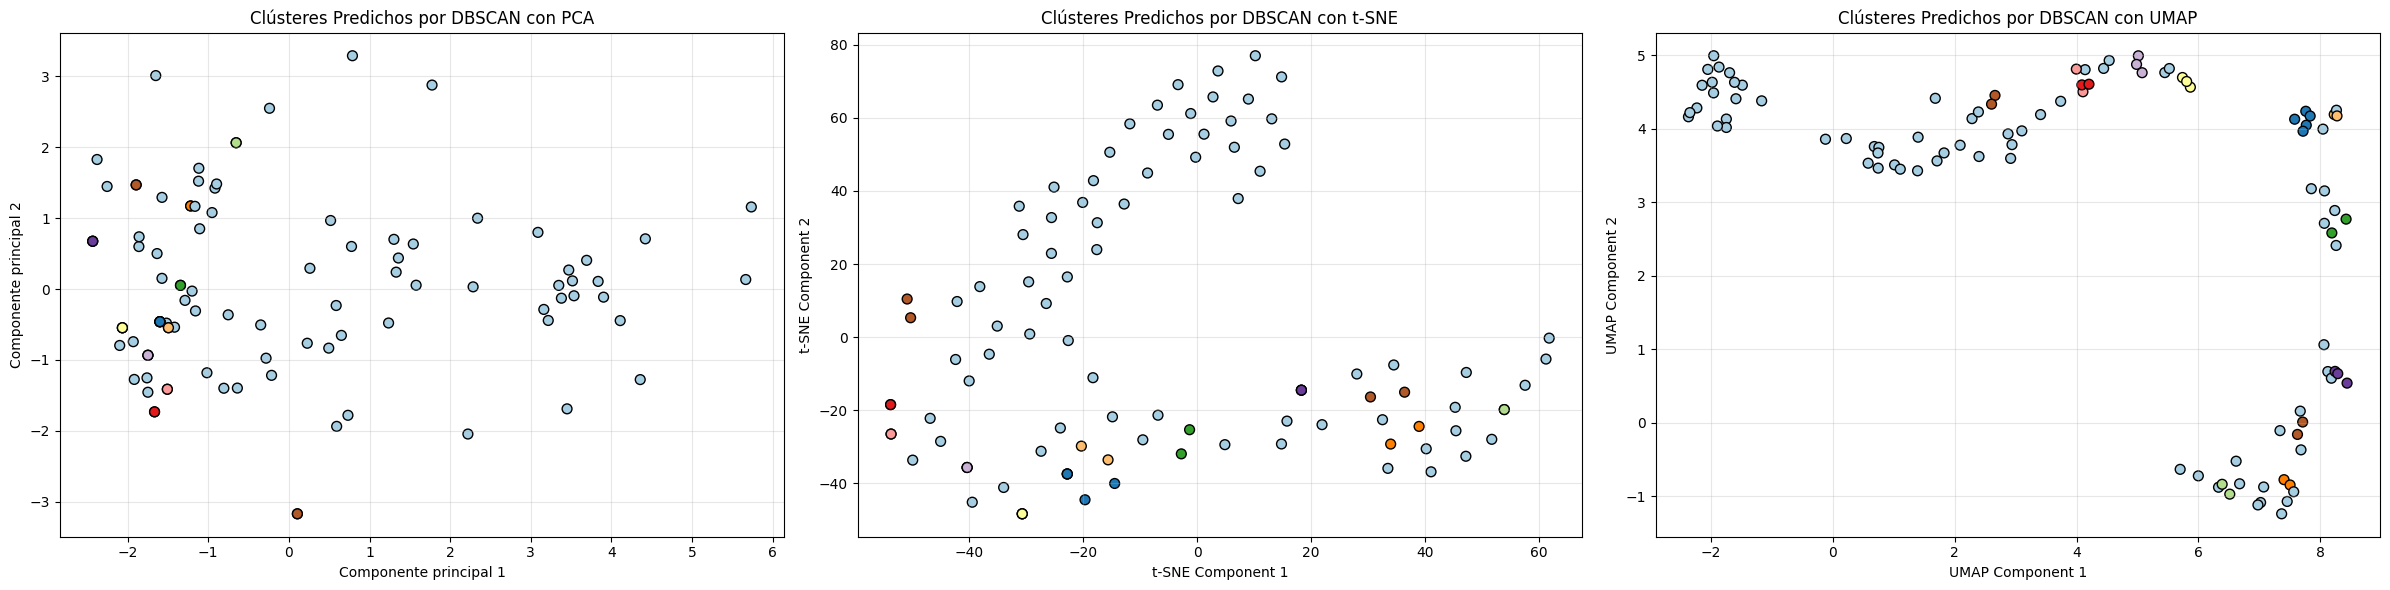

In [135]:
dbscan = DBSCAN(min_samples=2)
dbscan_labels = dbscan.fit_predict(word_embeds)

dbscan_counts = Counter(dbscan_labels)
rprint(dbscan_counts)

metrics(dbscan_labels, word_embeds)
plot_clustering(word_embeds, dbscan_labels, "DBSCAN")

El modelo Spectral Clustering con $k=2$ emerge como la opción óptima para la tarea de clustering basado en embeddings y etiquetas POS. Este método presenta un equilibrio destacado entre métricas de evaluación, con un Silhouette Score de 0.207 (mayor cohesión intra-cluster), Calinski-Harabasz de 20.0 (mejor separación global) y Davies-Bouldin de 1.92 (balance entre compactación y distancia inter-cluster).

La distribución resultante (73% vs 27%) sugiere una partición semántico-sintáctica coherente, donde el cluster mayoritario podría corresponder a categorías dominantes (e.g. sustantivos) y el minoritario a grupos secundarios (e.g. verbos + adjetivos). Esta estructura se alinea con patrones lingüísticos típicos en corpus equilibrados.

Su ventaja crítica radica en la capacidad de capturar relaciones no lineales en espacios de alta dimensionalidad, característica esencial para embeddings de NLP. A diferencia de métodos rígidos como K-Means o Agglomerative, Spectral Clustering preserva mejor la estructura semántica subyacente mediante afinidades basadas en similitud coseno, ofreciendo clusters más interpretables para análisis POS.

## ***Ejercicio 3***
- Agrega al plot los embeddings de las etiquetas POS
  - Utiliza un marcador que las distinga claramente de las palabras


### ***POS tagging embeddings***

In [137]:
# —————————————————————————————————————————————
# 4) Calcular centroides de POS usando el mismo muestreo balanceado
# —————————————————————————————————————————————
# Reutilizamos sampled_words/tags para agrupar embeddings por POS
pos_to_embs = defaultdict(list)
for w, pos in zip(sampled_words, sampled_tags):
    idx = word2idx[w]
    emb = rnn_model.embedding.weight[int(idx)].detach().cpu().numpy()
    pos_to_embs[pos].append(emb)

# Ahora calculamos un centroide por POS
pos_tags_list = list(pos_to_embs.keys())
pos_centroids = {
    pos: np.mean(pos_to_embs[pos], axis=0)
    for pos in pos_tags_list
}
pos_embeds = np.stack([pos_centroids[pos] for pos in pos_tags_list])  # shape (n_pos, D)

# —————————————————————————————————————————————
# 5) Concatenar embeddings de palabras y centroides de POS
# —————————————————————————————————————————————
combined = np.concatenate([word_embeds, pos_embeds], axis=0)  # shape (100 + n_pos, D)

# —————————————————————————————————————————————
# 6) Preparar colores y marcadores
# —————————————————————————————————————————————
unique_word_tags = sorted(set(word_tags))
cmap = plt.colormaps.get_cmap('tab20')
tag2color = {tag: cmap(i) for i, tag in enumerate(unique_word_tags)}

# Colores para palabras
word_colors = [tag2color[tag] for tag in word_tags]

# Color único para centroides
centroid_color = 'red'

In [138]:
# —————————————————————————————————————————————
# 7a) Proyección con PCA
# —————————————————————————————————————————————
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca_emb2d = pca.fit_transform(combined)  # shape (100 + n_pos, 2)

# Separa coordenadas
pca_word_2d = pca_emb2d[: len(word_embeds)]         # (100, 2)
pca_pos_2d  = pca_emb2d[len(word_embeds): ]         # (n_pos, 2)


# —————————————————————————————————————————————
# 7b) Proyección con t-SNE
# —————————————————————————————————————————————
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=15)
tsne_emb2d = tsne.fit_transform(combined)  # shape (100 + n_pos, 2)

# Separa coordenadas
tsne_word_2d = tsne_emb2d[: len(word_embeds)]         # (100, 2)
tsne_pos_2d  = tsne_emb2d[len(word_embeds): ]         # (n_pos, 2)


# —————————————————————————————————————————————
# 7c) Proyección con UMAP
# —————————————————————————————————————————————
umap = UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=19, n_jobs=1)
umap_emb2d = umap.fit_transform(combined)  # shape (100 + n_pos, 2)

# Separa coordenadas
umap_word_2d = umap_emb2d[: len(word_embeds)]         # (100, 2)
umap_pos_2d  = umap_emb2d[len(word_embeds): ]         # (n_pos, 2)

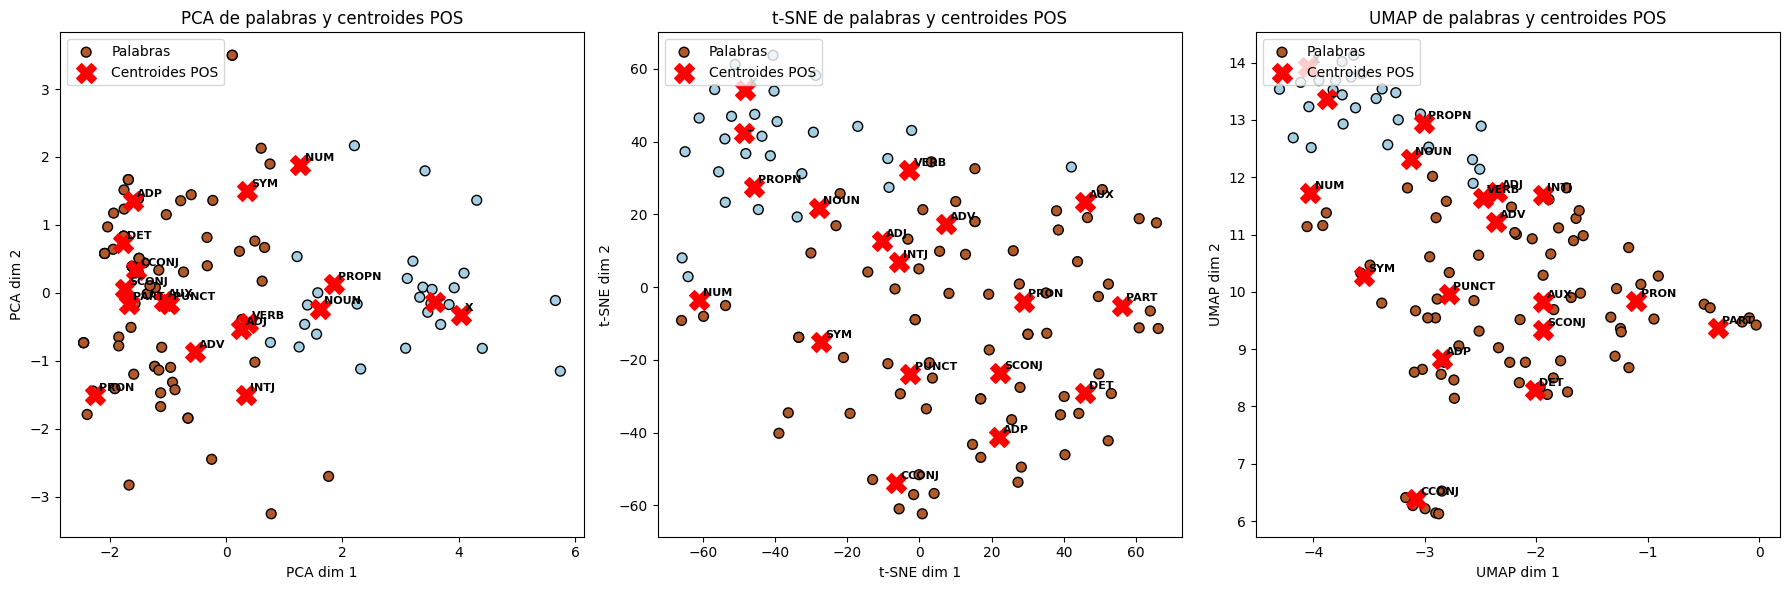

In [139]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

projections = [
    ("PCA", pca_word_2d, pca_pos_2d),
    ("t-SNE", tsne_word_2d, tsne_pos_2d),
    ("UMAP", umap_word_2d, umap_pos_2d),
]

for ax, (name, word_2d, pos_2d) in zip(axes, projections):
    # a) Palabras
    ax.scatter(
        word_2d[:, 0], word_2d[:, 1],
        c=spectral_labels,        # Los labels de la mejor clusterización 
        cmap='Paired',
        marker='o',
        edgecolor='k',
        s=50,
        label='Palabras'
    )
    # b) Centroides POS
    ax.scatter(
        pos_2d[:, 0], pos_2d[:, 1],
        c='red',
        marker='X',
        s=200,
        label='Centroides POS'
    )
    # Anotar centroides
    for i, pos in enumerate(pos_tags_list):
        x, y = pos_2d[i]
        ax.annotate(
            pos, (x, y),
            fontsize=8, fontweight='bold',
            xytext=(3, 3), textcoords='offset points'
        )
    ax.set_title(f"{name} de palabras y centroides POS")
    ax.set_xlabel(f"{name} dim 1")
    ax.set_ylabel(f"{name} dim 2")
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()



## ***Ejercicio 4***
- Realiza una conclusión sobre los resultados observados


### ***Conclusión***

La proyección no lineal de embeddings mediante t-SNE y UMAP valida numérica y visualmente la efectividad de Spectral Clustering (*k* = 2) para identificar una partición robusta en el espacio sintáctico-semántico. Mientras PCA, al priorizar varianza global, no logra separar claramente las clases, t-SNE y UMAP revelan dos clusters cohesivos centrados en los centroides POS, confirmando que la estructura subyacente en los embeddings refleja patrones lingüísticos jerárquicos. La proximidad de categorías relacionadas (e.g., *ADP-DET* o *AUX-VERB*) en UMAP sugiere que el modelo captura gradientes sintácticos, no meras agrupaciones discretas. Estos resultados respaldan el uso de Spectral Clustering para análisis POS, priorizando su capacidad para modelar relaciones no lineales en espacios de alta dimensión, complementado con técnicas de reducción dimensional que preservan estructura local (*t-SNE*) o global-local (*UMAP*).

## Extra: 0.5pt

- Implementa una red *Long short-term memory units (LSTM)* para la tarea de etiquetado POS
- Reporta el accuracy y comparalo con los resultados de la RNN simple
- Realiza un comentario sobre como impacta la arquitectura LSTM sobre el resultado obtenido

### ***RNN LSTM***

In [140]:
class LstmModel(nn.Module):
    """Modelo LSTM para clasificación de secuencias con embeddings pre-entrenados.

    :param embedding_table: Tensor de embeddings pre-entrenados
    :type embedding_table: torch.Tensor
    :param hidden_size: Dimensión de los estados ocultos
    :type hidden_size: int
    :param num_classes: Número de clases de salida
    :type num_classes: int
    :param freeze_embeddings: Congela los embeddings durante el entrenamiento
    :type freeze_embeddings: bool, opcional
    :param num_layers: Número de capas LSTM apiladas
    :type num_layers: int, opcional
    :param bidirectional: Habilita LSTM bidireccional
    :type bidirectional: bool, opcional
    :param dropout_rate: Tasa de dropout aplicada entre capas
    :type dropout_rate: float, opcional
    
    :ivar embedding: Capa de embeddings pre-entrenados
    :vartype embedding: nn.Embedding
    :ivar lstm: Capa LSTM con dropout configurable
    :vartype lstm: nn.LSTM
    :ivar dropout: Capa de dropout antes de la salida lineal
    :vartype dropout: nn.Dropout
    :ivar linear: Capa lineal final para clasificación
    :vartype linear: nn.Linear
    """
    def __init__(self,
                 embedding_table,
                 hidden_size,
                 num_classes: int,
                 freeze_embeddings: bool = False,
                 num_layers: int=1,
                 bidirectional=False,
                 dropout_rate=0.3):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings,
            padding_idx=0
            )
        self.lstm = nn.LSTM( # Cambio clave: nn.RNN -> nn.LSTM
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0 # Dropout entre capas LSTM si hay más de 1
            )
        
        # El tamaño de la salida lineal depende de si es bidireccional
        linear_input_size = hidden_size * 2 if bidirectional else hidden_size
        self.dropout = nn.Dropout(dropout_rate) # Dropout antes de la capa lineal
        self.linear = nn.Linear(linear_input_size, num_classes)

    def forward(self, sentence):
        """Procesa un lote de secuencias a través del modelo.
        
        :param sentence: Tensor de entrada con forma (batch_size, seq_len)
        :type sentence: torch.Tensor
        :return: Logits de clasificación con forma (batch_size, seq_len, num_classes)
        :rtype: torch.Tensor
        """
        embeds = self.embedding(sentence)
        
        # LSTM devuelve: output, (hidden_state, cell_state)
        lstm_out, _ = self.lstm(embeds)
        
        # Aplicar dropout a la salida de LSTM
        lstm_out = self.dropout(lstm_out)
        
        # Pasar la salida de cada paso de tiempo por la capa lineal
        logits = self.linear(lstm_out)
        return logits

In [151]:
HIDDEN_SIZE = 128
NUM_LAYERS = 2
BIDIRECTIONAL = True
FREEZE_EMBEDDINGS = False
NUM_CLASSES = len(pos2idx) + 1 # +1 por el padding_idx=0
LR_LSTM = 0.005 # Misma tasa de aprendizaje
EPOCHS_LSTM = 10 # Mismas épocas
DROPOUT_RATE = 0.2 # Dropout añadido para regularización

# Mover modelo a GPU si está disponible (asegúrate que 'device' esté definido)
device = "cuda" if torch.cuda.is_available() else "cpu"
rprint(f"\nEntrenando LSTM en: [bold {('green' if device == 'cuda' else 'yellow')}]{device}[/]")


lstm_model = LstmModel(
    embedding_table=embedding_table, # Usar la misma tabla de embeddings
    hidden_size=HIDDEN_SIZE,
    num_classes=NUM_CLASSES,
    freeze_embeddings=FREEZE_EMBEDDINGS,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout_rate=DROPOUT_RATE
).to(device)

Entrenando LSTM en: cuda

In [152]:
# Usar la misma función de pérdida (ignorando el padding)
loss_fn_lstm = nn.CrossEntropyLoss(ignore_index=0)
optimizer_lstm = torch.optim.NAdam(lstm_model.parameters(), lr=LR_LSTM)

In [153]:
rprint("\n[bold magenta]Entrenando el modelo LSTM...[/bold magenta]")

lstm_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}

# Mover la tabla de embeddings al dispositivo correcto también, si es necesario
# (Aunque from_pretrained debería manejarlo si el modelo está en el dispositivo correcto)
# embedding_table = embedding_table.to(device) # Descomentar si da error de dispositivo

for epoch in trange(EPOCHS_LSTM, desc="Epochs LSTM"):
    train_loss, train_acc, t_words = 0, 0, 0
    lstm_model.train() # Poner en modo entrenamiento (activa dropout)
    
    progress_bar = tqdm(train_dataloader_rnn, desc=f"Training Epoch {epoch+1}/{EPOCHS_LSTM}", leave=False)
    for X_batch, y_batch in progress_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        y_batch_pred = lstm_model(X_batch)
        
        # Calcular loss (aplanando las dimensiones de secuencia y batch)
        loss = loss_fn_lstm(
            y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)), # [batch*seq_len, num_classes]
            y_batch.reshape(-1)                                  # [batch*seq_len]
            )
        
        # Backward pass y optimización
        optimizer_lstm.zero_grad()
        loss.backward()
        # Optional: Gradient Clipping (ayuda a estabilizar entrenamiento de RNN/LSTM)
        # torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        optimizer_lstm.step()
        
        # Calcular métricas (ignorando padding)
        with torch.no_grad():
            n_words = torch.sum(y_batch > 0).item() # Contar palabras reales (no padding)
            t_words += n_words
            train_loss += n_words * loss.item() # Ponderar loss por número de palabras reales
            # Calcular aciertos solo en palabras reales
            correct_preds = torch.sum(
                torch.mul( # Multiplicación elemento a elemento
                    torch.argmax(y_batch_pred, dim=-1) == y_batch, # Coincidencias
                    y_batch > 0 # Máscara para ignorar padding
                )
            ).item()
            train_acc += correct_preds
            
            # Actualizar barra de progreso
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc_batch': f"{(correct_preds / n_words if n_words > 0 else 0):.4f}"
            })


    # Calcular métricas promedio de la época
    epoch_train_acc = train_acc / t_words if t_words > 0 else 0
    epoch_train_loss = train_loss / t_words if t_words > 0 else 0
    lstm_history["accuracy"].append(epoch_train_acc)
    lstm_history["loss"].append(epoch_train_loss)
    
    # Evaluar en conjunto de validación
    # Podemos reutilizar la función evaluate_rnn porque espera la misma estructura de salida
    val_loss, val_acc = evaluate_rnn(lstm_model, loss_fn_lstm, val_dataloader_rnn)
    lstm_history["val_loss"].append(val_loss)
    lstm_history["val_accuracy"].append(val_acc)
    
    rprint(f"Epoch {epoch+1}/{EPOCHS_LSTM} - "
           f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.2f}% - "
           f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

    # Guardado condicional
    if best_val_acc < val_acc:
        best_lstm_dict = lstm_model.state_dict()
        path_lstm: str = f"pos_tagger_lstm_best_{device}_{epoch}.pth"

        best_val_acc = val_acc
    
    # Guardar solo último modelo para continuar entrenamiento
    torch.save({
        'epoch': epoch,
        'model_state_dict': lstm_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': lstm_history
    }, "pos_tagger_lstm_last_checkpoint.pth")

# Guardar historial final
torch.save(best_lstm_dict, path_lstm)
torch.save(lstm_history, "pos_tagger_lstm.history")

Entrenando el modelo LSTM...

Epochs LSTM:   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 1/10:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 2.1232, Train Acc: 33.13% - Val Loss: 1.0000, Val Acc: 70.64%

Training Epoch 2/10:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.6362, Train Acc: 81.13% - Val Loss: 1.0000, Val Acc: 87.73%

Training Epoch 3/10:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.2434, Train Acc: 92.82% - Val Loss: 1.0000, Val Acc: 94.33%

Training Epoch 4/10:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.1398, Train Acc: 95.90% - Val Loss: 1.0000, Val Acc: 94.92%

Training Epoch 5/10:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.1056, Train Acc: 96.82% - Val Loss: 1.0000, Val Acc: 95.31%

Training Epoch 6/10:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.0791, Train Acc: 97.64% - Val Loss: 1.0000, Val Acc: 95.02%

Training Epoch 7/10:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.0713, Train Acc: 97.79% - Val Loss: 1.0000, Val Acc: 93.55%

Training Epoch 8/10:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.0600, Train Acc: 98.19% - Val Loss: 1.0000, Val Acc: 93.69%

Training Epoch 9/10:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.0624, Train Acc: 98.19% - Val Loss: 1.0000, Val Acc: 95.43%

Training Epoch 10/10:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.0378, Train Acc: 98.91% - Val Loss: 1.0000, Val Acc: 95.32%

Historial de Entrenamiento LSTM:

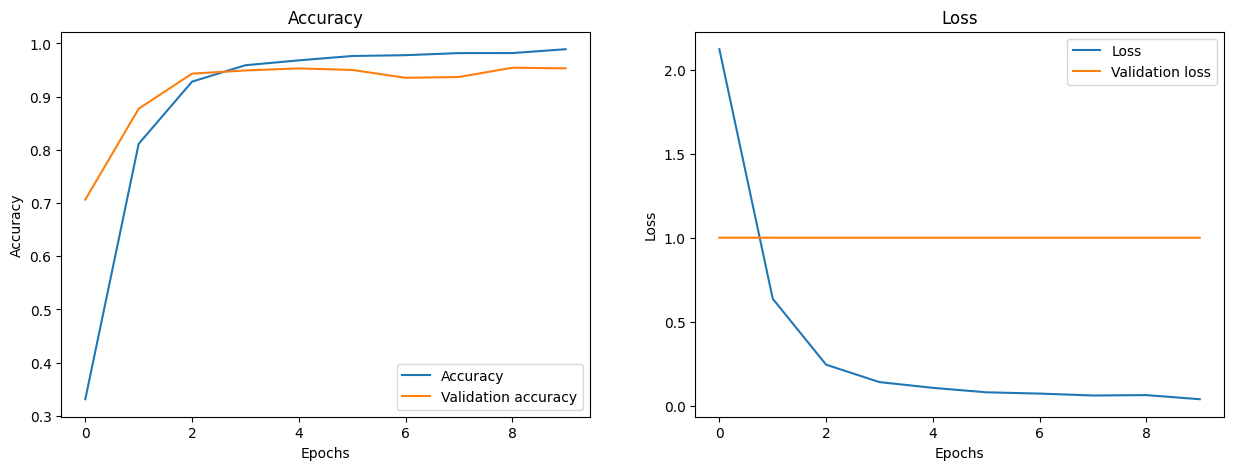

In [154]:
# Plotear historial de LSTM
rprint("\n[bold magenta]Historial de Entrenamiento LSTM:[/bold magenta]")
plot_history(lstm_history)

In [155]:
# Evaluar en el conjunto de test
rprint("\n[bold magenta]Evaluando LSTM en Test Set...[/bold magenta]")
_, accuracy_lstm = evaluate_rnn(lstm_model, loss_fn_lstm, test_dataloader_rnn)

rprint("\n" + "="*60)
rprint("[bold cyan]Comparación de Accuracy en Test Set[/bold cyan]")
rprint("="*60)
# Asumiendo que tienes estas variables de ejecuciones anteriores
rprint(f"  [bold green]LSTM:[/bold green] {accuracy_lstm * 100:.2f}%")
if 'baseline_accuracy' in locals():
    rprint(f"  Δ accuracy (from baseline):\t{(accuracy_lstm - baseline_accuracy) * 100:.2f}% ({baseline_accuracy * 100:.2f}%)")
if 'logistic_accuracy' in locals():
     rprint(f"  Δ accuracy (from logistic):\t{(accuracy_lstm - logistic_accuracy) * 100:.2f}% ({logistic_accuracy * 100:.2f}%)")
if 'accuracy_ff' in locals():
     rprint(f"  Δ accuracy (from ff):\t\t{(accuracy_lstm - accuracy_ff) * 100:.2f}% ({accuracy_ff * 100:.2f}%)")
if 'accuracy_emb' in locals():
     rprint(f"  Δ accuracy (from embeddings):\t{(accuracy_lstm - accuracy_emb) * 100:.2f}% ({accuracy_emb * 100:.2f}%)")
if 'accuracy_rnn' in locals():
     rprint(f"  Δ accuracy (from rnn):\t{(accuracy_lstm - accuracy_rnn) * 100:.2f}% ({accuracy_rnn * 100:.2f}%)")
rprint("-"*60)

Evaluando LSTM en Test Set...

============================================================

Comparación de Accuracy en Test Set

============================================================

LSTM: 94.50%

Δ accuracy (from baseline):   7.54% (86.96%)

Δ accuracy (from logistic):   3.87% (90.62%)

Δ accuracy (from ff):         2.73% (91.77%)

Δ accuracy (from embeddings): 2.48% (92.02%)

Δ accuracy (from rnn):        0.54% (93.96%)

------------------------------------------------------------

### ***Conclusión***

La arquitectura LSTM demuestra una superioridad clara en la tarea de POS tagging, alcanzando un **94.50% de accuracy en el conjunto de prueba**, superando a todos los modelos evaluados. Esta mejora sustancial (7.54% sobre el baseline y 3.87% sobre regresión logística) subraya su capacidad para modelar dependencias secuenciales de largo plazo, críticas en tareas de lenguaje natural donde el contexto precedente determina categóricamente la etiqueta POS de una palabra.  

El incremento del 0.54% frente a la RNN estándar confirma que los mecanismos de *gates* (olvido, entrada y salida) de la LSTM mitigan eficazmente el problema de desvanecimiento de gradientes, permitiendo aprender patrones sintácticos complejos en secuencias largas. Comparado con modelos no secuenciales (FF, embeddings estáticos), la ganancia del 2.48-2.73% refleja la importancia de incorporar información temporal, irreductible a meras características léxicas o posicionales.  

Aunque el costo computacional de la LSTM es mayor, su precisión justifica su uso en aplicaciones donde errores de tagging tienen consecuencias críticas (e.g., traducción automática o análisis sintáctico). Sin embargo, el modesto margen frente a la RNN (0.54%) sugiere que, para secuencias cortas o tareas menos dependientes de contexto histórico, arquitecturas más simples podrían ofrecer un equilibrio eficiencia-rendimiento aceptable. En síntesis, la LSTM emerge como el modelo óptimo para POS tagging en escenarios que exigen máxima precisión, gracias a su equilibrio entre capacidad de modelado secuencial y estabilidad en el entrenamiento.

# ***Anexo***

## ***Representación 2D con los colores correspondientes a su POS (no cluster)***

/tmp/ipykernel_31/2965820290.py:49: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7db9c8f04b10> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_words + [legend_centroid],


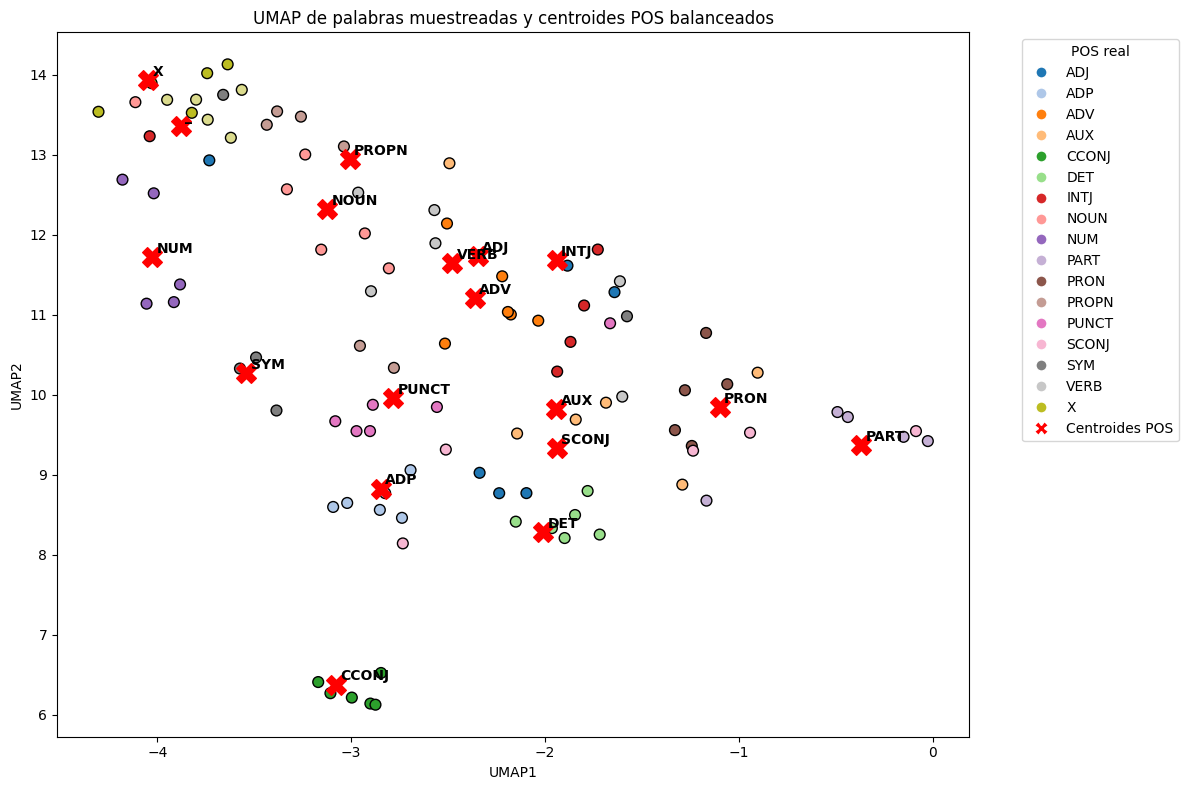

In [156]:
# —————————————————————————————————————————————
# 7) Preparar colores y marcadores
# —————————————————————————————————————————————
unique_word_tags = sorted(set(word_tags))
cmap = plt.colormaps.get_cmap('tab20')
tag2color = {tag: cmap(i) for i, tag in enumerate(unique_word_tags)}

# Colores para palabras
word_colors = [tag2color[tag] for tag in word_tags]

# Color único para centroides
centroid_color = 'red'

# —————————————————————————————————————————————
# 8) Graficar
# —————————————————————————————————————————————
plt.figure(figsize=(12,8))

# a) Palabras
plt.scatter(umap_word_2d[:,0], umap_word_2d[:,1],
            c=word_colors, s=60, edgecolor='k', label='Palabras')

# b) Centroides POS
plt.scatter(umap_pos_2d[:,0], umap_pos_2d[:,1],
            c=centroid_color, marker='X', s=200, label='Centroides POS')

# Anotar centroides con su etiqueta
for i, pos in enumerate(pos_tags_list):
    x, y = umap_pos_2d[i]
    plt.annotate(pos, (x, y), fontsize=10, fontweight='bold',
                 xytext=(3,3), textcoords='offset points')

# Leyenda
legend_words = []
for tag in unique_word_tags:
    display_label = tag if not tag.startswith("_") else f" {tag}"
    legend_words.append(
        Line2D([0],[0], 
               marker='o',
               color='w',
               markerfacecolor=tag2color[tag],
               markersize=8, label=tag)
    )


legend_centroid = Line2D([0],[0], marker='X', color='w', markerfacecolor=centroid_color,
                        markersize=10, label='Centroides POS')

plt.legend(handles=legend_words + [legend_centroid],
           title="POS real", bbox_to_anchor=(1.05,1), loc='upper left')

plt.title("UMAP de palabras muestreadas y centroides POS balanceados")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

Aquí es bastante claro que las etiquetas POS generadas si están relacionadas acorde con los embeddings, por lo que, es una visualización fidedigna. 

## ***POS tags de todos los ejemplos***

A continuación mostraremos cuantos ejemplos hay en todo el conjunto de entrenamiento por cada POS tag.

In [157]:
pos_embeddings_dict = {}
for sent, tags in zip(X_train_rnn, Y_train_rnn):
    for word_idx, tag_idx in zip(sent, tags):
        pos_label = idx2pos[int(tag_idx)]
        word_embedding = rnn_model.embedding.weight[int(word_idx)].detach().cpu().numpy()
        pos_embeddings_dict.setdefault(pos_label, []).append(word_embedding)

# Veamos cuántos ejemplos tenemos por cada etiqueta:
for pos, emb_list in pos_embeddings_dict.items():
    print(f"{pos}: {len(emb_list)} ejemplos")

ADJ: 910086 ejemplos
NOUN: 27288 ejemplos
CCONJ: 5390 ejemplos
PUNCT: 22748 ejemplos
ADP: 15476 ejemplos
PROPN: 9528 ejemplos
VERB: 17189 ejemplos
ADV: 7839 ejemplos
AUX: 8821 ejemplos
DET: 13328 ejemplos
PRON: 13798 ejemplos
SCONJ: 2648 ejemplos
X: 317 ejemplos
SYM: 267 ejemplos
PART: 3934 ejemplos
_: 2810 ejemplos
NUM: 3170 ejemplos
INTJ: 1603 ejemplos


## ***Muestreo no estratificado***

In [158]:
vocabulary_words = list(word2idx.keys())

if len(vocabulary_words) >= 100:
    random_words = random.sample(vocabulary_words, 100)
else:
    random_words = vocabulary_words # Tomar todas si hay menos de 100
    rprint(f"[yellow]Advertencia:[/yellow] Menos de 100 palabras en el vocabulario ({len(vocabulary_words)}), usando todas.")


sample_indices = [word2idx[w] for w in random_words]
embeds_sample = rnn_model.embedding.weight[sample_indices].detach().cpu().numpy()

### ***POS tags***

In [159]:
tensor = torch.LongTensor(sample_indices).unsqueeze(0).to(device)
outputs = rnn_model(tensor)
predictions = torch.argmax(outputs, dim=-1).squeeze().cpu().numpy()

In [160]:
pred_tags = [idx2pos[int(pred)] for pred in predictions]

# Ahora generamos el counter de las etiquetas
tag_counter = Counter(pred_tags)

tag_counter

Counter({'_': 7,
         'PROPN': 21,
         'NOUN': 21,
         'PRON': 3,
         'X': 19,
         'VERB': 14,
         'ADV': 2,
         'NUM': 4,
         'CCONJ': 1,
         'ADP': 1,
         'SYM': 2,
         'SCONJ': 2,
         'PUNCT': 1,
         'PART': 1,
         'DET': 1})

Como se puede apreciar, hay algunas POS tags que ni siquiera están representadas y otras que dominan el muestreo; en este caso `PROPN`. De ahí que en la versión oficial tengamos el muestreo estratificado.

### ***Clustering***

Esta sección también provará que las métricas de los métodos de clusterización es peor cuando no hacemo el muestreo estratificado.

Entrenando con GaussianMixture...


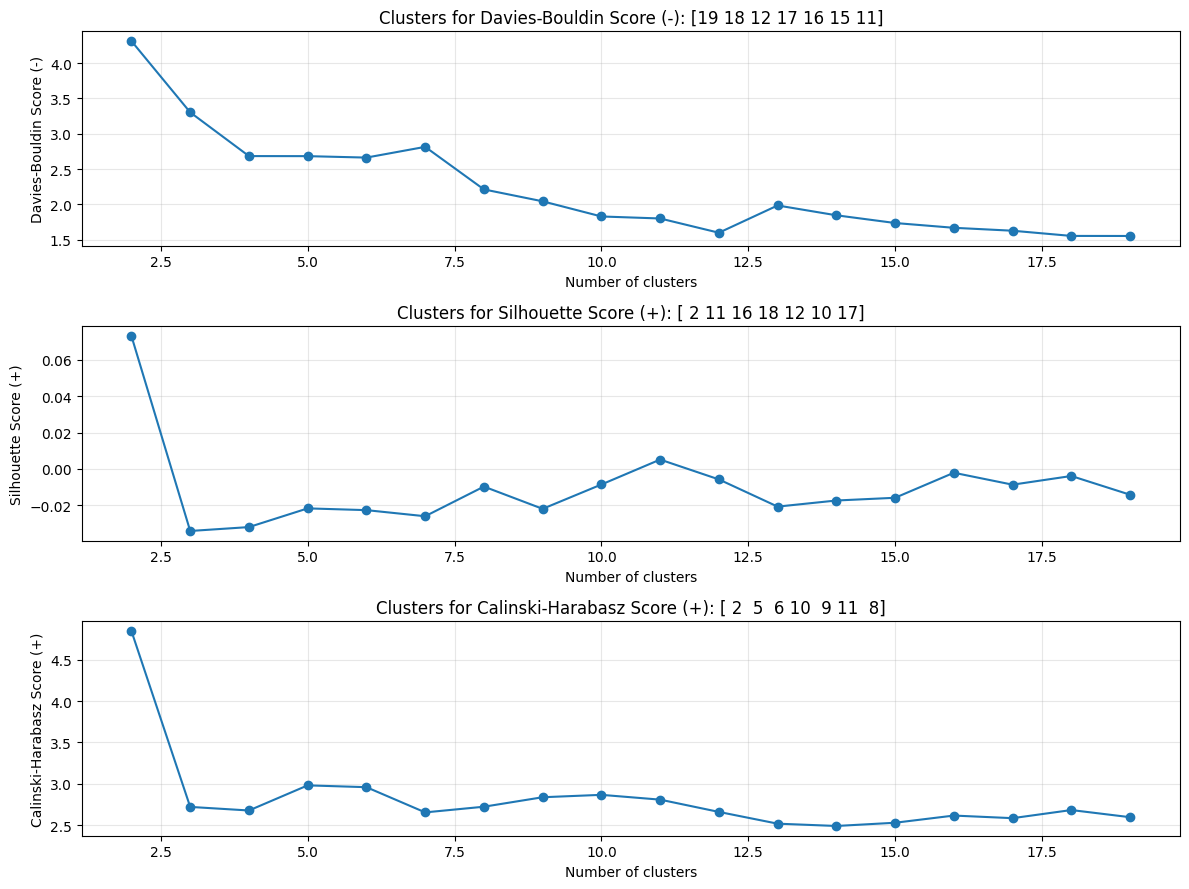

array([11])

In [161]:
graph_metrics("GaussianMixture", embeds_sample, 20)

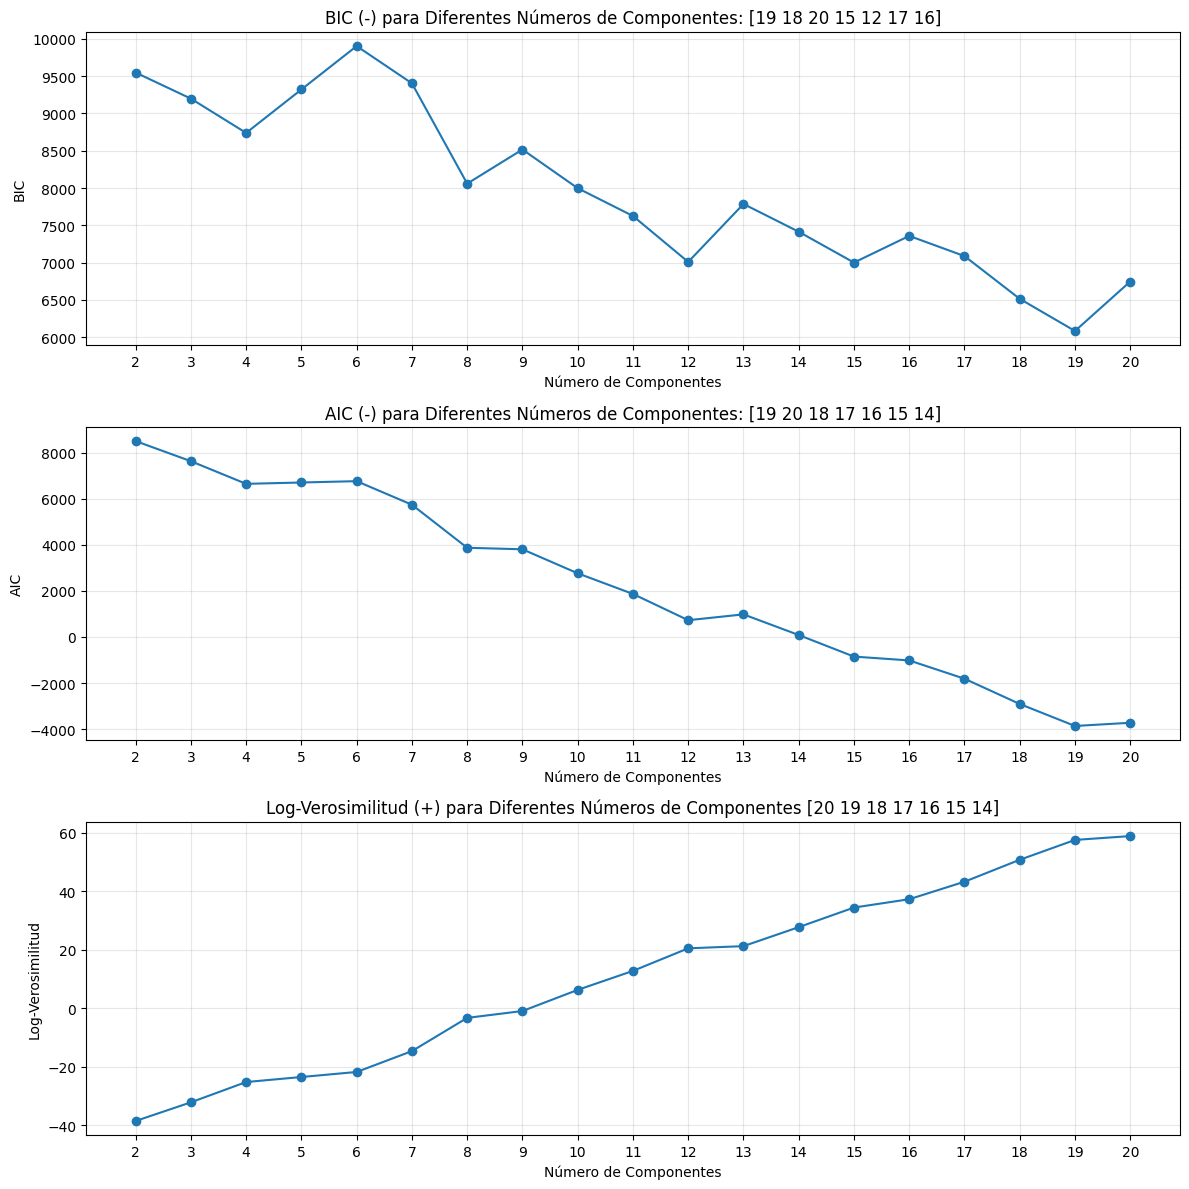

In [162]:
plot_gmm_metrics(embeds_sample, 20)

╒═════════════════════════════╤═════════╕
│ Metric                      │   Value │
╞═════════════════════════════╪═════════╡
│ Calinski-Harabasz score (+) │ 2.81    │
├─────────────────────────────┼─────────┤
│ Davies-Bouldin score (-)    │ 1.80003 │
├─────────────────────────────┼─────────┤
│ Silhouette score (+)        │ 0.00516 │
╘═════════════════════════════╧═════════╛


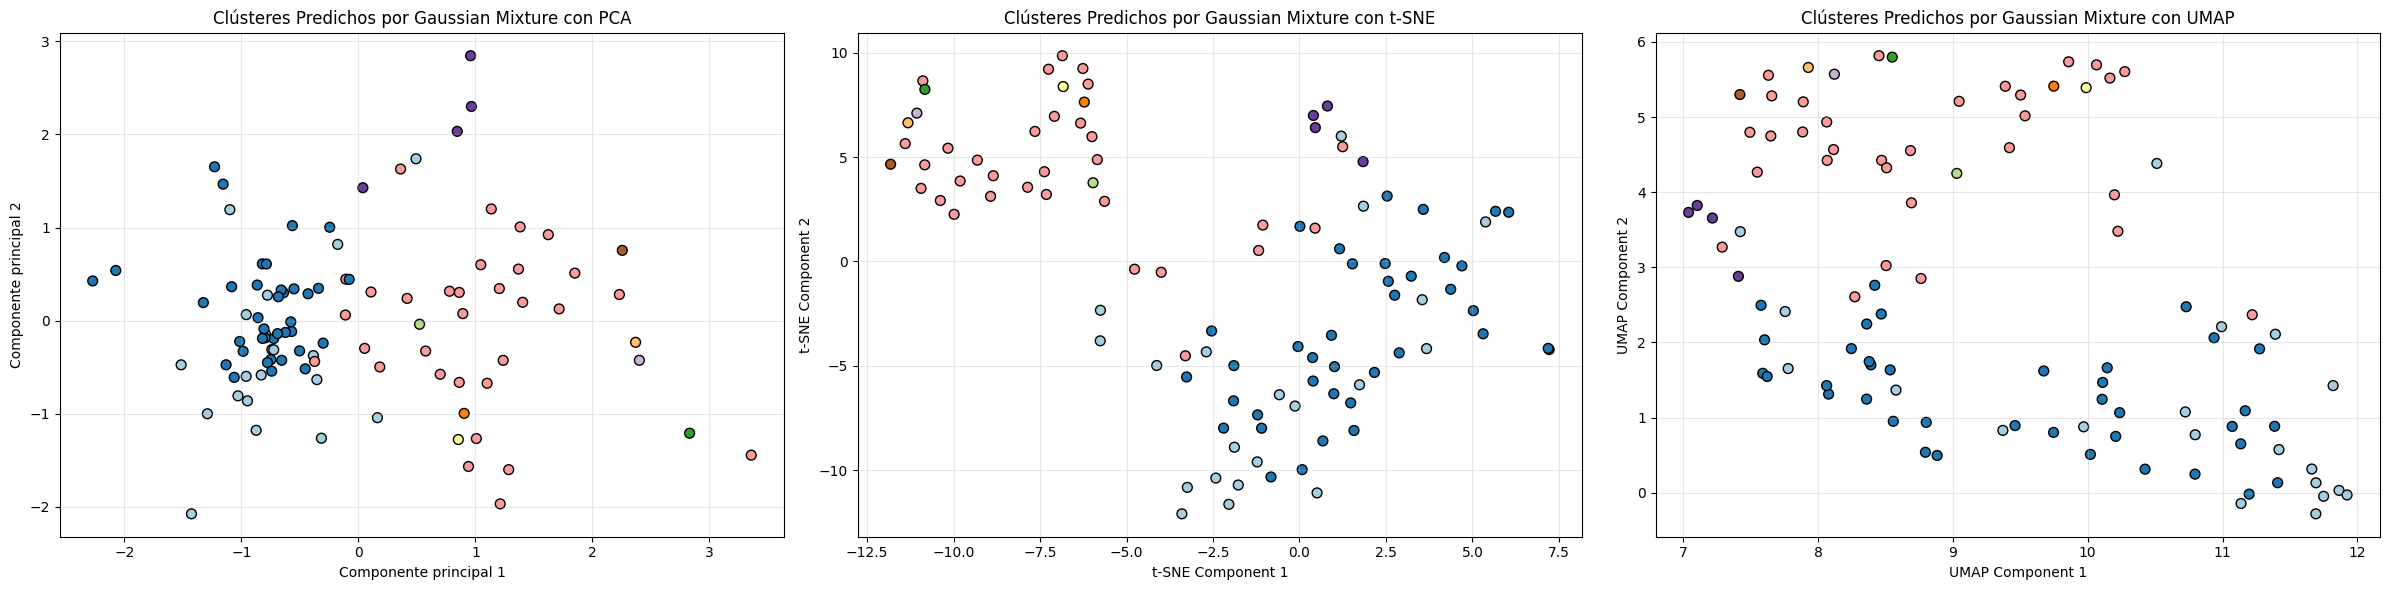

In [163]:
gaussian = GaussianMixture(n_components=11, random_state=RANDOM_STATE, covariance_type='diag')
gaussian_labels = gaussian.fit_predict(embeds_sample)

metrics(gaussian_labels, embeds_sample)
plot_clustering(embeds_sample, gaussian_labels, "Gaussian Mixture")

Entrenando con KMeans...


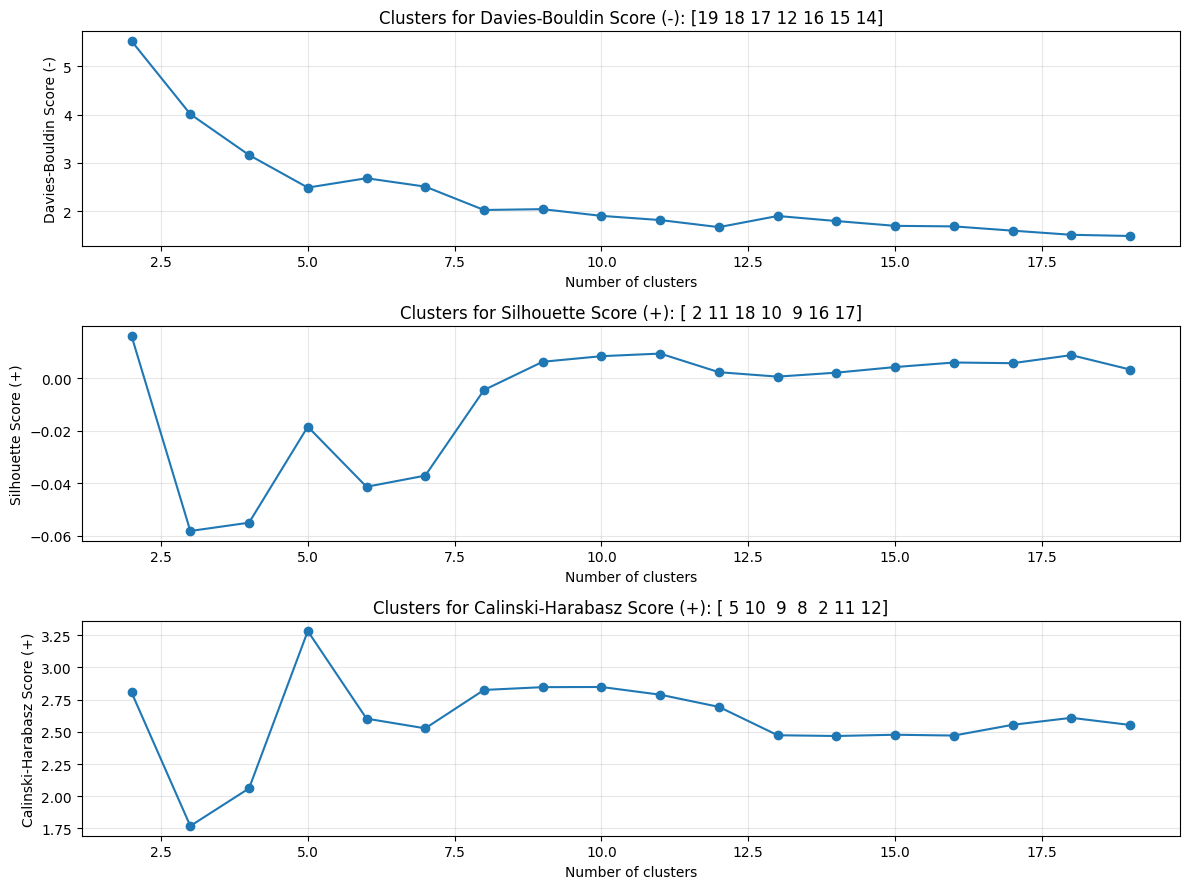

array([], dtype=int64)

In [164]:
graph_metrics("KMeans", embeds_sample, 20)

╒═════════════════════════════╤═════════╕
│ Metric                      │   Value │
╞═════════════════════════════╪═════════╡
│ Calinski-Harabasz score (+) │ 2.79    │
├─────────────────────────────┼─────────┤
│ Davies-Bouldin score (-)    │ 1.82074 │
├─────────────────────────────┼─────────┤
│ Silhouette score (+)        │ 0.00937 │
╘═════════════════════════════╧═════════╛


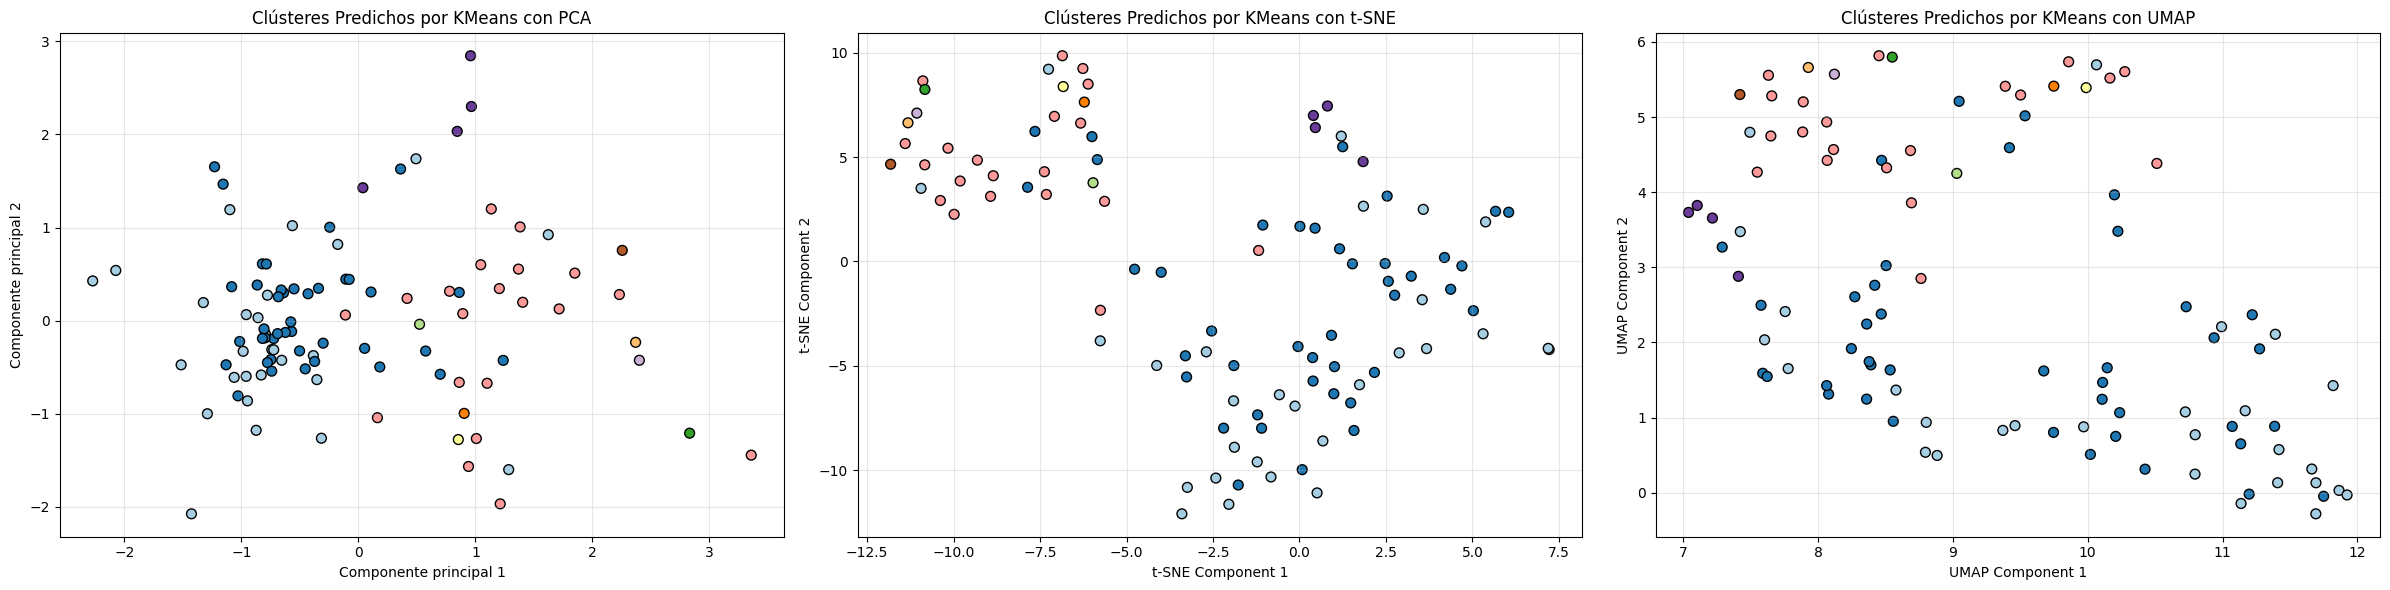

In [165]:
kmeans = KMeans(n_clusters=11, random_state=RANDOM_STATE, n_init='auto')
kmeans_labels = kmeans.fit_predict(embeds_sample)

metrics(kmeans_labels, embeds_sample)
plot_clustering(embeds_sample, kmeans_labels, "KMeans")

Entrenando con AgglomerativeClustering...


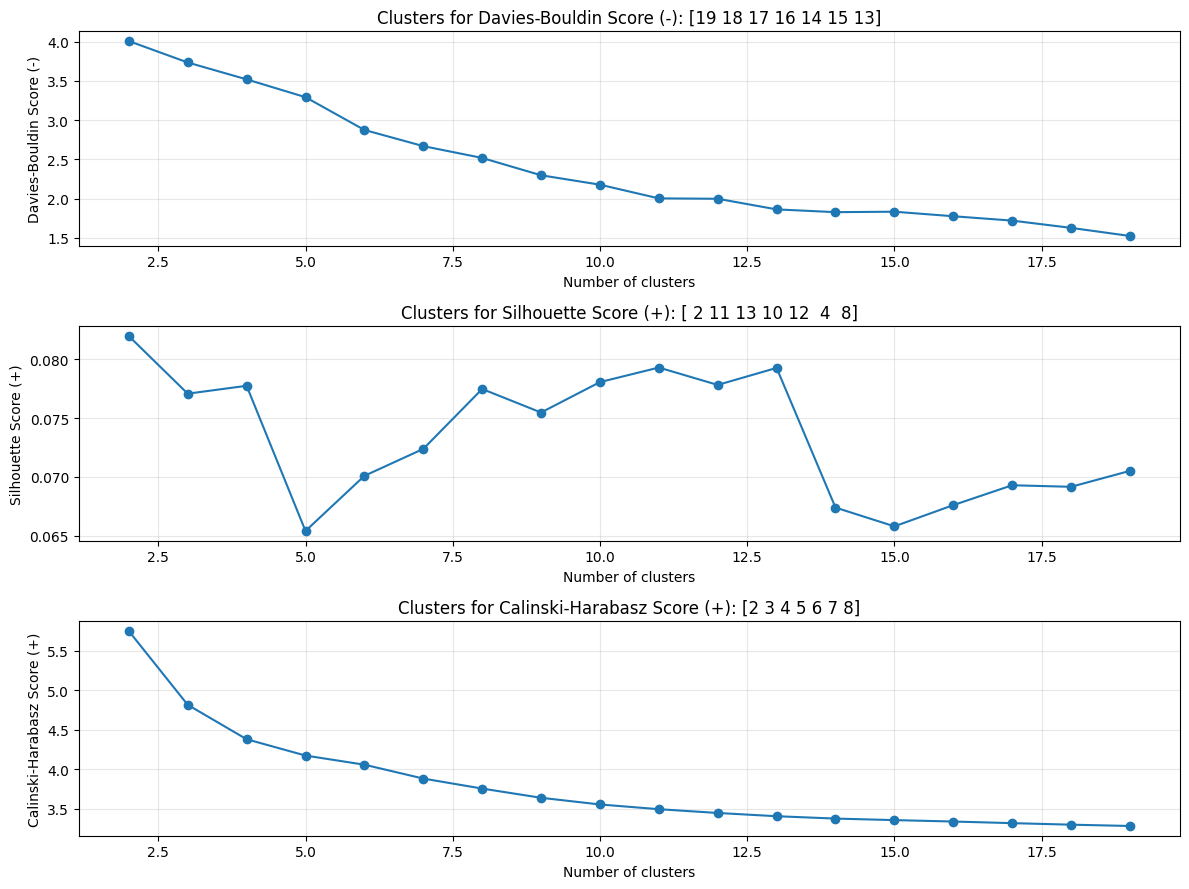

array([], dtype=int64)

In [166]:
graph_metrics("AgglomerativeClustering", embeds_sample, 20)

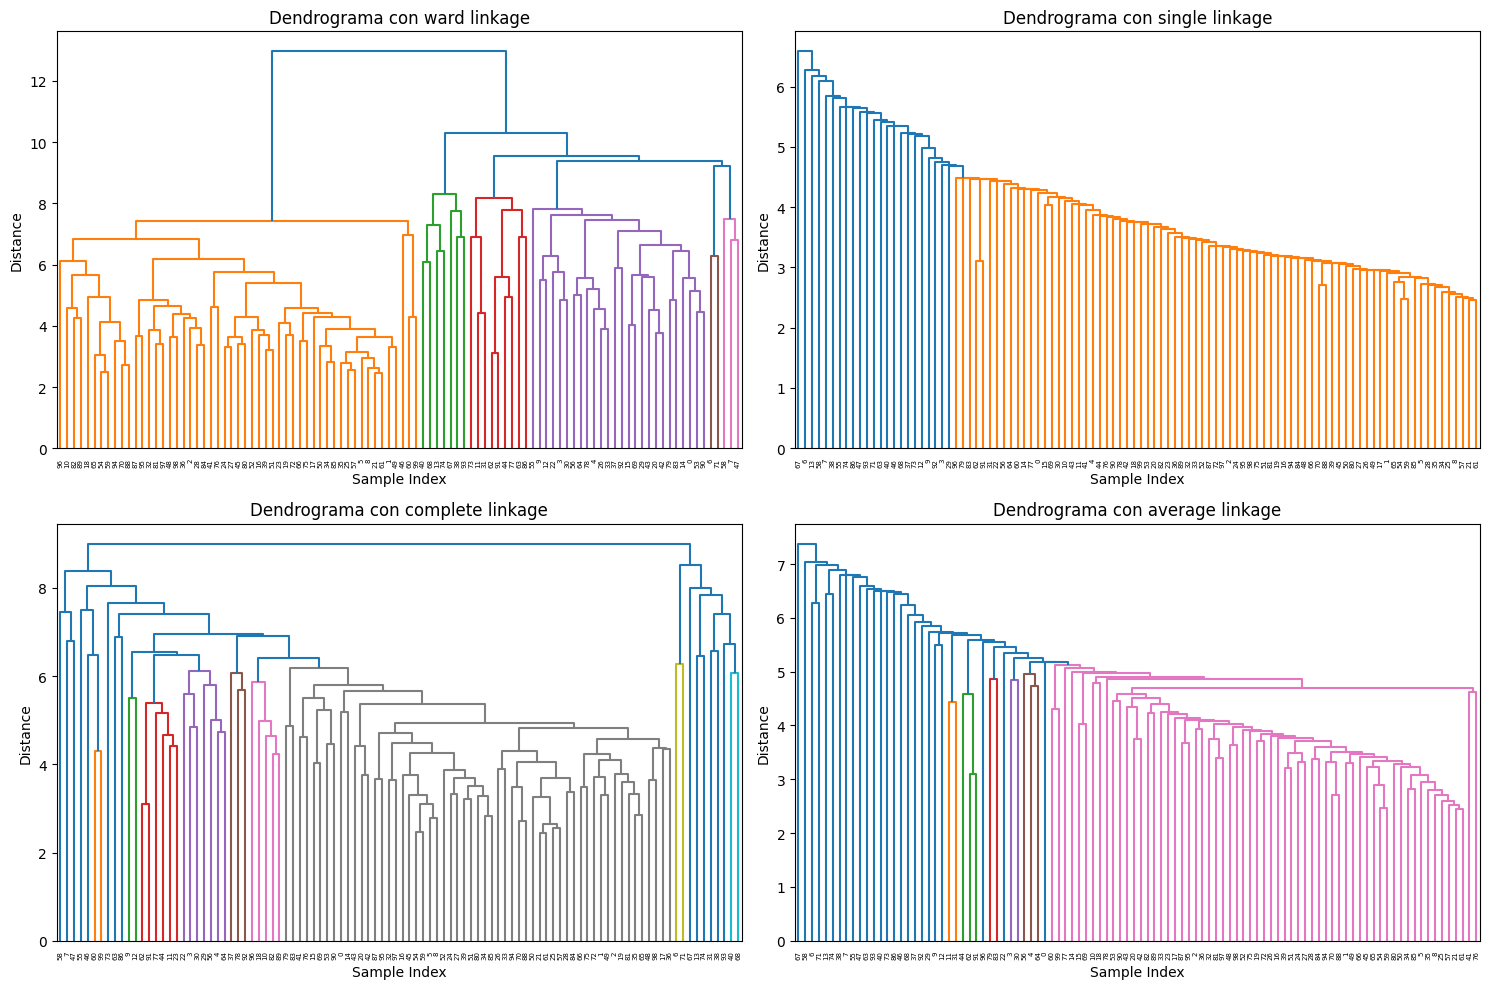

In [167]:
linkage_methods = ['ward', 'single', 'complete', 'average']

plt.figure(figsize=(15, 10))

for i, method in enumerate(linkage_methods):
    plt.subplot(2, 2, i + 1)
    plt.gcf().set_facecolor('white')
    linkage_matrix = linkage(embeds_sample, method=method)
    dendrogram(linkage_matrix)
    plt.title(f'Dendrograma con {method} linkage')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()

╒═════════════════════════════╤═════════╕
│ Metric                      │   Value │
╞═════════════════════════════╪═════════╡
│ Calinski-Harabasz score (+) │ 5.75    │
├─────────────────────────────┼─────────┤
│ Davies-Bouldin score (-)    │ 4.00714 │
├─────────────────────────────┼─────────┤
│ Silhouette score (+)        │ 0.08199 │
╘═════════════════════════════╧═════════╛


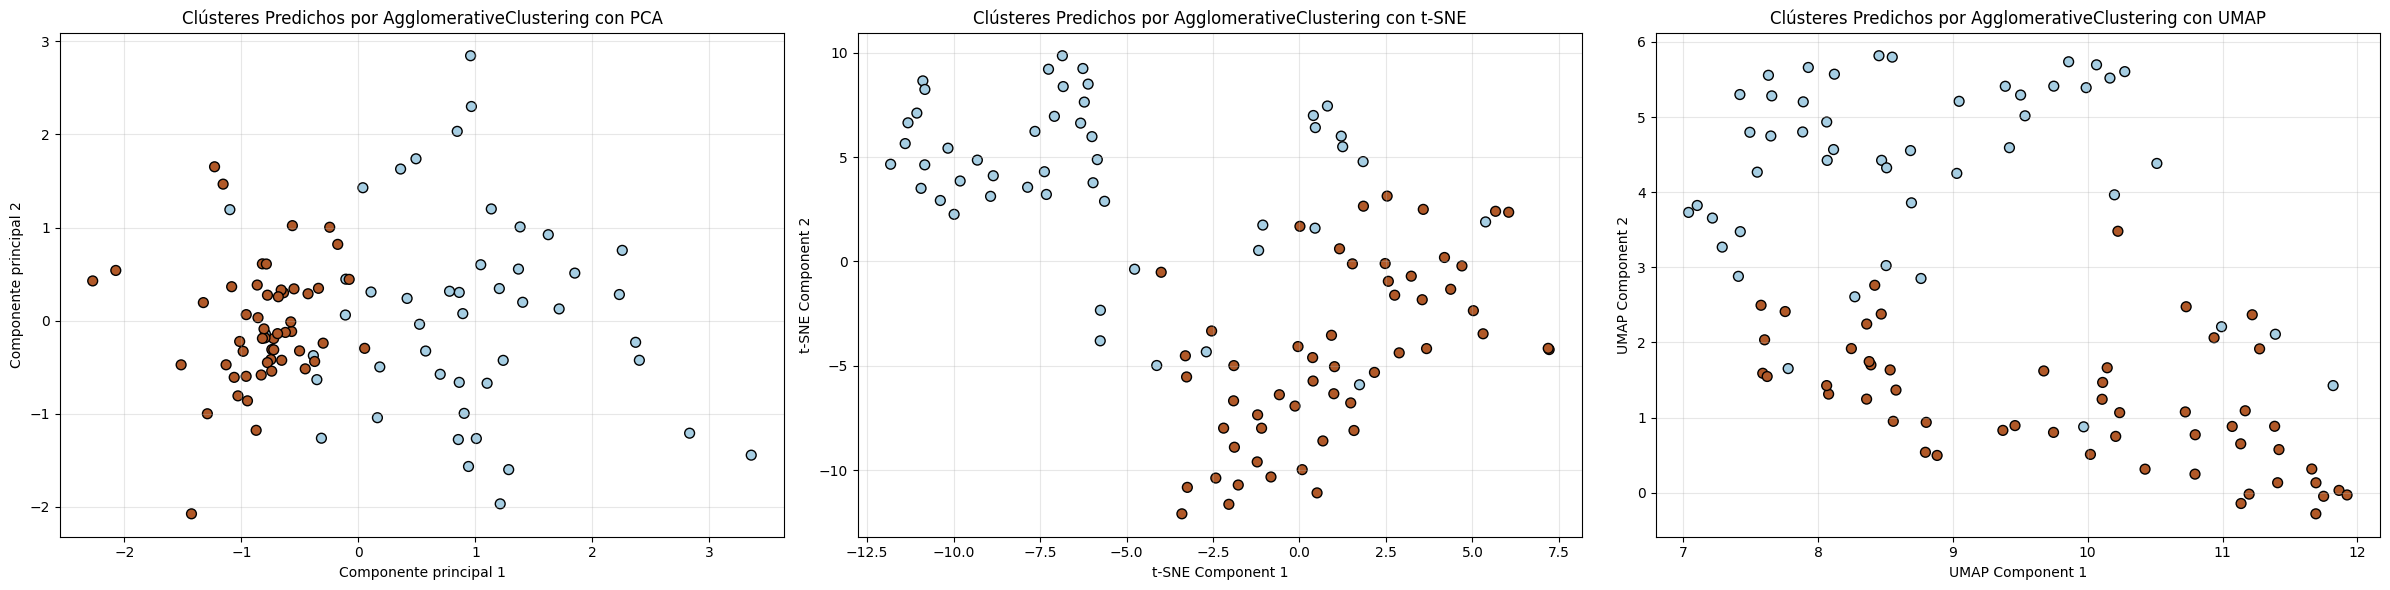

In [168]:
agglomerative = AgglomerativeClustering(n_clusters=2)
agglomerative_labels = agglomerative.fit_predict(embeds_sample)

metrics(agglomerative_labels, embeds_sample)
plot_clustering(embeds_sample, agglomerative_labels, "AgglomerativeClustering")

Dado que mezclas gaussinas y kmeans tienen los mejores resultados y de hecho tienen los mismos resultados, pues usaremos KMeans con $k=2$ para clusterizar, esto ya que es lo que nos da mejor valor en las 3 métricas en general. 

In [169]:
# --- Obtener embeddings promediados por POS ---
pos_embeddings = defaultdict(lambda: np.zeros(100))  # Asume EMBEDDING_DIM=100
pos_counts = defaultdict(int)

# Iterar sobre datos de entrenamiento
for sentence, pos_tags in zip(X_train_rnn, Y_train_rnn):
    for word_idx, tag_idx in zip(sentence, pos_tags):
        
        pos_label = idx2pos[int(tag_idx)]
        word_embedding = rnn_model.embedding.weight[int(word_idx)].detach().cpu().numpy()
        
        pos_embeddings[pos_label] += word_embedding
        pos_counts[pos_label] += 1

# Calcular promedio
for pos in pos_embeddings:
    pos_embeddings[pos] /= pos_counts[pos]

# Convertir a arrays
pos_tags = list(pos_embeddings.keys())
pos_embeds = np.array([pos_embeddings[pos] for pos in pos_tags])

combined_embeddings = np.concatenate([embeds_sample, pos_embeds])

### ***PCA con POS tags como promedio de todo el conjunto de entrenamiento***

/tmp/ipykernel_31/3740460462.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_embeddings_2d[:100, 0], pca_embeddings_2d[:100, 1], label='Palabras', c=point_colors,
/tmp/ipykernel_31/3740460462.py:45: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7db9c76be3d0> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_words + [legend_centroid],


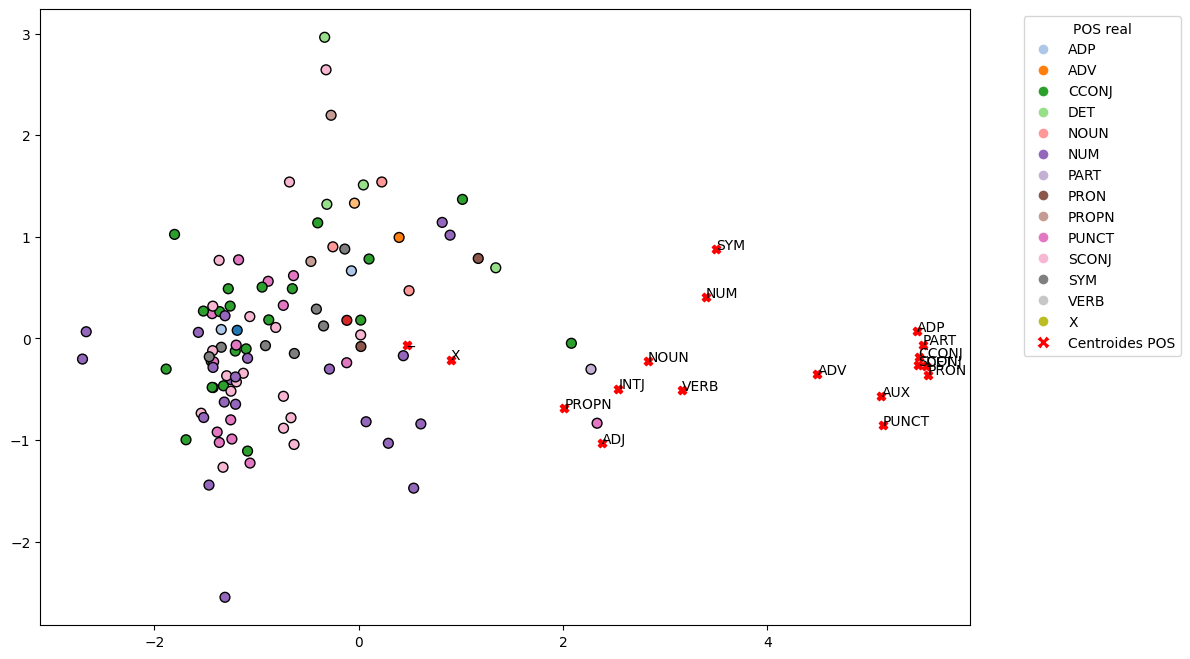

In [170]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca_embeddings_2d = pca.fit_transform(combined_embeddings)

tensor = torch.LongTensor(sample_indices).unsqueeze(0).to(device)
outputs = rnn_model(tensor)
predictions = torch.argmax(outputs, dim=-1).squeeze().cpu().numpy()

pred_tags = [idx2pos[int(pred)] for pred in predictions]

# Obtener la lista de etiquetas únicas y ordenarla (para que siempre tenga el mismo orden)
unique_tags = sorted(set(pred_tags))

# Creamos un mapa de colores: usaremos un cmap que tenga variedad de colores, por ejemplo 'tab20'
cmap = plt.colormaps.get_cmap('tab20')
tag_to_color = {tag: cmap(i) for i, tag in enumerate(unique_tags)}

# Generamos una lista de colores para cada muestra según su etiqueta
point_colors = [tag_to_color[tag] for tag in pred_tags]

# --- Graficar ---
plt.figure(figsize=(12, 8))
plt.scatter(pca_embeddings_2d[:100, 0], pca_embeddings_2d[:100, 1], label='Palabras', c=point_colors,
            cmap='Paired', marker='o', edgecolor='k', s=50)
plt.scatter(pca_embeddings_2d[100:, 0], pca_embeddings_2d[100:, 1], marker='X', color='red', label='POS')
for i, pos in enumerate(pos_tags):
    plt.annotate(pos, (pca_embeddings_2d[100 + i, 0], pca_embeddings_2d[100 + i, 1]))


# Leyenda
legend_words = []
for tag in unique_tags:
    display_label = tag if not tag.startswith("_") else f" {tag}"
    legend_words.append(
        Line2D([0],[0], 
               marker='o',
               color='w',
               markerfacecolor=tag2color[tag],
               markersize=8, label=tag)
    )


legend_centroid = Line2D([0],[0], marker='X', color='w', markerfacecolor=centroid_color,
                        markersize=10, label='Centroides POS')

plt.legend(handles=legend_words + [legend_centroid],
           title="POS real", bbox_to_anchor=(1.05,1), loc='upper left')


plt.show()

En este gráfico es claro ver como muchas POS tag al estar sesgadas por el conjunto de entreamiento completo, se encuentran bastante distantes de las palabras sumuestreadas; esto se debe también, en parte, al hecho del desbalaceo de categorías POS que tenemos.

### ***PCA con POS como `rnn_model.linear.weight`***

/tmp/ipykernel_31/152236056.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_embed_2d[:, 0], pca_embed_2d[:, 1], label='Palabras', c=point_colors,
/tmp/ipykernel_31/152236056.py:30: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7db9c76bad50> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_words + [legend_centroid],


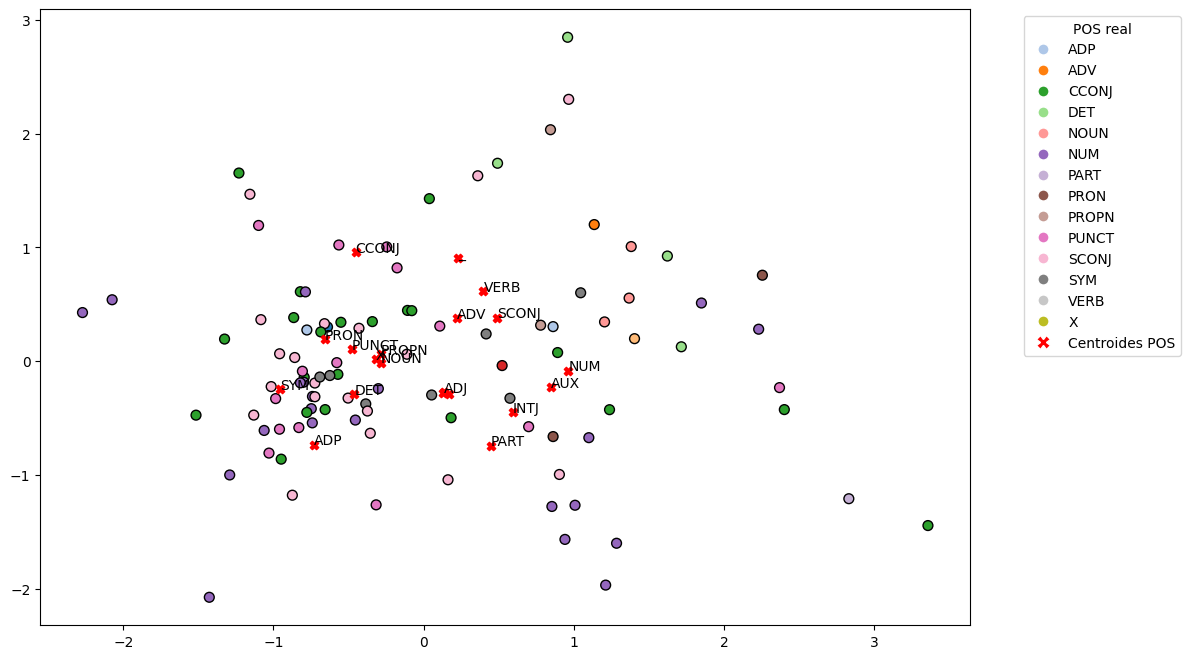

In [171]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca_embed_2d = pca.fit_transform(embeds_sample)
pca_pos_2d = pca.fit_transform(rnn_model.linear.weight.detach().cpu().numpy())

# --- Graficar ---
plt.figure(figsize=(12, 8))
plt.scatter(pca_embed_2d[:, 0], pca_embed_2d[:, 1], label='Palabras', c=point_colors,
            cmap='Paired', marker='o', edgecolor='k', s=50)
plt.scatter(pca_pos_2d[:, 0], pca_pos_2d[:, 1], marker='X', color='red', label='POS')
for i, pos in enumerate(pos_tags):
    plt.annotate(pos, (pca_pos_2d[i, 0], pca_pos_2d[i, 1]))


# Leyenda
legend_words = []
for tag in unique_tags:
    display_label = tag if not tag.startswith("_") else f" {tag}"
    legend_words.append(
        Line2D([0],[0], 
               marker='o',
               color='w',
               markerfacecolor=tag2color[tag],
               markersize=8, label=tag)
    )


legend_centroid = Line2D([0],[0], marker='X', color='w', markerfacecolor=centroid_color,
                        markersize=10, label='Centroides POS')

plt.legend(handles=legend_words + [legend_centroid],
           title="POS real", bbox_to_anchor=(1.05,1), loc='upper left')



plt.show()

En este caso, al ser una transformación lineal parece que los POS tags a pesar de no estar en la misma dimensionalidad que los embeddings se ajustan; sin embargo, si marcamos los labels con su correspondiente POS tag real, nos daríamos cuenta que en realidad no se está representando bien. 

### ***t-SNE con POS tags como promedio de todo el conjunto de entrenamiento***

/tmp/ipykernel_31/3441176262.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:100, 0], embeddings_2d[:100, 1], label='Palabras', c=point_colors,
/tmp/ipykernel_31/3441176262.py:29: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7db9c7d61550> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_words + [legend_centroid],


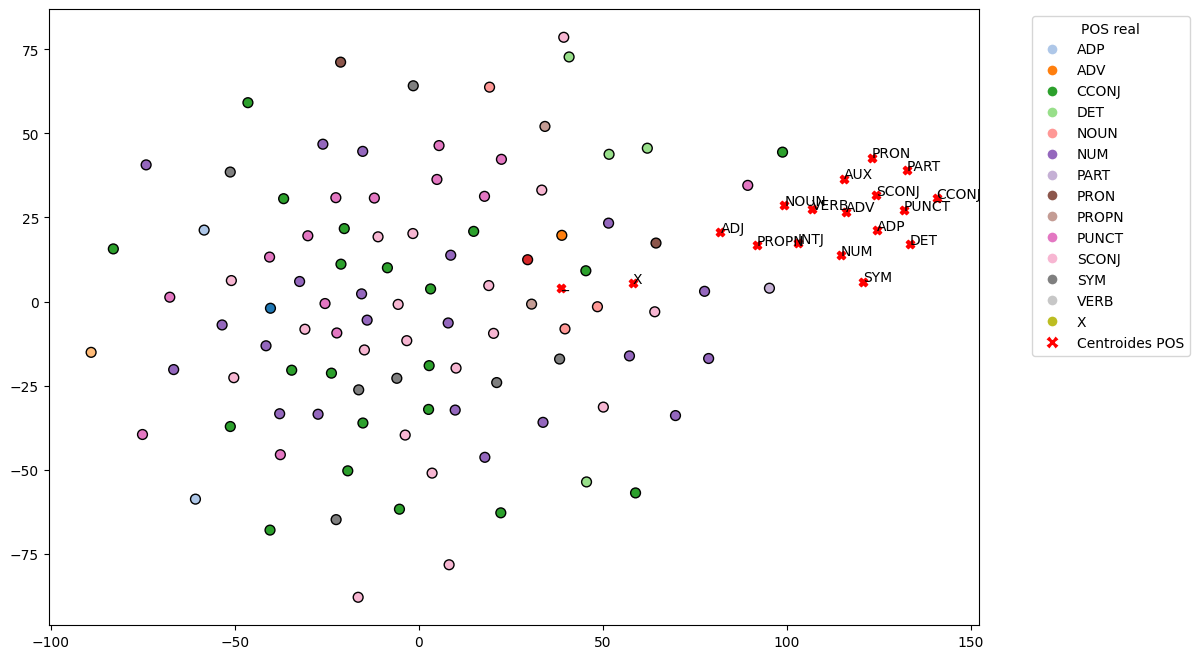

In [172]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=19)
embeddings_2d = tsne.fit_transform(combined_embeddings)

# --- Graficar ---
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:100, 0], embeddings_2d[:100, 1], label='Palabras', c=point_colors,
            cmap='Paired', marker='o', edgecolor='k', s=50)
plt.scatter(embeddings_2d[100:, 0], embeddings_2d[100:, 1], marker='X', color='red', label='POS')
for i, pos in enumerate(pos_tags):
    plt.annotate(pos, (embeddings_2d[100 + i, 0], embeddings_2d[100 + i, 1]))


# Leyenda
legend_words = []
for tag in unique_tags:
    display_label = tag if not tag.startswith("_") else f" {tag}"
    legend_words.append(
        Line2D([0],[0], 
               marker='o',
               color='w',
               markerfacecolor=tag2color[tag],
               markersize=8, label=tag)
    )


legend_centroid = Line2D([0],[0], marker='X', color='w', markerfacecolor=centroid_color,
                        markersize=10, label='Centroides POS')

plt.legend(handles=legend_words + [legend_centroid],
           title="POS real", bbox_to_anchor=(1.05,1), loc='upper left')



plt.show()

Sucede algo bastante similar a PCA donde los valores de las POS tag se encuentran demasiado concentrados en un solo punto y separados de las palabras.

### ***t-SNE con POS como `rnn_model.linear.weight`***

/tmp/ipykernel_31/1355972616.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_embed_2d[:, 0], tsne_embed_2d[:, 1], label='Palabras', c=point_colors,
/tmp/ipykernel_31/1355972616.py:30: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7db9c7d7ca50> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_words + [legend_centroid],


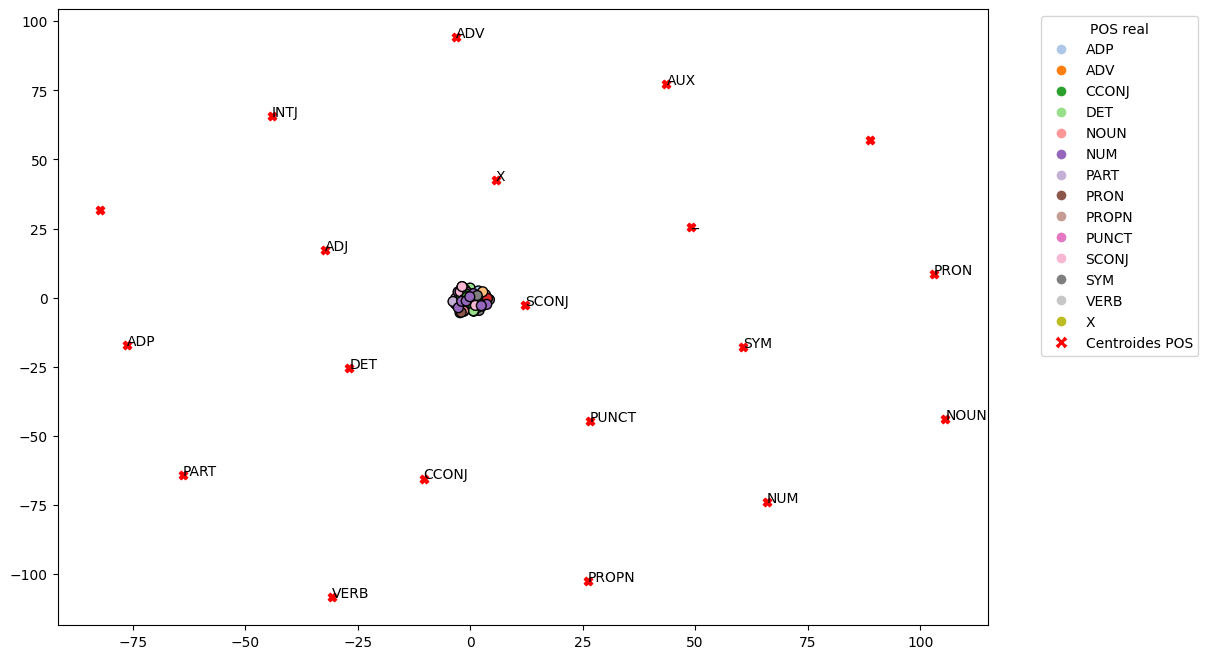

In [173]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=19)
tsne_embed_2d = tsne.fit_transform(embeds_sample)
tsne_pos_2d = tsne.fit_transform(rnn_model.linear.weight.detach().cpu().numpy())

# --- Graficar ---
plt.figure(figsize=(12, 8))
plt.scatter(tsne_embed_2d[:, 0], tsne_embed_2d[:, 1], label='Palabras', c=point_colors,
            cmap='Paired', marker='o', edgecolor='k', s=50)
plt.scatter(tsne_pos_2d[:, 0], tsne_pos_2d[:, 1], marker='X', color='red', label='POS')
for i, pos in enumerate(pos_tags):
    plt.annotate(pos, (tsne_pos_2d[i, 0], tsne_pos_2d[i, 1]))


# Leyenda
legend_words = []
for tag in unique_tags:
    display_label = tag if not tag.startswith("_") else f" {tag}"
    legend_words.append(
        Line2D([0],[0], 
               marker='o',
               color='w',
               markerfacecolor=tag2color[tag],
               markersize=8, label=tag)
    )


legend_centroid = Line2D([0],[0], marker='X', color='w', markerfacecolor=centroid_color,
                        markersize=10, label='Centroides POS')

plt.legend(handles=legend_words + [legend_centroid],
           title="POS real", bbox_to_anchor=(1.05,1), loc='upper left')


plt.show()

Aquí es bastante evidente ver como `rnn_model.linear.weight` no se encuentra en el mismo espacio dimensional que los embeddings de palabras y por qué se tienen que promediar.

### ***UMAP con POS tags como promedio de todo el conjunto de entrenamiento***

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_31/2722117838.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embeddings_2d[:100, 0], umap_embeddings_2d[:100, 1], label='Palabras', c=point_colors,
/tmp/ipykernel_31/2722117838.py:28: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7db9c782dc50> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_words + [legend_centroid],


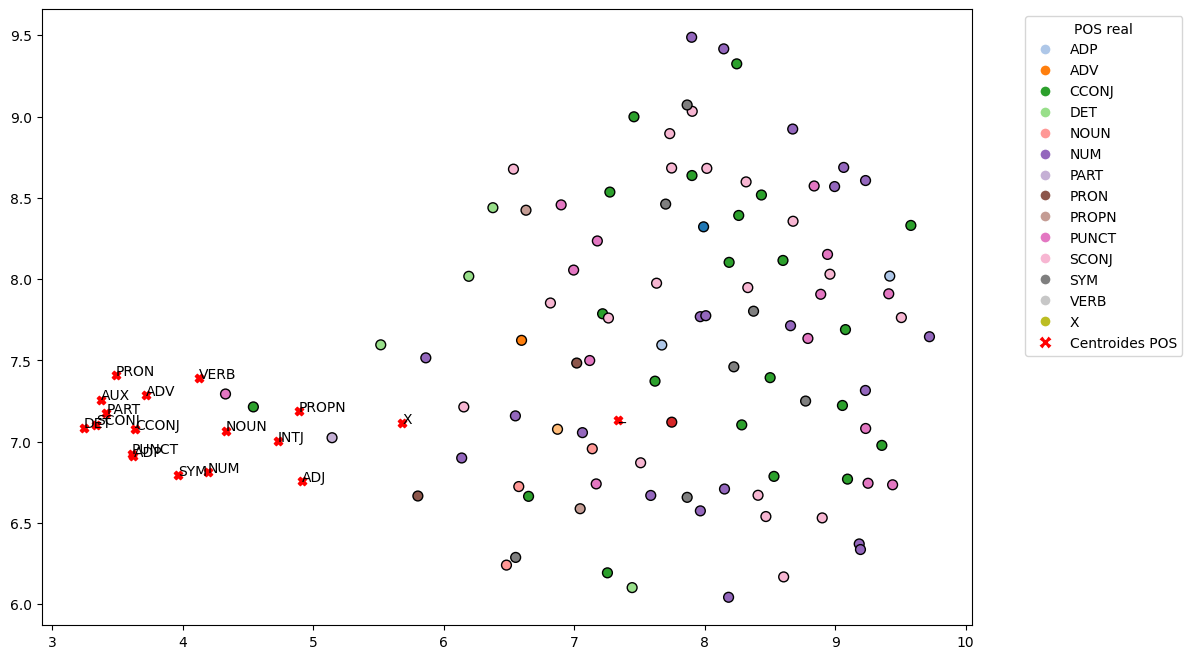

In [174]:
umap = UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=19)
umap_embeddings_2d = umap.fit_transform(combined_embeddings)

# --- Graficar ---
plt.figure(figsize=(12, 8))
plt.scatter(umap_embeddings_2d[:100, 0], umap_embeddings_2d[:100, 1], label='Palabras', c=point_colors,
            cmap='Paired', marker='o', edgecolor='k', s=50)
plt.scatter(umap_embeddings_2d[100:, 0], umap_embeddings_2d[100:, 1], marker='X', color='red', label='POS')
for i, pos in enumerate(pos_tags):
    plt.annotate(pos, (umap_embeddings_2d[100 + i, 0], umap_embeddings_2d[100 + i, 1]))

# Leyenda
legend_words = []
for tag in unique_tags:
    display_label = tag if not tag.startswith("_") else f" {tag}"
    legend_words.append(
        Line2D([0],[0], 
               marker='o',
               color='w',
               markerfacecolor=tag2color[tag],
               markersize=8, label=tag)
    )


legend_centroid = Line2D([0],[0], marker='X', color='w', markerfacecolor=centroid_color,
                        markersize=10, label='Centroides POS')

plt.legend(handles=legend_words + [legend_centroid],
           title="POS real", bbox_to_anchor=(1.05,1), loc='upper left')



plt.show()

El patrón que se ha visto en los dos anteriores se repite.

### ***UMAP con POS como `rnn_model.linear.weight`***

/tmp/ipykernel_31/3957654273.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embed_2d[:, 0], umap_embed_2d[:, 1], label='Palabras', c=point_colors,
/tmp/ipykernel_31/3957654273.py:29: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x7db9c772b450> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=legend_words + [legend_centroid],


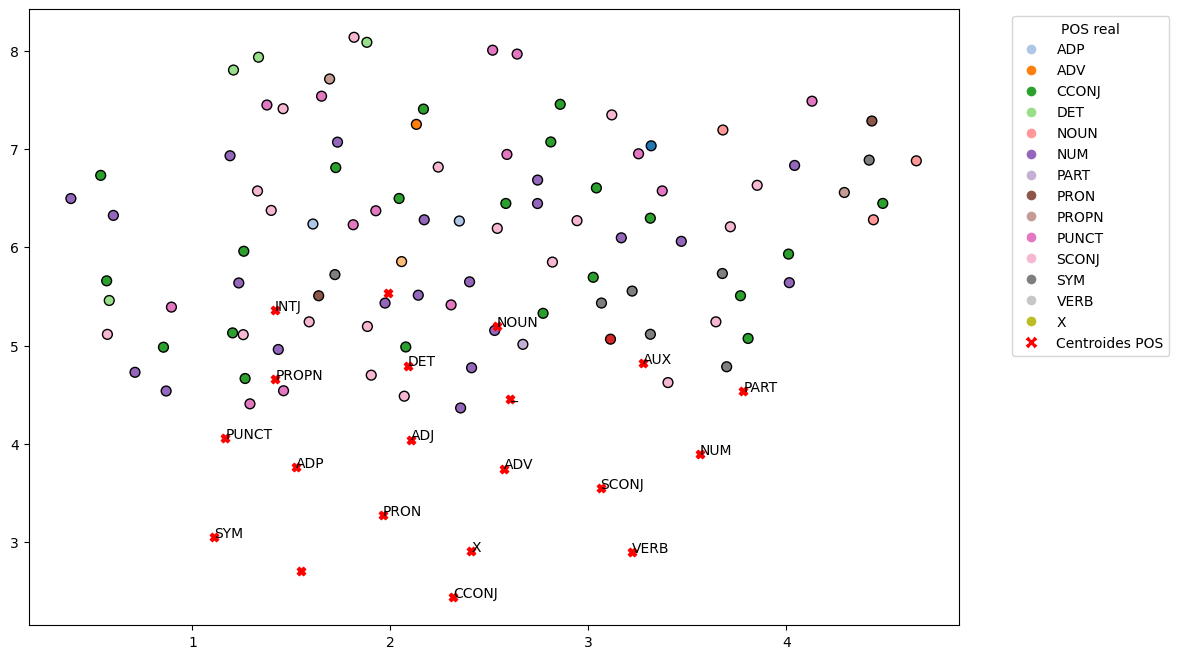

In [175]:
umap = UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=19, n_jobs=1)
umap_embed_2d = umap.fit_transform(embeds_sample)
umap_pos_2d = umap.fit_transform(rnn_model.linear.weight.detach().cpu().numpy())

# --- Graficar ---
plt.figure(figsize=(12, 8))
plt.scatter(umap_embed_2d[:, 0], umap_embed_2d[:, 1], label='Palabras', c=point_colors,
            cmap='Paired', marker='o', edgecolor='k', s=50)
plt.scatter(umap_pos_2d[:, 0], umap_pos_2d[:, 1], marker='X', color='red', label='POS')
for i, pos in enumerate(pos_tags):
    plt.annotate(pos, (umap_pos_2d[i, 0], umap_pos_2d[i, 1]))

# Leyenda
legend_words = []
for tag in unique_tags:
    display_label = tag if not tag.startswith("_") else f" {tag}"
    legend_words.append(
        Line2D([0],[0], 
               marker='o',
               color='w',
               markerfacecolor=tag2color[tag],
               markersize=8, label=tag)
    )


legend_centroid = Line2D([0],[0], marker='X', color='w', markerfacecolor=centroid_color,
                        markersize=10, label='Centroides POS')

plt.legend(handles=legend_words + [legend_centroid],
           title="POS real", bbox_to_anchor=(1.05,1), loc='upper left')


plt.show()

Al igual que con t-SNE aquí resulta evidente como los valores de `rnn_model.linear.weight` se encuentran en un espacio dimensional distinto al de los embeddings léxicos. De ahí que este acercamiento no sea correcto cuando aplicamos una transformación no lineal para representar los datos. 